In [61]:
#!pip install nltk
import nltk
import pandas as pd
import geopandas as gpd
from IPython.display import Markdown, display
import shapefile
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import pyLDAvis.gensim_models
import numpy as np
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import pos_tag
from nltk.classify import NaiveBayesClassifier
import matplotlib.font_manager as fm
import gensim
from gensim import corpora, models
from collections import Counter
import seaborn as sns


#font_path = 'C:\\Users\\paton\\Documents\\_Glasgow Univ MSc\\_yr2_dissertation\\python\\Open_Sans\\OpenSans-VariableFont_wdth,wght.ttf'
#fm.fontManager.addfont(font_path)

## Read in data for Planning Applications with subset option drop year 2020 and 2021 due to covid

In [62]:
# all functions here

# preprocessing 
def text_preprocessing(text):
    if text is None:
        return []  # Return an empty list if text is None
   
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text) 

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token) > 1]
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='n') for token in text if len(token) > 1]
    
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    
    return text

# Convert list to string
def to_string(text):
    text = ' '.join(map(str, text))

    return text

# clean text
def clean_text(text, exceptions=[]):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize the text and filter out short words (length <= n)
    words = text.split()
    cleaned_words = [word for word in words if len(word) > 3 or word in exceptions]
    
    # Join the cleaned words back into a string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

#convert words to numbers
def words_to_numbers(text):
    word_to_number = {
        'one': '1',
        'two': '2',
        'three': '3',
        'four': '4',
        'five': '5',
        'six': '6',
        'seven': '7',
        'eight': '8',
        'nine': '9',
        'ten': '10',
        'single': '1'  
    }

    def replace_word(match):
        word = match.group(0).lower()
        return word_to_number.get(word, '')

    numeric_values = re.findall(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b', str(text), flags=re.IGNORECASE)
    extracted_values = [word_to_number[word.lower()] for word in numeric_values] if numeric_values else None
    cleaned_text = re.sub(r'\b(?:one|two|three|four|five|six|seven|eight|nine|ten|single)\b', replace_word, str(text), flags=re.IGNORECASE)
    return (cleaned_text, extracted_values)

# extract specified words - use class
def extract_classes(text):
    # Pattern to match specific words with word breaks at the end and possible word breaks at the start
    pattern = r'\b(?:class\s\d+|classes(?:\s\d+,)+\d+)\b'
    
    # Find all the matched patterns in the text
    specific_words = re.findall(pattern, str(text), flags=re.IGNORECASE)
    
    # Join the matched patterns into a single string, separated by commas
    specific_words_str = ','.join(specific_words) if specific_words else None
    
    return specific_words_str

# remove specified words - use class
def remove_classes(text):
    # Pattern to match specific words with word breaks at the end and possible word breaks at the start
    pattern = r'\b(?:class\s\d+|classes(?:\s\d+,)+\d+)\b'
    
    # Replace the matched patterns with an empty string
    cleaned_text = re.sub(pattern, '', str(text), flags=re.IGNORECASE)
    return cleaned_text

# extract and remove numeric with copy to new column

def extract_and_remove_numeric(text):
    def replace_numeric(match):
        return ''
    
    # Pattern to match numbers with word breaks at the start, end, or both
    pattern = r'\b\d+(?:\.\d+)?\b'
    
    # Find numeric values
    numeric_values = re.findall(pattern, str(text))
    extracted_values = ','.join(numeric_values) if numeric_values else None
    
    # Replace standalone numeric values with an empty string
    cleaned_text = re.sub(r'\b(?:{})\b'.format('|'.join(numeric_values)), replace_numeric, str(text))
    return (cleaned_text, extracted_values)

def remove_standalone_numeric(words_list):
    pattern = r'\b\d+(?:\.\d+)?\b'
    return [word for word in words_list if not re.match(pattern, word)]

# extract specific words to new column
def extract_units(text):
    # Pattern to match specific words with word breaks at the end and possible word breaks at the start
    pattern = r'\b(?:hectares|ha|units|dwellinghouse|dwellinghouses|dwellings|metres|m|storey)\b'
    
    specific_words = re.findall(pattern, str(text), flags=re.IGNORECASE)
    return ','.join(specific_words) if specific_words else None

In [63]:
#  define stop words
stop_words = set(stopwords.words('english'))


# add additional optional stop words to the set
optional_stop_words = {'and','all','by','for','more','none','not','null','of','or','over','than','with','local','major','class','storey'}
stop_words.update(optional_stop_words)

In [64]:
#read in planning app data
planapp_gdf_read = gpd.read_file('D:\\_Glasgow Univ MSc\\_dissertation_data\\other\\Planning_Applications_CCF_PREMIUM_-_Scotland-sh_plnapp_premium pub_plnapppol\\pub_plnapppol.shp')



In [65]:
#remove 2020 and 2021 covid years
planapp_gdf = planapp_gdf_read[planapp_gdf_read['year'] != 2020] 
planapp_gdf = planapp_gdf[planapp_gdf['year'] != 2021]
planapp_gdf = planapp_gdf[planapp_gdf['year'] != 3016]

In [66]:
#random selection
subset_size = 20000 
planapp_gdf = planapp_gdf_read.sample(n=subset_size)

## Define columns for Description, Application, Status, Proposal

In [67]:
#create columns for later handling
planapp_gdf["text_proposal"] = planapp_gdf["proposal"].str.lower()
planapp_gdf["text_desc"] = planapp_gdf["dev_desc"].str.lower()
planapp_gdf["text_app"] = planapp_gdf["appl_desc"].str.lower()
planapp_gdf["text_status"] = planapp_gdf["stat_desc"].str.lower()

planapp_gdf["feature"] = planapp_gdf["text_proposal"]

## Words to numbers and remove numerics

In [68]:
#change words to numbers

planapp_gdf[['feature_cleaned_1', 'numeric_values']] = planapp_gdf['feature'].apply(words_to_numbers).apply(pd.Series)

# Extract use classes
planapp_gdf['use_class'] = planapp_gdf['feature_cleaned_1'].apply(extract_classes)
#planapp_gdf['feature_cleaned_3'] = planapp_gdf['feature_cleaned_2'].apply(remove_specific_words_with_word_break)

# Save the DataFrame with the original text and the extracted specific words removed to CSV
planapp_gdf['use_class'].to_csv('useclass.csv', index=False)

# Apply the function to the "text_proposal" column to extract numeric values and remove them
planapp_gdf[['feature_cleaned_2', 'quantity']] = planapp_gdf['feature_cleaned_1'].apply(extract_and_remove_numeric).apply(pd.Series)
planapp_gdf['feature_cleaned_2'] = planapp_gdf['feature_cleaned_2'].apply(lambda words_list: remove_standalone_numeric(words_list))
planapp_gdf['feature_cleaned_2'] = planapp_gdf['feature_cleaned_2'].apply(lambda words_list: ''.join(words_list))

#extract and remove units
planapp_gdf['units'] = planapp_gdf['feature'].apply(extract_units)


### Pull out list of smallest words to identify additional stopwords

In [69]:
# Download the NLTK stopwords if not already downloaded
#nltk.download('stopwords')

# Get NLTK stopwords
nltk_stopwords = set(stopwords.words('english'))

# Filter out None values in the 'text_desc' column
desc_words = ' '.join(list(planapp_gdf['text_desc'].dropna().values))

# Count and find the 30 most frequent words with 4 characters or less
word_counter = Counter(desc_words.split())
most_frequent = [word for word, count in word_counter.most_common(30) if len(word) <= 4]

# Filter the words with 4 characters or less and not present in NLTK stopwords
filtered_most_frequent = [word for word in most_frequent if word not in nltk_stopwords]

# Filter the words with 4 characters or less from the original word_counter
word_counter_filtered = {word: count for word, count in word_counter.items() if len(word) <= 4}

# Convert the filtered word_counter dictionary to a DataFrame
df_filtered = pd.DataFrame.from_dict(word_counter_filtered, orient='index', columns=["count"])
df_filtered.index.name = "words"

# Write the DataFrame to a CSV file
df_filtered.to_csv('word_counter_smallest_proposal.csv')


## Pre processing

In [70]:
# Create a list of review by applying text_preprocessing function
planapp_gdf["feature_cleaned_3"] = list(map(text_preprocessing, planapp_gdf.feature_cleaned_2))

# Return to string with to_string function
#planapp_gdf['feature_cleaned_4'] = list(map(to_string, planapp_gdf["feature_cleaned_3"]))''

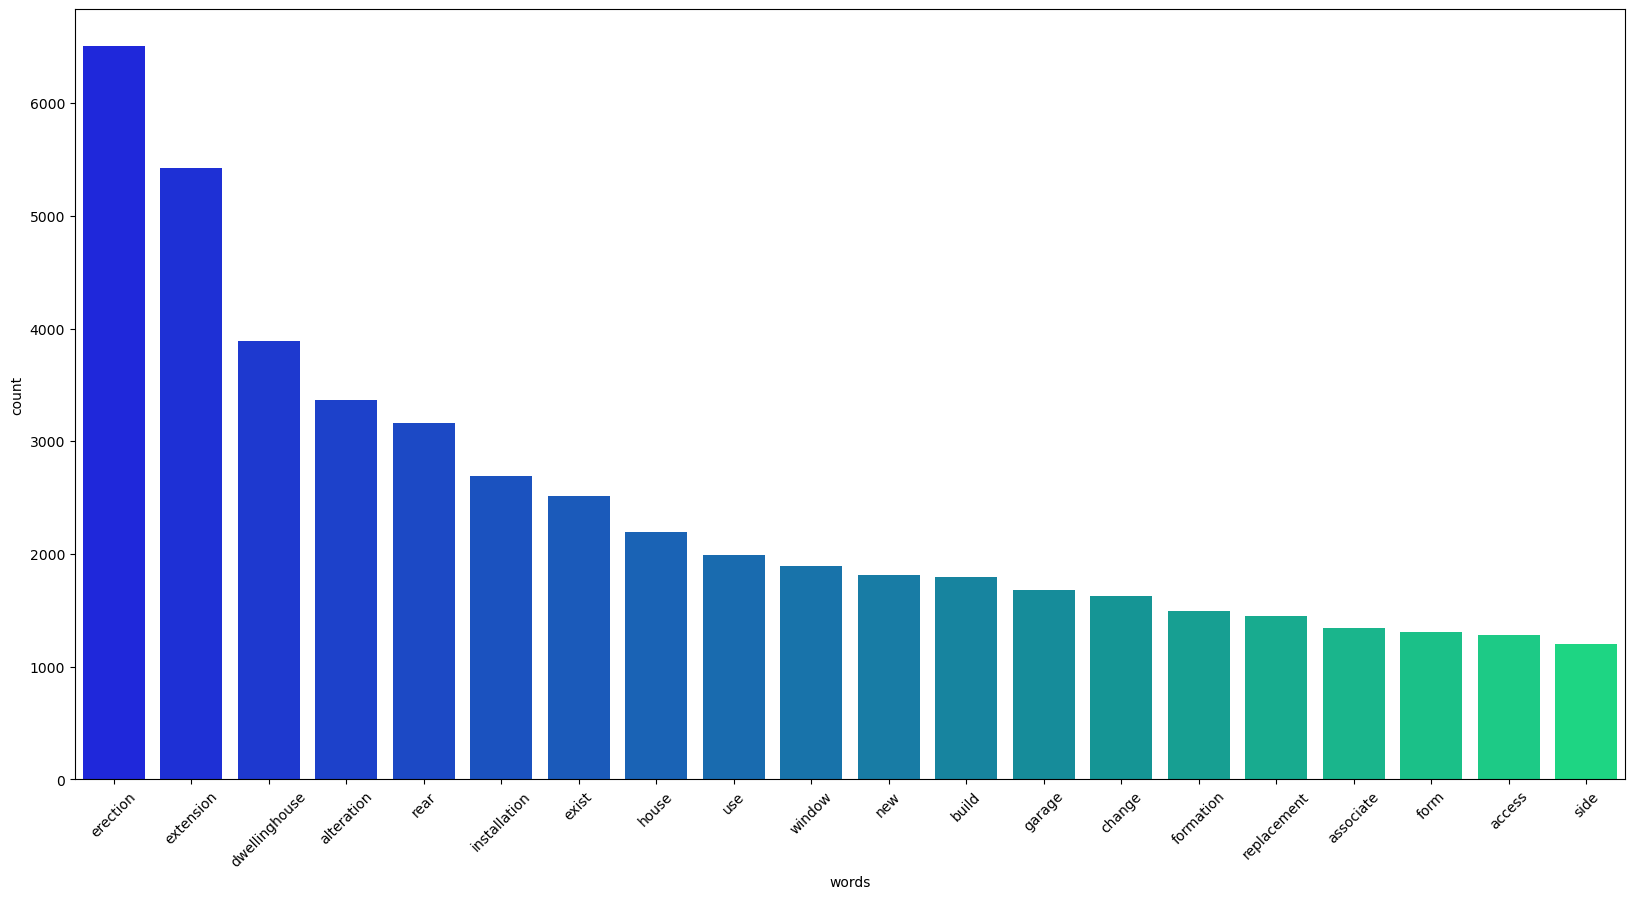

In [71]:
# Flatten the list of lists into a single list of words
desc_words_list = [word for sublist in planapp_gdf['feature_cleaned_3'] for word in sublist]

# Join all word corpus
desc_words = ' '.join(desc_words_list)

# Count and find the 30 most frequent after cleaning
word_counter = Counter(desc_words.split())
most_frequent = word_counter.most_common(20)

# Bar plot of frequent words
fig = plt.figure(1, figsize=(20, 10))
_ = pd.DataFrame(most_frequent, columns=("words", "count"))
sns.barplot(x='words', y='count', data=_, palette='winter')
plt.xticks(rotation=45)
plt.show()


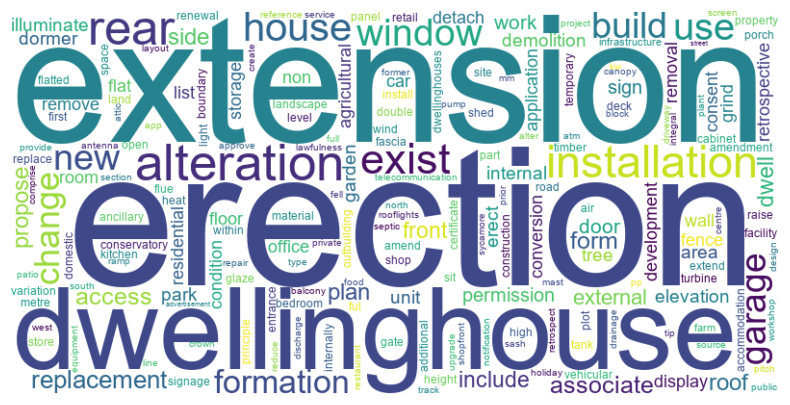

In [72]:
# Combine all words from the 'feature_cleaned_3' column into a single list
desc_words_list = [word for sublist in planapp_gdf['feature_cleaned_3'] for word in sublist]

# Join all words into a single string
data = ' '.join(desc_words_list)

# Specify the TrueType font file
font_path = 'C:\\Windows\\Fonts\\arial.ttf'

# Calculate word frequencies
word_frequencies = {word: desc_words_list.count(word) for word in set(desc_words_list)}

# Generate the word cloud using word frequencies
wordcloud = WordCloud(font_path=font_path, background_color='white', width=800, height=400).generate_from_frequencies(word_frequencies)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tokenisation of phrases to create words 

In [73]:
id2word = gensim.corpora.Dictionary(planapp_gdf["feature_cleaned_3"])

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in planapp_gdf["feature_cleaned_3"]]

In [75]:
from gensim.models import CoherenceModel, LdaMulticore

# Compute coherence score
number_of_topics = []
coherence_score = []
for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             iterations=10,
                             num_topics=i,
                             workers=8,
                             passes=2)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=planapp_gdf["feature_cleaned_3"],
                                         dictionary=id2word,
                                         coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    number_of_topics.append(i)
    coherence_score.append(coherence_lda)

    # Print coherence score for each iteration
    print(f"Iteration {i}: Coherence Score = {coherence_lda}")


Iteration 1: Coherence Score = -2.5947379283029566
Iteration 2: Coherence Score = -3.34151589796062
Iteration 3: Coherence Score = -3.206592452034806
Iteration 4: Coherence Score = -3.2462237350279084
Iteration 5: Coherence Score = -3.2419383578875056
Iteration 6: Coherence Score = -3.383862524624426
Iteration 7: Coherence Score = -3.387232208215353
Iteration 8: Coherence Score = -3.8269774653188313
Iteration 9: Coherence Score = -3.3504260080436046
Iteration 10: Coherence Score = -3.352719400623618
Iteration 11: Coherence Score = -3.4081663298709857
Iteration 12: Coherence Score = -3.4941083336808183
Iteration 13: Coherence Score = -3.375718120036581
Iteration 14: Coherence Score = -3.5945496763029583
Iteration 15: Coherence Score = -3.8324207133082795
Iteration 16: Coherence Score = -3.5538358897897635
Iteration 17: Coherence Score = -3.562888204357399
Iteration 18: Coherence Score = -3.9079022841194035
Iteration 19: Coherence Score = -3.74058810418927


## plot using window and smoothing

<AxesSubplot:xlabel='number_of_topics', ylabel='coherence_score_smoothed'>

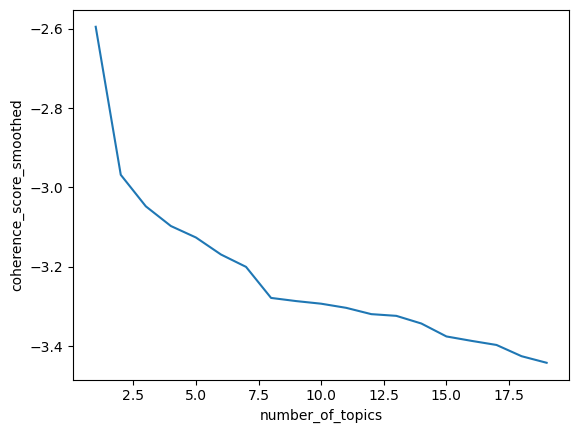

In [76]:
#compute coherence scores
topic_coherence = pd.DataFrame({'number_of_topics': number_of_topics,
                                'coherence_score': coherence_score})

# Compute moving average with window size 3 (you can adjust the window size as needed)
topic_coherence['coherence_score_smoothed'] = topic_coherence['coherence_score'].rolling(window=50, min_periods=1).mean()

# Plot the smoothed coherence scores
sns.lineplot(data=topic_coherence, x='number_of_topics', y='coherence_score_smoothed')


## Topic Modelling

In [77]:
import logging

n_topics = 12

# Set logging level to INFO for verbose logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

2023-07-23 19:12:04,762 : INFO : using symmetric alpha at 0.08333333333333333
2023-07-23 19:12:04,764 : INFO : using symmetric eta at 0.08333333333333333
2023-07-23 19:12:04,769 : INFO : using serial LDA version on this node
2023-07-23 19:12:04,787 : INFO : running batch LDA training, 12 topics, 10 passes over the supplied corpus of 20000 documents, updating model once every 20000 documents, evaluating perplexity every 100 documents, iterating 100x with a convergence threshold of 0.001000
2023-07-23 19:12:04,789 : INFO : PROGRESS: pass 0, at document #10/20000
2023-07-23 19:12:04,802 : INFO : PROGRESS: pass 0, at document #20/20000
2023-07-23 19:12:04,819 : INFO : PROGRESS: pass 0, at document #30/20000
2023-07-23 19:12:04,835 : INFO : PROGRESS: pass 0, at document #40/20000
2023-07-23 19:12:04,848 : INFO : PROGRESS: pass 0, at document #50/20000
2023-07-23 19:12:04,859 : INFO : PROGRESS: pass 0, at document #60/20000
2023-07-23 19:12:04,874 : INFO : PROGRESS: pass 0, at document #70/2

2023-07-23 19:12:06,261 : INFO : -10.742 per-word bound, 1712.8 perplexity estimate based on a held-out corpus of 10 documents with 45 words
2023-07-23 19:12:06,263 : INFO : PROGRESS: pass 0, at document #900/20000
2023-07-23 19:12:06,274 : INFO : PROGRESS: pass 0, at document #910/20000
2023-07-23 19:12:06,288 : INFO : PROGRESS: pass 0, at document #920/20000
2023-07-23 19:12:06,301 : INFO : PROGRESS: pass 0, at document #930/20000
2023-07-23 19:12:06,315 : INFO : PROGRESS: pass 0, at document #940/20000
2023-07-23 19:12:06,330 : INFO : PROGRESS: pass 0, at document #950/20000
2023-07-23 19:12:06,343 : INFO : PROGRESS: pass 0, at document #960/20000
2023-07-23 19:12:06,357 : INFO : PROGRESS: pass 0, at document #970/20000
2023-07-23 19:12:06,371 : INFO : PROGRESS: pass 0, at document #980/20000
2023-07-23 19:12:06,383 : INFO : PROGRESS: pass 0, at document #990/20000
2023-07-23 19:12:06,416 : INFO : -10.034 per-word bound, 1048.2 perplexity estimate based on a held-out corpus of 10 do

2023-07-23 19:12:07,689 : INFO : PROGRESS: pass 0, at document #1810/20000
2023-07-23 19:12:07,702 : INFO : PROGRESS: pass 0, at document #1820/20000
2023-07-23 19:12:07,716 : INFO : PROGRESS: pass 0, at document #1830/20000
2023-07-23 19:12:07,728 : INFO : PROGRESS: pass 0, at document #1840/20000
2023-07-23 19:12:07,740 : INFO : PROGRESS: pass 0, at document #1850/20000
2023-07-23 19:12:07,751 : INFO : PROGRESS: pass 0, at document #1860/20000
2023-07-23 19:12:07,759 : INFO : PROGRESS: pass 0, at document #1870/20000
2023-07-23 19:12:07,772 : INFO : PROGRESS: pass 0, at document #1880/20000
2023-07-23 19:12:07,784 : INFO : PROGRESS: pass 0, at document #1890/20000
2023-07-23 19:12:07,820 : INFO : -10.101 per-word bound, 1098.5 perplexity estimate based on a held-out corpus of 10 documents with 74 words
2023-07-23 19:12:07,822 : INFO : PROGRESS: pass 0, at document #1900/20000
2023-07-23 19:12:07,833 : INFO : PROGRESS: pass 0, at document #1910/20000
2023-07-23 19:12:07,846 : INFO : P

2023-07-23 19:12:09,278 : INFO : PROGRESS: pass 0, at document #2740/20000
2023-07-23 19:12:09,289 : INFO : PROGRESS: pass 0, at document #2750/20000
2023-07-23 19:12:09,306 : INFO : PROGRESS: pass 0, at document #2760/20000
2023-07-23 19:12:09,321 : INFO : PROGRESS: pass 0, at document #2770/20000
2023-07-23 19:12:09,336 : INFO : PROGRESS: pass 0, at document #2780/20000
2023-07-23 19:12:09,350 : INFO : PROGRESS: pass 0, at document #2790/20000
2023-07-23 19:12:09,392 : INFO : -10.329 per-word bound, 1286.4 perplexity estimate based on a held-out corpus of 10 documents with 59 words
2023-07-23 19:12:09,394 : INFO : PROGRESS: pass 0, at document #2800/20000
2023-07-23 19:12:09,407 : INFO : PROGRESS: pass 0, at document #2810/20000
2023-07-23 19:12:09,421 : INFO : PROGRESS: pass 0, at document #2820/20000
2023-07-23 19:12:09,436 : INFO : PROGRESS: pass 0, at document #2830/20000
2023-07-23 19:12:09,458 : INFO : PROGRESS: pass 0, at document #2840/20000
2023-07-23 19:12:09,471 : INFO : P

2023-07-23 19:12:10,739 : INFO : PROGRESS: pass 0, at document #3670/20000
2023-07-23 19:12:10,757 : INFO : PROGRESS: pass 0, at document #3680/20000
2023-07-23 19:12:10,771 : INFO : PROGRESS: pass 0, at document #3690/20000
2023-07-23 19:12:10,802 : INFO : -10.378 per-word bound, 1331.0 perplexity estimate based on a held-out corpus of 10 documents with 59 words
2023-07-23 19:12:10,805 : INFO : PROGRESS: pass 0, at document #3700/20000
2023-07-23 19:12:10,818 : INFO : PROGRESS: pass 0, at document #3710/20000
2023-07-23 19:12:10,831 : INFO : PROGRESS: pass 0, at document #3720/20000
2023-07-23 19:12:10,842 : INFO : PROGRESS: pass 0, at document #3730/20000
2023-07-23 19:12:10,855 : INFO : PROGRESS: pass 0, at document #3740/20000
2023-07-23 19:12:10,866 : INFO : PROGRESS: pass 0, at document #3750/20000
2023-07-23 19:12:10,877 : INFO : PROGRESS: pass 0, at document #3760/20000
2023-07-23 19:12:10,892 : INFO : PROGRESS: pass 0, at document #3770/20000
2023-07-23 19:12:10,904 : INFO : P

2023-07-23 19:12:12,147 : INFO : -10.162 per-word bound, 1146.0 perplexity estimate based on a held-out corpus of 10 documents with 68 words
2023-07-23 19:12:12,148 : INFO : PROGRESS: pass 0, at document #4600/20000
2023-07-23 19:12:12,161 : INFO : PROGRESS: pass 0, at document #4610/20000
2023-07-23 19:12:12,171 : INFO : PROGRESS: pass 0, at document #4620/20000
2023-07-23 19:12:12,185 : INFO : PROGRESS: pass 0, at document #4630/20000
2023-07-23 19:12:12,196 : INFO : PROGRESS: pass 0, at document #4640/20000
2023-07-23 19:12:12,206 : INFO : PROGRESS: pass 0, at document #4650/20000
2023-07-23 19:12:12,219 : INFO : PROGRESS: pass 0, at document #4660/20000
2023-07-23 19:12:12,233 : INFO : PROGRESS: pass 0, at document #4670/20000
2023-07-23 19:12:12,248 : INFO : PROGRESS: pass 0, at document #4680/20000
2023-07-23 19:12:12,260 : INFO : PROGRESS: pass 0, at document #4690/20000
2023-07-23 19:12:12,294 : INFO : -10.080 per-word bound, 1082.3 perplexity estimate based on a held-out corpu

2023-07-23 19:12:13,560 : INFO : PROGRESS: pass 0, at document #5510/20000
2023-07-23 19:12:13,570 : INFO : PROGRESS: pass 0, at document #5520/20000
2023-07-23 19:12:13,584 : INFO : PROGRESS: pass 0, at document #5530/20000
2023-07-23 19:12:13,595 : INFO : PROGRESS: pass 0, at document #5540/20000
2023-07-23 19:12:13,607 : INFO : PROGRESS: pass 0, at document #5550/20000
2023-07-23 19:12:13,622 : INFO : PROGRESS: pass 0, at document #5560/20000
2023-07-23 19:12:13,637 : INFO : PROGRESS: pass 0, at document #5570/20000
2023-07-23 19:12:13,650 : INFO : PROGRESS: pass 0, at document #5580/20000
2023-07-23 19:12:13,662 : INFO : PROGRESS: pass 0, at document #5590/20000
2023-07-23 19:12:13,694 : INFO : -10.430 per-word bound, 1379.9 perplexity estimate based on a held-out corpus of 10 documents with 54 words
2023-07-23 19:12:13,695 : INFO : PROGRESS: pass 0, at document #5600/20000
2023-07-23 19:12:13,708 : INFO : PROGRESS: pass 0, at document #5610/20000
2023-07-23 19:12:13,721 : INFO : P

2023-07-23 19:12:14,988 : INFO : PROGRESS: pass 0, at document #6440/20000
2023-07-23 19:12:15,001 : INFO : PROGRESS: pass 0, at document #6450/20000
2023-07-23 19:12:15,013 : INFO : PROGRESS: pass 0, at document #6460/20000
2023-07-23 19:12:15,026 : INFO : PROGRESS: pass 0, at document #6470/20000
2023-07-23 19:12:15,037 : INFO : PROGRESS: pass 0, at document #6480/20000
2023-07-23 19:12:15,048 : INFO : PROGRESS: pass 0, at document #6490/20000
2023-07-23 19:12:15,082 : INFO : -10.179 per-word bound, 1158.9 perplexity estimate based on a held-out corpus of 10 documents with 68 words
2023-07-23 19:12:15,084 : INFO : PROGRESS: pass 0, at document #6500/20000
2023-07-23 19:12:15,105 : INFO : PROGRESS: pass 0, at document #6510/20000
2023-07-23 19:12:15,117 : INFO : PROGRESS: pass 0, at document #6520/20000
2023-07-23 19:12:15,132 : INFO : PROGRESS: pass 0, at document #6530/20000
2023-07-23 19:12:15,145 : INFO : PROGRESS: pass 0, at document #6540/20000
2023-07-23 19:12:15,156 : INFO : P

2023-07-23 19:12:16,351 : INFO : PROGRESS: pass 0, at document #7370/20000
2023-07-23 19:12:16,363 : INFO : PROGRESS: pass 0, at document #7380/20000
2023-07-23 19:12:16,374 : INFO : PROGRESS: pass 0, at document #7390/20000
2023-07-23 19:12:16,406 : INFO : -10.077 per-word bound, 1080.0 perplexity estimate based on a held-out corpus of 10 documents with 76 words
2023-07-23 19:12:16,408 : INFO : PROGRESS: pass 0, at document #7400/20000
2023-07-23 19:12:16,422 : INFO : PROGRESS: pass 0, at document #7410/20000
2023-07-23 19:12:16,435 : INFO : PROGRESS: pass 0, at document #7420/20000
2023-07-23 19:12:16,449 : INFO : PROGRESS: pass 0, at document #7430/20000
2023-07-23 19:12:16,462 : INFO : PROGRESS: pass 0, at document #7440/20000
2023-07-23 19:12:16,473 : INFO : PROGRESS: pass 0, at document #7450/20000
2023-07-23 19:12:16,485 : INFO : PROGRESS: pass 0, at document #7460/20000
2023-07-23 19:12:16,497 : INFO : PROGRESS: pass 0, at document #7470/20000
2023-07-23 19:12:16,508 : INFO : P

2023-07-23 19:12:17,755 : INFO : -10.305 per-word bound, 1265.1 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:12:17,756 : INFO : PROGRESS: pass 0, at document #8300/20000
2023-07-23 19:12:17,770 : INFO : PROGRESS: pass 0, at document #8310/20000
2023-07-23 19:12:17,781 : INFO : PROGRESS: pass 0, at document #8320/20000
2023-07-23 19:12:17,792 : INFO : PROGRESS: pass 0, at document #8330/20000
2023-07-23 19:12:17,805 : INFO : PROGRESS: pass 0, at document #8340/20000
2023-07-23 19:12:17,815 : INFO : PROGRESS: pass 0, at document #8350/20000
2023-07-23 19:12:17,832 : INFO : PROGRESS: pass 0, at document #8360/20000
2023-07-23 19:12:17,840 : INFO : PROGRESS: pass 0, at document #8370/20000
2023-07-23 19:12:17,853 : INFO : PROGRESS: pass 0, at document #8380/20000
2023-07-23 19:12:17,868 : INFO : PROGRESS: pass 0, at document #8390/20000
2023-07-23 19:12:17,906 : INFO : -10.277 per-word bound, 1240.4 perplexity estimate based on a held-out corpu

2023-07-23 19:12:19,151 : INFO : PROGRESS: pass 0, at document #9210/20000
2023-07-23 19:12:19,162 : INFO : PROGRESS: pass 0, at document #9220/20000
2023-07-23 19:12:19,176 : INFO : PROGRESS: pass 0, at document #9230/20000
2023-07-23 19:12:19,188 : INFO : PROGRESS: pass 0, at document #9240/20000
2023-07-23 19:12:19,202 : INFO : PROGRESS: pass 0, at document #9250/20000
2023-07-23 19:12:19,216 : INFO : PROGRESS: pass 0, at document #9260/20000
2023-07-23 19:12:19,234 : INFO : PROGRESS: pass 0, at document #9270/20000
2023-07-23 19:12:19,244 : INFO : PROGRESS: pass 0, at document #9280/20000
2023-07-23 19:12:19,257 : INFO : PROGRESS: pass 0, at document #9290/20000
2023-07-23 19:12:19,294 : INFO : -10.330 per-word bound, 1287.3 perplexity estimate based on a held-out corpus of 10 documents with 60 words
2023-07-23 19:12:19,295 : INFO : PROGRESS: pass 0, at document #9300/20000
2023-07-23 19:12:19,307 : INFO : PROGRESS: pass 0, at document #9310/20000
2023-07-23 19:12:19,324 : INFO : P

2023-07-23 19:12:20,603 : INFO : PROGRESS: pass 0, at document #10140/20000
2023-07-23 19:12:20,617 : INFO : PROGRESS: pass 0, at document #10150/20000
2023-07-23 19:12:20,629 : INFO : PROGRESS: pass 0, at document #10160/20000
2023-07-23 19:12:20,640 : INFO : PROGRESS: pass 0, at document #10170/20000
2023-07-23 19:12:20,650 : INFO : PROGRESS: pass 0, at document #10180/20000
2023-07-23 19:12:20,661 : INFO : PROGRESS: pass 0, at document #10190/20000
2023-07-23 19:12:20,689 : INFO : -10.727 per-word bound, 1694.3 perplexity estimate based on a held-out corpus of 10 documents with 45 words
2023-07-23 19:12:20,691 : INFO : PROGRESS: pass 0, at document #10200/20000
2023-07-23 19:12:20,703 : INFO : PROGRESS: pass 0, at document #10210/20000
2023-07-23 19:12:20,712 : INFO : PROGRESS: pass 0, at document #10220/20000
2023-07-23 19:12:20,723 : INFO : PROGRESS: pass 0, at document #10230/20000
2023-07-23 19:12:20,735 : INFO : PROGRESS: pass 0, at document #10240/20000
2023-07-23 19:12:20,745

2023-07-23 19:12:21,984 : INFO : PROGRESS: pass 0, at document #11060/20000
2023-07-23 19:12:22,003 : INFO : PROGRESS: pass 0, at document #11070/20000
2023-07-23 19:12:22,014 : INFO : PROGRESS: pass 0, at document #11080/20000
2023-07-23 19:12:22,031 : INFO : PROGRESS: pass 0, at document #11090/20000
2023-07-23 19:12:22,068 : INFO : -10.251 per-word bound, 1219.0 perplexity estimate based on a held-out corpus of 10 documents with 64 words
2023-07-23 19:12:22,069 : INFO : PROGRESS: pass 0, at document #11100/20000
2023-07-23 19:12:22,082 : INFO : PROGRESS: pass 0, at document #11110/20000
2023-07-23 19:12:22,095 : INFO : PROGRESS: pass 0, at document #11120/20000
2023-07-23 19:12:22,111 : INFO : PROGRESS: pass 0, at document #11130/20000
2023-07-23 19:12:22,128 : INFO : PROGRESS: pass 0, at document #11140/20000
2023-07-23 19:12:22,140 : INFO : PROGRESS: pass 0, at document #11150/20000
2023-07-23 19:12:22,150 : INFO : PROGRESS: pass 0, at document #11160/20000
2023-07-23 19:12:22,161

2023-07-23 19:12:23,379 : INFO : PROGRESS: pass 0, at document #11980/20000
2023-07-23 19:12:23,396 : INFO : PROGRESS: pass 0, at document #11990/20000
2023-07-23 19:12:23,427 : INFO : -10.023 per-word bound, 1040.3 perplexity estimate based on a held-out corpus of 10 documents with 80 words
2023-07-23 19:12:23,428 : INFO : PROGRESS: pass 0, at document #12000/20000
2023-07-23 19:12:23,442 : INFO : PROGRESS: pass 0, at document #12010/20000
2023-07-23 19:12:23,456 : INFO : PROGRESS: pass 0, at document #12020/20000
2023-07-23 19:12:23,467 : INFO : PROGRESS: pass 0, at document #12030/20000
2023-07-23 19:12:23,480 : INFO : PROGRESS: pass 0, at document #12040/20000
2023-07-23 19:12:23,492 : INFO : PROGRESS: pass 0, at document #12050/20000
2023-07-23 19:12:23,505 : INFO : PROGRESS: pass 0, at document #12060/20000
2023-07-23 19:12:23,519 : INFO : PROGRESS: pass 0, at document #12070/20000
2023-07-23 19:12:23,532 : INFO : PROGRESS: pass 0, at document #12080/20000
2023-07-23 19:12:23,546

2023-07-23 19:12:24,883 : INFO : -9.837 per-word bound, 914.4 perplexity estimate based on a held-out corpus of 10 documents with 103 words
2023-07-23 19:12:24,884 : INFO : PROGRESS: pass 0, at document #12900/20000
2023-07-23 19:12:24,900 : INFO : PROGRESS: pass 0, at document #12910/20000
2023-07-23 19:12:24,913 : INFO : PROGRESS: pass 0, at document #12920/20000
2023-07-23 19:12:24,929 : INFO : PROGRESS: pass 0, at document #12930/20000
2023-07-23 19:12:24,943 : INFO : PROGRESS: pass 0, at document #12940/20000
2023-07-23 19:12:24,955 : INFO : PROGRESS: pass 0, at document #12950/20000
2023-07-23 19:12:24,969 : INFO : PROGRESS: pass 0, at document #12960/20000
2023-07-23 19:12:24,980 : INFO : PROGRESS: pass 0, at document #12970/20000
2023-07-23 19:12:25,000 : INFO : PROGRESS: pass 0, at document #12980/20000
2023-07-23 19:12:25,015 : INFO : PROGRESS: pass 0, at document #12990/20000
2023-07-23 19:12:25,049 : INFO : -9.959 per-word bound, 995.1 perplexity estimate based on a held-ou

2023-07-23 19:12:26,387 : INFO : PROGRESS: pass 0, at document #13800/20000
2023-07-23 19:12:26,405 : INFO : PROGRESS: pass 0, at document #13810/20000
2023-07-23 19:12:26,419 : INFO : PROGRESS: pass 0, at document #13820/20000
2023-07-23 19:12:26,434 : INFO : PROGRESS: pass 0, at document #13830/20000
2023-07-23 19:12:26,447 : INFO : PROGRESS: pass 0, at document #13840/20000
2023-07-23 19:12:26,457 : INFO : PROGRESS: pass 0, at document #13850/20000
2023-07-23 19:12:26,470 : INFO : PROGRESS: pass 0, at document #13860/20000
2023-07-23 19:12:26,482 : INFO : PROGRESS: pass 0, at document #13870/20000
2023-07-23 19:12:26,496 : INFO : PROGRESS: pass 0, at document #13880/20000
2023-07-23 19:12:26,509 : INFO : PROGRESS: pass 0, at document #13890/20000
2023-07-23 19:12:26,542 : INFO : -10.411 per-word bound, 1362.0 perplexity estimate based on a held-out corpus of 10 documents with 55 words
2023-07-23 19:12:26,543 : INFO : PROGRESS: pass 0, at document #13900/20000
2023-07-23 19:12:26,555

2023-07-23 19:12:27,819 : INFO : PROGRESS: pass 0, at document #14720/20000
2023-07-23 19:12:27,833 : INFO : PROGRESS: pass 0, at document #14730/20000
2023-07-23 19:12:27,843 : INFO : PROGRESS: pass 0, at document #14740/20000
2023-07-23 19:12:27,855 : INFO : PROGRESS: pass 0, at document #14750/20000
2023-07-23 19:12:27,870 : INFO : PROGRESS: pass 0, at document #14760/20000
2023-07-23 19:12:27,883 : INFO : PROGRESS: pass 0, at document #14770/20000
2023-07-23 19:12:27,895 : INFO : PROGRESS: pass 0, at document #14780/20000
2023-07-23 19:12:27,905 : INFO : PROGRESS: pass 0, at document #14790/20000
2023-07-23 19:12:27,944 : INFO : -9.919 per-word bound, 968.0 perplexity estimate based on a held-out corpus of 10 documents with 92 words
2023-07-23 19:12:27,945 : INFO : PROGRESS: pass 0, at document #14800/20000
2023-07-23 19:12:27,960 : INFO : PROGRESS: pass 0, at document #14810/20000
2023-07-23 19:12:27,977 : INFO : PROGRESS: pass 0, at document #14820/20000
2023-07-23 19:12:27,991 :

2023-07-23 19:12:29,237 : INFO : PROGRESS: pass 0, at document #15640/20000
2023-07-23 19:12:29,250 : INFO : PROGRESS: pass 0, at document #15650/20000
2023-07-23 19:12:29,262 : INFO : PROGRESS: pass 0, at document #15660/20000
2023-07-23 19:12:29,280 : INFO : PROGRESS: pass 0, at document #15670/20000
2023-07-23 19:12:29,293 : INFO : PROGRESS: pass 0, at document #15680/20000
2023-07-23 19:12:29,302 : INFO : PROGRESS: pass 0, at document #15690/20000
2023-07-23 19:12:29,335 : INFO : -9.803 per-word bound, 893.4 perplexity estimate based on a held-out corpus of 10 documents with 103 words
2023-07-23 19:12:29,336 : INFO : PROGRESS: pass 0, at document #15700/20000
2023-07-23 19:12:29,352 : INFO : PROGRESS: pass 0, at document #15710/20000
2023-07-23 19:12:29,367 : INFO : PROGRESS: pass 0, at document #15720/20000
2023-07-23 19:12:29,381 : INFO : PROGRESS: pass 0, at document #15730/20000
2023-07-23 19:12:29,394 : INFO : PROGRESS: pass 0, at document #15740/20000
2023-07-23 19:12:29,410 

2023-07-23 19:12:30,648 : INFO : PROGRESS: pass 0, at document #16560/20000
2023-07-23 19:12:30,661 : INFO : PROGRESS: pass 0, at document #16570/20000
2023-07-23 19:12:30,671 : INFO : PROGRESS: pass 0, at document #16580/20000
2023-07-23 19:12:30,684 : INFO : PROGRESS: pass 0, at document #16590/20000
2023-07-23 19:12:30,716 : INFO : -10.156 per-word bound, 1140.6 perplexity estimate based on a held-out corpus of 10 documents with 70 words
2023-07-23 19:12:30,717 : INFO : PROGRESS: pass 0, at document #16600/20000
2023-07-23 19:12:30,731 : INFO : PROGRESS: pass 0, at document #16610/20000
2023-07-23 19:12:30,743 : INFO : PROGRESS: pass 0, at document #16620/20000
2023-07-23 19:12:30,758 : INFO : PROGRESS: pass 0, at document #16630/20000
2023-07-23 19:12:30,771 : INFO : PROGRESS: pass 0, at document #16640/20000
2023-07-23 19:12:30,783 : INFO : PROGRESS: pass 0, at document #16650/20000
2023-07-23 19:12:30,796 : INFO : PROGRESS: pass 0, at document #16660/20000
2023-07-23 19:12:30,807

2023-07-23 19:12:32,034 : INFO : PROGRESS: pass 0, at document #17480/20000
2023-07-23 19:12:32,047 : INFO : PROGRESS: pass 0, at document #17490/20000
2023-07-23 19:12:32,089 : INFO : -10.113 per-word bound, 1107.6 perplexity estimate based on a held-out corpus of 10 documents with 75 words
2023-07-23 19:12:32,090 : INFO : PROGRESS: pass 0, at document #17500/20000
2023-07-23 19:12:32,107 : INFO : PROGRESS: pass 0, at document #17510/20000
2023-07-23 19:12:32,122 : INFO : PROGRESS: pass 0, at document #17520/20000
2023-07-23 19:12:32,134 : INFO : PROGRESS: pass 0, at document #17530/20000
2023-07-23 19:12:32,147 : INFO : PROGRESS: pass 0, at document #17540/20000
2023-07-23 19:12:32,163 : INFO : PROGRESS: pass 0, at document #17550/20000
2023-07-23 19:12:32,175 : INFO : PROGRESS: pass 0, at document #17560/20000
2023-07-23 19:12:32,194 : INFO : PROGRESS: pass 0, at document #17570/20000
2023-07-23 19:12:32,211 : INFO : PROGRESS: pass 0, at document #17580/20000
2023-07-23 19:12:32,230

2023-07-23 19:12:33,791 : INFO : -9.735 per-word bound, 852.0 perplexity estimate based on a held-out corpus of 10 documents with 122 words
2023-07-23 19:12:33,793 : INFO : PROGRESS: pass 0, at document #18400/20000
2023-07-23 19:12:33,812 : INFO : PROGRESS: pass 0, at document #18410/20000
2023-07-23 19:12:33,825 : INFO : PROGRESS: pass 0, at document #18420/20000
2023-07-23 19:12:33,836 : INFO : PROGRESS: pass 0, at document #18430/20000
2023-07-23 19:12:33,849 : INFO : PROGRESS: pass 0, at document #18440/20000
2023-07-23 19:12:33,860 : INFO : PROGRESS: pass 0, at document #18450/20000
2023-07-23 19:12:33,873 : INFO : PROGRESS: pass 0, at document #18460/20000
2023-07-23 19:12:33,887 : INFO : PROGRESS: pass 0, at document #18470/20000
2023-07-23 19:12:33,900 : INFO : PROGRESS: pass 0, at document #18480/20000
2023-07-23 19:12:33,917 : INFO : PROGRESS: pass 0, at document #18490/20000
2023-07-23 19:12:33,947 : INFO : -10.477 per-word bound, 1425.7 perplexity estimate based on a held-

2023-07-23 19:12:35,286 : INFO : PROGRESS: pass 0, at document #19300/20000
2023-07-23 19:12:35,298 : INFO : PROGRESS: pass 0, at document #19310/20000
2023-07-23 19:12:35,310 : INFO : PROGRESS: pass 0, at document #19320/20000
2023-07-23 19:12:35,326 : INFO : PROGRESS: pass 0, at document #19330/20000
2023-07-23 19:12:35,337 : INFO : PROGRESS: pass 0, at document #19340/20000
2023-07-23 19:12:35,352 : INFO : PROGRESS: pass 0, at document #19350/20000
2023-07-23 19:12:35,370 : INFO : PROGRESS: pass 0, at document #19360/20000
2023-07-23 19:12:35,387 : INFO : PROGRESS: pass 0, at document #19370/20000
2023-07-23 19:12:35,401 : INFO : PROGRESS: pass 0, at document #19380/20000
2023-07-23 19:12:35,415 : INFO : PROGRESS: pass 0, at document #19390/20000
2023-07-23 19:12:35,459 : INFO : -10.075 per-word bound, 1078.7 perplexity estimate based on a held-out corpus of 10 documents with 77 words
2023-07-23 19:12:35,460 : INFO : PROGRESS: pass 0, at document #19400/20000
2023-07-23 19:12:35,478

2023-07-23 19:12:36,810 : INFO : -6.910 per-word bound, 120.2 perplexity estimate based on a held-out corpus of 10 documents with 52 words
2023-07-23 19:12:36,812 : INFO : PROGRESS: pass 1, at document #100/20000
2023-07-23 19:12:36,827 : INFO : PROGRESS: pass 1, at document #110/20000
2023-07-23 19:12:36,846 : INFO : PROGRESS: pass 1, at document #120/20000
2023-07-23 19:12:36,863 : INFO : PROGRESS: pass 1, at document #130/20000
2023-07-23 19:12:36,879 : INFO : PROGRESS: pass 1, at document #140/20000
2023-07-23 19:12:36,891 : INFO : PROGRESS: pass 1, at document #150/20000
2023-07-23 19:12:36,906 : INFO : PROGRESS: pass 1, at document #160/20000
2023-07-23 19:12:36,921 : INFO : PROGRESS: pass 1, at document #170/20000
2023-07-23 19:12:36,937 : INFO : PROGRESS: pass 1, at document #180/20000
2023-07-23 19:12:36,954 : INFO : PROGRESS: pass 1, at document #190/20000
2023-07-23 19:12:36,991 : INFO : -6.589 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 10 documen

2023-07-23 19:12:38,306 : INFO : PROGRESS: pass 1, at document #1020/20000
2023-07-23 19:12:38,317 : INFO : PROGRESS: pass 1, at document #1030/20000
2023-07-23 19:12:38,337 : INFO : PROGRESS: pass 1, at document #1040/20000
2023-07-23 19:12:38,351 : INFO : PROGRESS: pass 1, at document #1050/20000
2023-07-23 19:12:38,364 : INFO : PROGRESS: pass 1, at document #1060/20000
2023-07-23 19:12:38,375 : INFO : PROGRESS: pass 1, at document #1070/20000
2023-07-23 19:12:38,391 : INFO : PROGRESS: pass 1, at document #1080/20000
2023-07-23 19:12:38,402 : INFO : PROGRESS: pass 1, at document #1090/20000
2023-07-23 19:12:38,436 : INFO : -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 10 documents with 55 words
2023-07-23 19:12:38,440 : INFO : PROGRESS: pass 1, at document #1100/20000
2023-07-23 19:12:38,449 : INFO : PROGRESS: pass 1, at document #1110/20000
2023-07-23 19:12:38,461 : INFO : PROGRESS: pass 1, at document #1120/20000
2023-07-23 19:12:38,469 : INFO : PROG

2023-07-23 19:12:39,713 : INFO : PROGRESS: pass 1, at document #1950/20000
2023-07-23 19:12:39,722 : INFO : PROGRESS: pass 1, at document #1960/20000
2023-07-23 19:12:39,739 : INFO : PROGRESS: pass 1, at document #1970/20000
2023-07-23 19:12:39,754 : INFO : PROGRESS: pass 1, at document #1980/20000
2023-07-23 19:12:39,768 : INFO : PROGRESS: pass 1, at document #1990/20000
2023-07-23 19:12:39,806 : INFO : -6.600 per-word bound, 97.0 perplexity estimate based on a held-out corpus of 10 documents with 101 words
2023-07-23 19:12:39,808 : INFO : PROGRESS: pass 1, at document #2000/20000
2023-07-23 19:12:39,821 : INFO : PROGRESS: pass 1, at document #2010/20000
2023-07-23 19:12:39,838 : INFO : PROGRESS: pass 1, at document #2020/20000
2023-07-23 19:12:39,854 : INFO : PROGRESS: pass 1, at document #2030/20000
2023-07-23 19:12:39,865 : INFO : PROGRESS: pass 1, at document #2040/20000
2023-07-23 19:12:39,880 : INFO : PROGRESS: pass 1, at document #2050/20000
2023-07-23 19:12:39,895 : INFO : PRO

2023-07-23 19:12:41,336 : INFO : PROGRESS: pass 1, at document #2880/20000
2023-07-23 19:12:41,350 : INFO : PROGRESS: pass 1, at document #2890/20000
2023-07-23 19:12:41,389 : INFO : -6.242 per-word bound, 75.7 perplexity estimate based on a held-out corpus of 10 documents with 121 words
2023-07-23 19:12:41,391 : INFO : PROGRESS: pass 1, at document #2900/20000
2023-07-23 19:12:41,408 : INFO : PROGRESS: pass 1, at document #2910/20000
2023-07-23 19:12:41,418 : INFO : PROGRESS: pass 1, at document #2920/20000
2023-07-23 19:12:41,431 : INFO : PROGRESS: pass 1, at document #2930/20000
2023-07-23 19:12:41,443 : INFO : PROGRESS: pass 1, at document #2940/20000
2023-07-23 19:12:41,457 : INFO : PROGRESS: pass 1, at document #2950/20000
2023-07-23 19:12:41,468 : INFO : PROGRESS: pass 1, at document #2960/20000
2023-07-23 19:12:41,483 : INFO : PROGRESS: pass 1, at document #2970/20000
2023-07-23 19:12:41,496 : INFO : PROGRESS: pass 1, at document #2980/20000
2023-07-23 19:12:41,508 : INFO : PRO

2023-07-23 19:12:42,755 : INFO : PROGRESS: pass 1, at document #3800/20000
2023-07-23 19:12:42,767 : INFO : PROGRESS: pass 1, at document #3810/20000
2023-07-23 19:12:42,780 : INFO : PROGRESS: pass 1, at document #3820/20000
2023-07-23 19:12:42,792 : INFO : PROGRESS: pass 1, at document #3830/20000
2023-07-23 19:12:42,803 : INFO : PROGRESS: pass 1, at document #3840/20000
2023-07-23 19:12:42,814 : INFO : PROGRESS: pass 1, at document #3850/20000
2023-07-23 19:12:42,828 : INFO : PROGRESS: pass 1, at document #3860/20000
2023-07-23 19:12:42,840 : INFO : PROGRESS: pass 1, at document #3870/20000
2023-07-23 19:12:42,853 : INFO : PROGRESS: pass 1, at document #3880/20000
2023-07-23 19:12:42,866 : INFO : PROGRESS: pass 1, at document #3890/20000
2023-07-23 19:12:42,899 : INFO : -6.172 per-word bound, 72.1 perplexity estimate based on a held-out corpus of 10 documents with 58 words
2023-07-23 19:12:42,900 : INFO : PROGRESS: pass 1, at document #3900/20000
2023-07-23 19:12:42,911 : INFO : PROG

2023-07-23 19:12:44,205 : INFO : PROGRESS: pass 1, at document #4730/20000
2023-07-23 19:12:44,217 : INFO : PROGRESS: pass 1, at document #4740/20000
2023-07-23 19:12:44,228 : INFO : PROGRESS: pass 1, at document #4750/20000
2023-07-23 19:12:44,238 : INFO : PROGRESS: pass 1, at document #4760/20000
2023-07-23 19:12:44,250 : INFO : PROGRESS: pass 1, at document #4770/20000
2023-07-23 19:12:44,263 : INFO : PROGRESS: pass 1, at document #4780/20000
2023-07-23 19:12:44,275 : INFO : PROGRESS: pass 1, at document #4790/20000
2023-07-23 19:12:44,304 : INFO : -6.177 per-word bound, 72.3 perplexity estimate based on a held-out corpus of 10 documents with 64 words
2023-07-23 19:12:44,305 : INFO : PROGRESS: pass 1, at document #4800/20000
2023-07-23 19:12:44,316 : INFO : PROGRESS: pass 1, at document #4810/20000
2023-07-23 19:12:44,331 : INFO : PROGRESS: pass 1, at document #4820/20000
2023-07-23 19:12:44,354 : INFO : PROGRESS: pass 1, at document #4830/20000
2023-07-23 19:12:44,368 : INFO : PROG

2023-07-23 19:12:45,766 : INFO : PROGRESS: pass 1, at document #5660/20000
2023-07-23 19:12:45,776 : INFO : PROGRESS: pass 1, at document #5670/20000
2023-07-23 19:12:45,788 : INFO : PROGRESS: pass 1, at document #5680/20000
2023-07-23 19:12:45,800 : INFO : PROGRESS: pass 1, at document #5690/20000
2023-07-23 19:12:45,830 : INFO : -6.701 per-word bound, 104.0 perplexity estimate based on a held-out corpus of 10 documents with 74 words
2023-07-23 19:12:45,831 : INFO : PROGRESS: pass 1, at document #5700/20000
2023-07-23 19:12:45,843 : INFO : PROGRESS: pass 1, at document #5710/20000
2023-07-23 19:12:45,851 : INFO : PROGRESS: pass 1, at document #5720/20000
2023-07-23 19:12:45,862 : INFO : PROGRESS: pass 1, at document #5730/20000
2023-07-23 19:12:45,872 : INFO : PROGRESS: pass 1, at document #5740/20000
2023-07-23 19:12:45,882 : INFO : PROGRESS: pass 1, at document #5750/20000
2023-07-23 19:12:45,910 : INFO : PROGRESS: pass 1, at document #5760/20000
2023-07-23 19:12:45,920 : INFO : PRO

2023-07-23 19:12:47,237 : INFO : PROGRESS: pass 1, at document #6590/20000
2023-07-23 19:12:47,268 : INFO : -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:12:47,270 : INFO : PROGRESS: pass 1, at document #6600/20000
2023-07-23 19:12:47,287 : INFO : PROGRESS: pass 1, at document #6610/20000
2023-07-23 19:12:47,301 : INFO : PROGRESS: pass 1, at document #6620/20000
2023-07-23 19:12:47,313 : INFO : PROGRESS: pass 1, at document #6630/20000
2023-07-23 19:12:47,329 : INFO : PROGRESS: pass 1, at document #6640/20000
2023-07-23 19:12:47,346 : INFO : PROGRESS: pass 1, at document #6650/20000
2023-07-23 19:12:47,362 : INFO : PROGRESS: pass 1, at document #6660/20000
2023-07-23 19:12:47,376 : INFO : PROGRESS: pass 1, at document #6670/20000
2023-07-23 19:12:47,387 : INFO : PROGRESS: pass 1, at document #6680/20000
2023-07-23 19:12:47,398 : INFO : PROGRESS: pass 1, at document #6690/20000
2023-07-23 19:12:47,432 : INFO : -6.8

2023-07-23 19:12:48,676 : INFO : PROGRESS: pass 1, at document #7500/20000
2023-07-23 19:12:48,693 : INFO : PROGRESS: pass 1, at document #7510/20000
2023-07-23 19:12:48,703 : INFO : PROGRESS: pass 1, at document #7520/20000
2023-07-23 19:12:48,715 : INFO : PROGRESS: pass 1, at document #7530/20000
2023-07-23 19:12:48,723 : INFO : PROGRESS: pass 1, at document #7540/20000
2023-07-23 19:12:48,733 : INFO : PROGRESS: pass 1, at document #7550/20000
2023-07-23 19:12:48,747 : INFO : PROGRESS: pass 1, at document #7560/20000
2023-07-23 19:12:48,763 : INFO : PROGRESS: pass 1, at document #7570/20000
2023-07-23 19:12:48,774 : INFO : PROGRESS: pass 1, at document #7580/20000
2023-07-23 19:12:48,784 : INFO : PROGRESS: pass 1, at document #7590/20000
2023-07-23 19:12:48,817 : INFO : -6.138 per-word bound, 70.4 perplexity estimate based on a held-out corpus of 10 documents with 60 words
2023-07-23 19:12:48,819 : INFO : PROGRESS: pass 1, at document #7600/20000
2023-07-23 19:12:48,834 : INFO : PROG

2023-07-23 19:12:50,005 : INFO : PROGRESS: pass 1, at document #8430/20000
2023-07-23 19:12:50,018 : INFO : PROGRESS: pass 1, at document #8440/20000
2023-07-23 19:12:50,030 : INFO : PROGRESS: pass 1, at document #8450/20000
2023-07-23 19:12:50,041 : INFO : PROGRESS: pass 1, at document #8460/20000
2023-07-23 19:12:50,050 : INFO : PROGRESS: pass 1, at document #8470/20000
2023-07-23 19:12:50,064 : INFO : PROGRESS: pass 1, at document #8480/20000
2023-07-23 19:12:50,075 : INFO : PROGRESS: pass 1, at document #8490/20000
2023-07-23 19:12:50,104 : INFO : -6.450 per-word bound, 87.4 perplexity estimate based on a held-out corpus of 10 documents with 58 words
2023-07-23 19:12:50,105 : INFO : PROGRESS: pass 1, at document #8500/20000
2023-07-23 19:12:50,117 : INFO : PROGRESS: pass 1, at document #8510/20000
2023-07-23 19:12:50,126 : INFO : PROGRESS: pass 1, at document #8520/20000
2023-07-23 19:12:50,136 : INFO : PROGRESS: pass 1, at document #8530/20000
2023-07-23 19:12:50,150 : INFO : PROG

2023-07-23 19:12:51,309 : INFO : PROGRESS: pass 1, at document #9360/20000
2023-07-23 19:12:51,322 : INFO : PROGRESS: pass 1, at document #9370/20000
2023-07-23 19:12:51,331 : INFO : PROGRESS: pass 1, at document #9380/20000
2023-07-23 19:12:51,347 : INFO : PROGRESS: pass 1, at document #9390/20000
2023-07-23 19:12:51,378 : INFO : -5.892 per-word bound, 59.4 perplexity estimate based on a held-out corpus of 10 documents with 48 words
2023-07-23 19:12:51,379 : INFO : PROGRESS: pass 1, at document #9400/20000
2023-07-23 19:12:51,395 : INFO : PROGRESS: pass 1, at document #9410/20000
2023-07-23 19:12:51,413 : INFO : PROGRESS: pass 1, at document #9420/20000
2023-07-23 19:12:51,426 : INFO : PROGRESS: pass 1, at document #9430/20000
2023-07-23 19:12:51,438 : INFO : PROGRESS: pass 1, at document #9440/20000
2023-07-23 19:12:51,450 : INFO : PROGRESS: pass 1, at document #9450/20000
2023-07-23 19:12:51,463 : INFO : PROGRESS: pass 1, at document #9460/20000
2023-07-23 19:12:51,473 : INFO : PROG

2023-07-23 19:12:52,597 : INFO : PROGRESS: pass 1, at document #10290/20000
2023-07-23 19:12:52,629 : INFO : -5.564 per-word bound, 47.3 perplexity estimate based on a held-out corpus of 10 documents with 45 words
2023-07-23 19:12:52,630 : INFO : PROGRESS: pass 1, at document #10300/20000
2023-07-23 19:12:52,641 : INFO : PROGRESS: pass 1, at document #10310/20000
2023-07-23 19:12:52,652 : INFO : PROGRESS: pass 1, at document #10320/20000
2023-07-23 19:12:52,663 : INFO : PROGRESS: pass 1, at document #10330/20000
2023-07-23 19:12:52,675 : INFO : PROGRESS: pass 1, at document #10340/20000
2023-07-23 19:12:52,687 : INFO : PROGRESS: pass 1, at document #10350/20000
2023-07-23 19:12:52,696 : INFO : PROGRESS: pass 1, at document #10360/20000
2023-07-23 19:12:52,709 : INFO : PROGRESS: pass 1, at document #10370/20000
2023-07-23 19:12:52,718 : INFO : PROGRESS: pass 1, at document #10380/20000
2023-07-23 19:12:52,727 : INFO : PROGRESS: pass 1, at document #10390/20000
2023-07-23 19:12:52,760 : 

2023-07-23 19:12:53,886 : INFO : PROGRESS: pass 1, at document #11200/20000
2023-07-23 19:12:53,902 : INFO : PROGRESS: pass 1, at document #11210/20000
2023-07-23 19:12:53,912 : INFO : PROGRESS: pass 1, at document #11220/20000
2023-07-23 19:12:53,922 : INFO : PROGRESS: pass 1, at document #11230/20000
2023-07-23 19:12:53,932 : INFO : PROGRESS: pass 1, at document #11240/20000
2023-07-23 19:12:53,944 : INFO : PROGRESS: pass 1, at document #11250/20000
2023-07-23 19:12:53,955 : INFO : PROGRESS: pass 1, at document #11260/20000
2023-07-23 19:12:53,964 : INFO : PROGRESS: pass 1, at document #11270/20000
2023-07-23 19:12:53,978 : INFO : PROGRESS: pass 1, at document #11280/20000
2023-07-23 19:12:53,991 : INFO : PROGRESS: pass 1, at document #11290/20000
2023-07-23 19:12:54,023 : INFO : -6.349 per-word bound, 81.5 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:12:54,024 : INFO : PROGRESS: pass 1, at document #11300/20000
2023-07-23 19:12:54,035 : 

2023-07-23 19:12:55,172 : INFO : PROGRESS: pass 1, at document #12120/20000
2023-07-23 19:12:55,186 : INFO : PROGRESS: pass 1, at document #12130/20000
2023-07-23 19:12:55,198 : INFO : PROGRESS: pass 1, at document #12140/20000
2023-07-23 19:12:55,207 : INFO : PROGRESS: pass 1, at document #12150/20000
2023-07-23 19:12:55,217 : INFO : PROGRESS: pass 1, at document #12160/20000
2023-07-23 19:12:55,229 : INFO : PROGRESS: pass 1, at document #12170/20000
2023-07-23 19:12:55,243 : INFO : PROGRESS: pass 1, at document #12180/20000
2023-07-23 19:12:55,254 : INFO : PROGRESS: pass 1, at document #12190/20000
2023-07-23 19:12:55,286 : INFO : -6.992 per-word bound, 127.3 perplexity estimate based on a held-out corpus of 10 documents with 84 words
2023-07-23 19:12:55,288 : INFO : PROGRESS: pass 1, at document #12200/20000
2023-07-23 19:12:55,299 : INFO : PROGRESS: pass 1, at document #12210/20000
2023-07-23 19:12:55,307 : INFO : PROGRESS: pass 1, at document #12220/20000
2023-07-23 19:12:55,316 :

2023-07-23 19:12:56,472 : INFO : PROGRESS: pass 1, at document #13040/20000
2023-07-23 19:12:56,485 : INFO : PROGRESS: pass 1, at document #13050/20000
2023-07-23 19:12:56,496 : INFO : PROGRESS: pass 1, at document #13060/20000
2023-07-23 19:12:56,509 : INFO : PROGRESS: pass 1, at document #13070/20000
2023-07-23 19:12:56,519 : INFO : PROGRESS: pass 1, at document #13080/20000
2023-07-23 19:12:56,532 : INFO : PROGRESS: pass 1, at document #13090/20000
2023-07-23 19:12:56,569 : INFO : -6.505 per-word bound, 90.8 perplexity estimate based on a held-out corpus of 10 documents with 115 words
2023-07-23 19:12:56,571 : INFO : PROGRESS: pass 1, at document #13100/20000
2023-07-23 19:12:56,588 : INFO : PROGRESS: pass 1, at document #13110/20000
2023-07-23 19:12:56,597 : INFO : PROGRESS: pass 1, at document #13120/20000
2023-07-23 19:12:56,608 : INFO : PROGRESS: pass 1, at document #13130/20000
2023-07-23 19:12:56,620 : INFO : PROGRESS: pass 1, at document #13140/20000
2023-07-23 19:12:56,630 :

2023-07-23 19:12:57,837 : INFO : PROGRESS: pass 1, at document #13960/20000
2023-07-23 19:12:57,850 : INFO : PROGRESS: pass 1, at document #13970/20000
2023-07-23 19:12:57,862 : INFO : PROGRESS: pass 1, at document #13980/20000
2023-07-23 19:12:57,873 : INFO : PROGRESS: pass 1, at document #13990/20000
2023-07-23 19:12:57,904 : INFO : -6.283 per-word bound, 77.9 perplexity estimate based on a held-out corpus of 10 documents with 73 words
2023-07-23 19:12:57,905 : INFO : PROGRESS: pass 1, at document #14000/20000
2023-07-23 19:12:57,921 : INFO : PROGRESS: pass 1, at document #14010/20000
2023-07-23 19:12:57,929 : INFO : PROGRESS: pass 1, at document #14020/20000
2023-07-23 19:12:57,942 : INFO : PROGRESS: pass 1, at document #14030/20000
2023-07-23 19:12:57,955 : INFO : PROGRESS: pass 1, at document #14040/20000
2023-07-23 19:12:57,976 : INFO : PROGRESS: pass 1, at document #14050/20000
2023-07-23 19:12:57,990 : INFO : PROGRESS: pass 1, at document #14060/20000
2023-07-23 19:12:58,005 : 

2023-07-23 19:12:59,145 : INFO : PROGRESS: pass 1, at document #14880/20000
2023-07-23 19:12:59,161 : INFO : PROGRESS: pass 1, at document #14890/20000
2023-07-23 19:12:59,196 : INFO : -6.203 per-word bound, 73.7 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:12:59,197 : INFO : PROGRESS: pass 1, at document #14900/20000
2023-07-23 19:12:59,207 : INFO : PROGRESS: pass 1, at document #14910/20000
2023-07-23 19:12:59,217 : INFO : PROGRESS: pass 1, at document #14920/20000
2023-07-23 19:12:59,227 : INFO : PROGRESS: pass 1, at document #14930/20000
2023-07-23 19:12:59,240 : INFO : PROGRESS: pass 1, at document #14940/20000
2023-07-23 19:12:59,252 : INFO : PROGRESS: pass 1, at document #14950/20000
2023-07-23 19:12:59,265 : INFO : PROGRESS: pass 1, at document #14960/20000
2023-07-23 19:12:59,279 : INFO : PROGRESS: pass 1, at document #14970/20000
2023-07-23 19:12:59,292 : INFO : PROGRESS: pass 1, at document #14980/20000
2023-07-23 19:12:59,301 : 

2023-07-23 19:13:00,435 : INFO : -6.346 per-word bound, 81.3 perplexity estimate based on a held-out corpus of 10 documents with 78 words
2023-07-23 19:13:00,437 : INFO : PROGRESS: pass 1, at document #15800/20000
2023-07-23 19:13:00,447 : INFO : PROGRESS: pass 1, at document #15810/20000
2023-07-23 19:13:00,465 : INFO : PROGRESS: pass 1, at document #15820/20000
2023-07-23 19:13:00,476 : INFO : PROGRESS: pass 1, at document #15830/20000
2023-07-23 19:13:00,500 : INFO : PROGRESS: pass 1, at document #15840/20000
2023-07-23 19:13:00,513 : INFO : PROGRESS: pass 1, at document #15850/20000
2023-07-23 19:13:00,523 : INFO : PROGRESS: pass 1, at document #15860/20000
2023-07-23 19:13:00,534 : INFO : PROGRESS: pass 1, at document #15870/20000
2023-07-23 19:13:00,544 : INFO : PROGRESS: pass 1, at document #15880/20000
2023-07-23 19:13:00,559 : INFO : PROGRESS: pass 1, at document #15890/20000
2023-07-23 19:13:00,593 : INFO : -6.553 per-word bound, 93.9 perplexity estimate based on a held-out c

2023-07-23 19:13:01,779 : INFO : PROGRESS: pass 1, at document #16700/20000
2023-07-23 19:13:01,791 : INFO : PROGRESS: pass 1, at document #16710/20000
2023-07-23 19:13:01,805 : INFO : PROGRESS: pass 1, at document #16720/20000
2023-07-23 19:13:01,819 : INFO : PROGRESS: pass 1, at document #16730/20000
2023-07-23 19:13:01,829 : INFO : PROGRESS: pass 1, at document #16740/20000
2023-07-23 19:13:01,842 : INFO : PROGRESS: pass 1, at document #16750/20000
2023-07-23 19:13:01,853 : INFO : PROGRESS: pass 1, at document #16760/20000
2023-07-23 19:13:01,868 : INFO : PROGRESS: pass 1, at document #16770/20000
2023-07-23 19:13:01,880 : INFO : PROGRESS: pass 1, at document #16780/20000
2023-07-23 19:13:01,893 : INFO : PROGRESS: pass 1, at document #16790/20000
2023-07-23 19:13:01,926 : INFO : -5.673 per-word bound, 51.0 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:13:01,928 : INFO : PROGRESS: pass 1, at document #16800/20000
2023-07-23 19:13:01,938 : 

2023-07-23 19:13:03,004 : INFO : PROGRESS: pass 1, at document #17620/20000
2023-07-23 19:13:03,014 : INFO : PROGRESS: pass 1, at document #17630/20000
2023-07-23 19:13:03,026 : INFO : PROGRESS: pass 1, at document #17640/20000
2023-07-23 19:13:03,037 : INFO : PROGRESS: pass 1, at document #17650/20000
2023-07-23 19:13:03,051 : INFO : PROGRESS: pass 1, at document #17660/20000
2023-07-23 19:13:03,060 : INFO : PROGRESS: pass 1, at document #17670/20000
2023-07-23 19:13:03,071 : INFO : PROGRESS: pass 1, at document #17680/20000
2023-07-23 19:13:03,080 : INFO : PROGRESS: pass 1, at document #17690/20000
2023-07-23 19:13:03,111 : INFO : -6.466 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 10 documents with 103 words
2023-07-23 19:13:03,112 : INFO : PROGRESS: pass 1, at document #17700/20000
2023-07-23 19:13:03,125 : INFO : PROGRESS: pass 1, at document #17710/20000
2023-07-23 19:13:03,139 : INFO : PROGRESS: pass 1, at document #17720/20000
2023-07-23 19:13:03,149 :

2023-07-23 19:13:04,281 : INFO : PROGRESS: pass 1, at document #18540/20000
2023-07-23 19:13:04,297 : INFO : PROGRESS: pass 1, at document #18550/20000
2023-07-23 19:13:04,310 : INFO : PROGRESS: pass 1, at document #18560/20000
2023-07-23 19:13:04,320 : INFO : PROGRESS: pass 1, at document #18570/20000
2023-07-23 19:13:04,331 : INFO : PROGRESS: pass 1, at document #18580/20000
2023-07-23 19:13:04,344 : INFO : PROGRESS: pass 1, at document #18590/20000
2023-07-23 19:13:04,373 : INFO : -6.751 per-word bound, 107.7 perplexity estimate based on a held-out corpus of 10 documents with 71 words
2023-07-23 19:13:04,374 : INFO : PROGRESS: pass 1, at document #18600/20000
2023-07-23 19:13:04,386 : INFO : PROGRESS: pass 1, at document #18610/20000
2023-07-23 19:13:04,395 : INFO : PROGRESS: pass 1, at document #18620/20000
2023-07-23 19:13:04,403 : INFO : PROGRESS: pass 1, at document #18630/20000
2023-07-23 19:13:04,415 : INFO : PROGRESS: pass 1, at document #18640/20000
2023-07-23 19:13:04,428 :

2023-07-23 19:13:05,498 : INFO : PROGRESS: pass 1, at document #19460/20000
2023-07-23 19:13:05,507 : INFO : PROGRESS: pass 1, at document #19470/20000
2023-07-23 19:13:05,516 : INFO : PROGRESS: pass 1, at document #19480/20000
2023-07-23 19:13:05,528 : INFO : PROGRESS: pass 1, at document #19490/20000
2023-07-23 19:13:05,559 : INFO : -7.214 per-word bound, 148.5 perplexity estimate based on a held-out corpus of 10 documents with 98 words
2023-07-23 19:13:05,560 : INFO : PROGRESS: pass 1, at document #19500/20000
2023-07-23 19:13:05,573 : INFO : PROGRESS: pass 1, at document #19510/20000
2023-07-23 19:13:05,588 : INFO : PROGRESS: pass 1, at document #19520/20000
2023-07-23 19:13:05,599 : INFO : PROGRESS: pass 1, at document #19530/20000
2023-07-23 19:13:05,608 : INFO : PROGRESS: pass 1, at document #19540/20000
2023-07-23 19:13:05,620 : INFO : PROGRESS: pass 1, at document #19550/20000
2023-07-23 19:13:05,632 : INFO : PROGRESS: pass 1, at document #19560/20000
2023-07-23 19:13:05,646 :

2023-07-23 19:13:06,632 : INFO : PROGRESS: pass 2, at document #250/20000
2023-07-23 19:13:06,645 : INFO : PROGRESS: pass 2, at document #260/20000
2023-07-23 19:13:06,657 : INFO : PROGRESS: pass 2, at document #270/20000
2023-07-23 19:13:06,669 : INFO : PROGRESS: pass 2, at document #280/20000
2023-07-23 19:13:06,680 : INFO : PROGRESS: pass 2, at document #290/20000
2023-07-23 19:13:06,707 : INFO : -6.903 per-word bound, 119.7 perplexity estimate based on a held-out corpus of 10 documents with 71 words
2023-07-23 19:13:06,708 : INFO : PROGRESS: pass 2, at document #300/20000
2023-07-23 19:13:06,717 : INFO : PROGRESS: pass 2, at document #310/20000
2023-07-23 19:13:06,727 : INFO : PROGRESS: pass 2, at document #320/20000
2023-07-23 19:13:06,739 : INFO : PROGRESS: pass 2, at document #330/20000
2023-07-23 19:13:06,751 : INFO : PROGRESS: pass 2, at document #340/20000
2023-07-23 19:13:06,760 : INFO : PROGRESS: pass 2, at document #350/20000
2023-07-23 19:13:06,771 : INFO : PROGRESS: pass

2023-07-23 19:13:07,927 : INFO : PROGRESS: pass 2, at document #1190/20000
2023-07-23 19:13:07,960 : INFO : -6.503 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 10 documents with 72 words
2023-07-23 19:13:07,962 : INFO : PROGRESS: pass 2, at document #1200/20000
2023-07-23 19:13:07,975 : INFO : PROGRESS: pass 2, at document #1210/20000
2023-07-23 19:13:07,987 : INFO : PROGRESS: pass 2, at document #1220/20000
2023-07-23 19:13:07,996 : INFO : PROGRESS: pass 2, at document #1230/20000
2023-07-23 19:13:08,010 : INFO : PROGRESS: pass 2, at document #1240/20000
2023-07-23 19:13:08,023 : INFO : PROGRESS: pass 2, at document #1250/20000
2023-07-23 19:13:08,036 : INFO : PROGRESS: pass 2, at document #1260/20000
2023-07-23 19:13:08,047 : INFO : PROGRESS: pass 2, at document #1270/20000
2023-07-23 19:13:08,059 : INFO : PROGRESS: pass 2, at document #1280/20000
2023-07-23 19:13:08,070 : INFO : PROGRESS: pass 2, at document #1290/20000
2023-07-23 19:13:08,100 : INFO : -6.2

2023-07-23 19:13:09,196 : INFO : PROGRESS: pass 2, at document #2100/20000
2023-07-23 19:13:09,210 : INFO : PROGRESS: pass 2, at document #2110/20000
2023-07-23 19:13:09,220 : INFO : PROGRESS: pass 2, at document #2120/20000
2023-07-23 19:13:09,231 : INFO : PROGRESS: pass 2, at document #2130/20000
2023-07-23 19:13:09,246 : INFO : PROGRESS: pass 2, at document #2140/20000
2023-07-23 19:13:09,257 : INFO : PROGRESS: pass 2, at document #2150/20000
2023-07-23 19:13:09,272 : INFO : PROGRESS: pass 2, at document #2160/20000
2023-07-23 19:13:09,286 : INFO : PROGRESS: pass 2, at document #2170/20000
2023-07-23 19:13:09,295 : INFO : PROGRESS: pass 2, at document #2180/20000
2023-07-23 19:13:09,308 : INFO : PROGRESS: pass 2, at document #2190/20000
2023-07-23 19:13:09,337 : INFO : -5.863 per-word bound, 58.2 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:13:09,338 : INFO : PROGRESS: pass 2, at document #2200/20000
2023-07-23 19:13:09,349 : INFO : PROG

2023-07-23 19:13:10,490 : INFO : PROGRESS: pass 2, at document #3030/20000
2023-07-23 19:13:10,503 : INFO : PROGRESS: pass 2, at document #3040/20000
2023-07-23 19:13:10,511 : INFO : PROGRESS: pass 2, at document #3050/20000
2023-07-23 19:13:10,520 : INFO : PROGRESS: pass 2, at document #3060/20000
2023-07-23 19:13:10,531 : INFO : PROGRESS: pass 2, at document #3070/20000
2023-07-23 19:13:10,538 : INFO : PROGRESS: pass 2, at document #3080/20000
2023-07-23 19:13:10,550 : INFO : PROGRESS: pass 2, at document #3090/20000
2023-07-23 19:13:10,580 : INFO : -5.722 per-word bound, 52.8 perplexity estimate based on a held-out corpus of 10 documents with 91 words
2023-07-23 19:13:10,582 : INFO : PROGRESS: pass 2, at document #3100/20000
2023-07-23 19:13:10,592 : INFO : PROGRESS: pass 2, at document #3110/20000
2023-07-23 19:13:10,601 : INFO : PROGRESS: pass 2, at document #3120/20000
2023-07-23 19:13:10,609 : INFO : PROGRESS: pass 2, at document #3130/20000
2023-07-23 19:13:10,618 : INFO : PROG

2023-07-23 19:13:11,711 : INFO : PROGRESS: pass 2, at document #3960/20000
2023-07-23 19:13:11,721 : INFO : PROGRESS: pass 2, at document #3970/20000
2023-07-23 19:13:11,729 : INFO : PROGRESS: pass 2, at document #3980/20000
2023-07-23 19:13:11,738 : INFO : PROGRESS: pass 2, at document #3990/20000
2023-07-23 19:13:11,769 : INFO : -6.365 per-word bound, 82.4 perplexity estimate based on a held-out corpus of 10 documents with 78 words
2023-07-23 19:13:11,771 : INFO : PROGRESS: pass 2, at document #4000/20000
2023-07-23 19:13:11,781 : INFO : PROGRESS: pass 2, at document #4010/20000
2023-07-23 19:13:11,790 : INFO : PROGRESS: pass 2, at document #4020/20000
2023-07-23 19:13:11,802 : INFO : PROGRESS: pass 2, at document #4030/20000
2023-07-23 19:13:11,815 : INFO : PROGRESS: pass 2, at document #4040/20000
2023-07-23 19:13:11,828 : INFO : PROGRESS: pass 2, at document #4050/20000
2023-07-23 19:13:11,838 : INFO : PROGRESS: pass 2, at document #4060/20000
2023-07-23 19:13:11,850 : INFO : PROG

2023-07-23 19:13:13,005 : INFO : PROGRESS: pass 2, at document #4890/20000
2023-07-23 19:13:13,040 : INFO : -7.191 per-word bound, 146.1 perplexity estimate based on a held-out corpus of 10 documents with 72 words
2023-07-23 19:13:13,042 : INFO : PROGRESS: pass 2, at document #4900/20000
2023-07-23 19:13:13,057 : INFO : PROGRESS: pass 2, at document #4910/20000
2023-07-23 19:13:13,068 : INFO : PROGRESS: pass 2, at document #4920/20000
2023-07-23 19:13:13,079 : INFO : PROGRESS: pass 2, at document #4930/20000
2023-07-23 19:13:13,094 : INFO : PROGRESS: pass 2, at document #4940/20000
2023-07-23 19:13:13,107 : INFO : PROGRESS: pass 2, at document #4950/20000
2023-07-23 19:13:13,119 : INFO : PROGRESS: pass 2, at document #4960/20000
2023-07-23 19:13:13,130 : INFO : PROGRESS: pass 2, at document #4970/20000
2023-07-23 19:13:13,146 : INFO : PROGRESS: pass 2, at document #4980/20000
2023-07-23 19:13:13,159 : INFO : PROGRESS: pass 2, at document #4990/20000
2023-07-23 19:13:13,190 : INFO : -6.

2023-07-23 19:13:14,402 : INFO : PROGRESS: pass 2, at document #5800/20000
2023-07-23 19:13:14,413 : INFO : PROGRESS: pass 2, at document #5810/20000
2023-07-23 19:13:14,423 : INFO : PROGRESS: pass 2, at document #5820/20000
2023-07-23 19:13:14,433 : INFO : PROGRESS: pass 2, at document #5830/20000
2023-07-23 19:13:14,445 : INFO : PROGRESS: pass 2, at document #5840/20000
2023-07-23 19:13:14,457 : INFO : PROGRESS: pass 2, at document #5850/20000
2023-07-23 19:13:14,472 : INFO : PROGRESS: pass 2, at document #5860/20000
2023-07-23 19:13:14,484 : INFO : PROGRESS: pass 2, at document #5870/20000
2023-07-23 19:13:14,493 : INFO : PROGRESS: pass 2, at document #5880/20000
2023-07-23 19:13:14,503 : INFO : PROGRESS: pass 2, at document #5890/20000
2023-07-23 19:13:14,529 : INFO : -5.922 per-word bound, 60.6 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:13:14,531 : INFO : PROGRESS: pass 2, at document #5900/20000
2023-07-23 19:13:14,540 : INFO : PROG

2023-07-23 19:13:15,714 : INFO : PROGRESS: pass 2, at document #6730/20000
2023-07-23 19:13:15,723 : INFO : PROGRESS: pass 2, at document #6740/20000
2023-07-23 19:13:15,732 : INFO : PROGRESS: pass 2, at document #6750/20000
2023-07-23 19:13:15,741 : INFO : PROGRESS: pass 2, at document #6760/20000
2023-07-23 19:13:15,752 : INFO : PROGRESS: pass 2, at document #6770/20000
2023-07-23 19:13:15,761 : INFO : PROGRESS: pass 2, at document #6780/20000
2023-07-23 19:13:15,771 : INFO : PROGRESS: pass 2, at document #6790/20000
2023-07-23 19:13:15,800 : INFO : -6.466 per-word bound, 88.4 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:13:15,801 : INFO : PROGRESS: pass 2, at document #6800/20000
2023-07-23 19:13:15,812 : INFO : PROGRESS: pass 2, at document #6810/20000
2023-07-23 19:13:15,822 : INFO : PROGRESS: pass 2, at document #6820/20000
2023-07-23 19:13:15,831 : INFO : PROGRESS: pass 2, at document #6830/20000
2023-07-23 19:13:15,840 : INFO : PROG

2023-07-23 19:13:16,934 : INFO : PROGRESS: pass 2, at document #7660/20000
2023-07-23 19:13:16,944 : INFO : PROGRESS: pass 2, at document #7670/20000
2023-07-23 19:13:16,956 : INFO : PROGRESS: pass 2, at document #7680/20000
2023-07-23 19:13:16,967 : INFO : PROGRESS: pass 2, at document #7690/20000
2023-07-23 19:13:16,996 : INFO : -6.705 per-word bound, 104.4 perplexity estimate based on a held-out corpus of 10 documents with 95 words
2023-07-23 19:13:16,998 : INFO : PROGRESS: pass 2, at document #7700/20000
2023-07-23 19:13:17,009 : INFO : PROGRESS: pass 2, at document #7710/20000
2023-07-23 19:13:17,021 : INFO : PROGRESS: pass 2, at document #7720/20000
2023-07-23 19:13:17,029 : INFO : PROGRESS: pass 2, at document #7730/20000
2023-07-23 19:13:17,043 : INFO : PROGRESS: pass 2, at document #7740/20000
2023-07-23 19:13:17,056 : INFO : PROGRESS: pass 2, at document #7750/20000
2023-07-23 19:13:17,072 : INFO : PROGRESS: pass 2, at document #7760/20000
2023-07-23 19:13:17,084 : INFO : PRO

2023-07-23 19:13:18,177 : INFO : PROGRESS: pass 2, at document #8590/20000
2023-07-23 19:13:18,208 : INFO : -6.592 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 10 documents with 82 words
2023-07-23 19:13:18,210 : INFO : PROGRESS: pass 2, at document #8600/20000
2023-07-23 19:13:18,222 : INFO : PROGRESS: pass 2, at document #8610/20000
2023-07-23 19:13:18,234 : INFO : PROGRESS: pass 2, at document #8620/20000
2023-07-23 19:13:18,246 : INFO : PROGRESS: pass 2, at document #8630/20000
2023-07-23 19:13:18,258 : INFO : PROGRESS: pass 2, at document #8640/20000
2023-07-23 19:13:18,270 : INFO : PROGRESS: pass 2, at document #8650/20000
2023-07-23 19:13:18,282 : INFO : PROGRESS: pass 2, at document #8660/20000
2023-07-23 19:13:18,290 : INFO : PROGRESS: pass 2, at document #8670/20000
2023-07-23 19:13:18,299 : INFO : PROGRESS: pass 2, at document #8680/20000
2023-07-23 19:13:18,310 : INFO : PROGRESS: pass 2, at document #8690/20000
2023-07-23 19:13:18,340 : INFO : -6.8

2023-07-23 19:13:19,489 : INFO : PROGRESS: pass 2, at document #9500/20000
2023-07-23 19:13:19,502 : INFO : PROGRESS: pass 2, at document #9510/20000
2023-07-23 19:13:19,511 : INFO : PROGRESS: pass 2, at document #9520/20000
2023-07-23 19:13:19,522 : INFO : PROGRESS: pass 2, at document #9530/20000
2023-07-23 19:13:19,533 : INFO : PROGRESS: pass 2, at document #9540/20000
2023-07-23 19:13:19,542 : INFO : PROGRESS: pass 2, at document #9550/20000
2023-07-23 19:13:19,553 : INFO : PROGRESS: pass 2, at document #9560/20000
2023-07-23 19:13:19,565 : INFO : PROGRESS: pass 2, at document #9570/20000
2023-07-23 19:13:19,576 : INFO : PROGRESS: pass 2, at document #9580/20000
2023-07-23 19:13:19,585 : INFO : PROGRESS: pass 2, at document #9590/20000
2023-07-23 19:13:19,620 : INFO : -6.823 per-word bound, 113.2 perplexity estimate based on a held-out corpus of 10 documents with 60 words
2023-07-23 19:13:19,621 : INFO : PROGRESS: pass 2, at document #9600/20000
2023-07-23 19:13:19,631 : INFO : PRO

2023-07-23 19:13:20,808 : INFO : PROGRESS: pass 2, at document #10430/20000
2023-07-23 19:13:20,822 : INFO : PROGRESS: pass 2, at document #10440/20000
2023-07-23 19:13:20,834 : INFO : PROGRESS: pass 2, at document #10450/20000
2023-07-23 19:13:20,845 : INFO : PROGRESS: pass 2, at document #10460/20000
2023-07-23 19:13:20,856 : INFO : PROGRESS: pass 2, at document #10470/20000
2023-07-23 19:13:20,868 : INFO : PROGRESS: pass 2, at document #10480/20000
2023-07-23 19:13:20,880 : INFO : PROGRESS: pass 2, at document #10490/20000
2023-07-23 19:13:20,907 : INFO : -7.229 per-word bound, 150.0 perplexity estimate based on a held-out corpus of 10 documents with 74 words
2023-07-23 19:13:20,909 : INFO : PROGRESS: pass 2, at document #10500/20000
2023-07-23 19:13:20,920 : INFO : PROGRESS: pass 2, at document #10510/20000
2023-07-23 19:13:20,933 : INFO : PROGRESS: pass 2, at document #10520/20000
2023-07-23 19:13:20,944 : INFO : PROGRESS: pass 2, at document #10530/20000
2023-07-23 19:13:20,955 :

2023-07-23 19:13:22,081 : INFO : PROGRESS: pass 2, at document #11350/20000
2023-07-23 19:13:22,091 : INFO : PROGRESS: pass 2, at document #11360/20000
2023-07-23 19:13:22,104 : INFO : PROGRESS: pass 2, at document #11370/20000
2023-07-23 19:13:22,116 : INFO : PROGRESS: pass 2, at document #11380/20000
2023-07-23 19:13:22,125 : INFO : PROGRESS: pass 2, at document #11390/20000
2023-07-23 19:13:22,159 : INFO : -6.397 per-word bound, 84.3 perplexity estimate based on a held-out corpus of 10 documents with 70 words
2023-07-23 19:13:22,161 : INFO : PROGRESS: pass 2, at document #11400/20000
2023-07-23 19:13:22,173 : INFO : PROGRESS: pass 2, at document #11410/20000
2023-07-23 19:13:22,187 : INFO : PROGRESS: pass 2, at document #11420/20000
2023-07-23 19:13:22,199 : INFO : PROGRESS: pass 2, at document #11430/20000
2023-07-23 19:13:22,209 : INFO : PROGRESS: pass 2, at document #11440/20000
2023-07-23 19:13:22,220 : INFO : PROGRESS: pass 2, at document #11450/20000
2023-07-23 19:13:22,232 : 

2023-07-23 19:13:23,358 : INFO : PROGRESS: pass 2, at document #12270/20000
2023-07-23 19:13:23,367 : INFO : PROGRESS: pass 2, at document #12280/20000
2023-07-23 19:13:23,377 : INFO : PROGRESS: pass 2, at document #12290/20000
2023-07-23 19:13:23,413 : INFO : -6.257 per-word bound, 76.5 perplexity estimate based on a held-out corpus of 10 documents with 109 words
2023-07-23 19:13:23,415 : INFO : PROGRESS: pass 2, at document #12300/20000
2023-07-23 19:13:23,429 : INFO : PROGRESS: pass 2, at document #12310/20000
2023-07-23 19:13:23,446 : INFO : PROGRESS: pass 2, at document #12320/20000
2023-07-23 19:13:23,459 : INFO : PROGRESS: pass 2, at document #12330/20000
2023-07-23 19:13:23,472 : INFO : PROGRESS: pass 2, at document #12340/20000
2023-07-23 19:13:23,482 : INFO : PROGRESS: pass 2, at document #12350/20000
2023-07-23 19:13:23,492 : INFO : PROGRESS: pass 2, at document #12360/20000
2023-07-23 19:13:23,502 : INFO : PROGRESS: pass 2, at document #12370/20000
2023-07-23 19:13:23,510 :

2023-07-23 19:13:24,675 : INFO : PROGRESS: pass 2, at document #13190/20000
2023-07-23 19:13:24,705 : INFO : -6.360 per-word bound, 82.1 perplexity estimate based on a held-out corpus of 10 documents with 93 words
2023-07-23 19:13:24,706 : INFO : PROGRESS: pass 2, at document #13200/20000
2023-07-23 19:13:24,721 : INFO : PROGRESS: pass 2, at document #13210/20000
2023-07-23 19:13:24,736 : INFO : PROGRESS: pass 2, at document #13220/20000
2023-07-23 19:13:24,746 : INFO : PROGRESS: pass 2, at document #13230/20000
2023-07-23 19:13:24,760 : INFO : PROGRESS: pass 2, at document #13240/20000
2023-07-23 19:13:24,771 : INFO : PROGRESS: pass 2, at document #13250/20000
2023-07-23 19:13:24,782 : INFO : PROGRESS: pass 2, at document #13260/20000
2023-07-23 19:13:24,792 : INFO : PROGRESS: pass 2, at document #13270/20000
2023-07-23 19:13:24,802 : INFO : PROGRESS: pass 2, at document #13280/20000
2023-07-23 19:13:24,815 : INFO : PROGRESS: pass 2, at document #13290/20000
2023-07-23 19:13:24,846 : 

2023-07-23 19:13:25,945 : INFO : PROGRESS: pass 2, at document #14100/20000
2023-07-23 19:13:25,956 : INFO : PROGRESS: pass 2, at document #14110/20000
2023-07-23 19:13:25,966 : INFO : PROGRESS: pass 2, at document #14120/20000
2023-07-23 19:13:25,977 : INFO : PROGRESS: pass 2, at document #14130/20000
2023-07-23 19:13:25,986 : INFO : PROGRESS: pass 2, at document #14140/20000
2023-07-23 19:13:26,004 : INFO : PROGRESS: pass 2, at document #14150/20000
2023-07-23 19:13:26,014 : INFO : PROGRESS: pass 2, at document #14160/20000
2023-07-23 19:13:26,032 : INFO : PROGRESS: pass 2, at document #14170/20000
2023-07-23 19:13:26,046 : INFO : PROGRESS: pass 2, at document #14180/20000
2023-07-23 19:13:26,057 : INFO : PROGRESS: pass 2, at document #14190/20000
2023-07-23 19:13:26,088 : INFO : -6.544 per-word bound, 93.3 perplexity estimate based on a held-out corpus of 10 documents with 57 words
2023-07-23 19:13:26,090 : INFO : PROGRESS: pass 2, at document #14200/20000
2023-07-23 19:13:26,100 : 

2023-07-23 19:13:27,211 : INFO : PROGRESS: pass 2, at document #15020/20000
2023-07-23 19:13:27,223 : INFO : PROGRESS: pass 2, at document #15030/20000
2023-07-23 19:13:27,239 : INFO : PROGRESS: pass 2, at document #15040/20000
2023-07-23 19:13:27,251 : INFO : PROGRESS: pass 2, at document #15050/20000
2023-07-23 19:13:27,261 : INFO : PROGRESS: pass 2, at document #15060/20000
2023-07-23 19:13:27,273 : INFO : PROGRESS: pass 2, at document #15070/20000
2023-07-23 19:13:27,285 : INFO : PROGRESS: pass 2, at document #15080/20000
2023-07-23 19:13:27,296 : INFO : PROGRESS: pass 2, at document #15090/20000
2023-07-23 19:13:27,327 : INFO : -6.910 per-word bound, 120.2 perplexity estimate based on a held-out corpus of 10 documents with 73 words
2023-07-23 19:13:27,328 : INFO : PROGRESS: pass 2, at document #15100/20000
2023-07-23 19:13:27,344 : INFO : PROGRESS: pass 2, at document #15110/20000
2023-07-23 19:13:27,354 : INFO : PROGRESS: pass 2, at document #15120/20000
2023-07-23 19:13:27,365 :

2023-07-23 19:13:28,529 : INFO : PROGRESS: pass 2, at document #15940/20000
2023-07-23 19:13:28,540 : INFO : PROGRESS: pass 2, at document #15950/20000
2023-07-23 19:13:28,551 : INFO : PROGRESS: pass 2, at document #15960/20000
2023-07-23 19:13:28,564 : INFO : PROGRESS: pass 2, at document #15970/20000
2023-07-23 19:13:28,578 : INFO : PROGRESS: pass 2, at document #15980/20000
2023-07-23 19:13:28,589 : INFO : PROGRESS: pass 2, at document #15990/20000
2023-07-23 19:13:28,624 : INFO : -6.281 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:13:28,625 : INFO : PROGRESS: pass 2, at document #16000/20000
2023-07-23 19:13:28,637 : INFO : PROGRESS: pass 2, at document #16010/20000
2023-07-23 19:13:28,650 : INFO : PROGRESS: pass 2, at document #16020/20000
2023-07-23 19:13:28,667 : INFO : PROGRESS: pass 2, at document #16030/20000
2023-07-23 19:13:28,679 : INFO : PROGRESS: pass 2, at document #16040/20000
2023-07-23 19:13:28,690 : 

2023-07-23 19:13:29,935 : INFO : PROGRESS: pass 2, at document #16860/20000
2023-07-23 19:13:29,947 : INFO : PROGRESS: pass 2, at document #16870/20000
2023-07-23 19:13:29,964 : INFO : PROGRESS: pass 2, at document #16880/20000
2023-07-23 19:13:29,978 : INFO : PROGRESS: pass 2, at document #16890/20000
2023-07-23 19:13:30,020 : INFO : -5.976 per-word bound, 63.0 perplexity estimate based on a held-out corpus of 10 documents with 59 words
2023-07-23 19:13:30,022 : INFO : PROGRESS: pass 2, at document #16900/20000
2023-07-23 19:13:30,035 : INFO : PROGRESS: pass 2, at document #16910/20000
2023-07-23 19:13:30,050 : INFO : PROGRESS: pass 2, at document #16920/20000
2023-07-23 19:13:30,064 : INFO : PROGRESS: pass 2, at document #16930/20000
2023-07-23 19:13:30,079 : INFO : PROGRESS: pass 2, at document #16940/20000
2023-07-23 19:13:30,093 : INFO : PROGRESS: pass 2, at document #16950/20000
2023-07-23 19:13:30,105 : INFO : PROGRESS: pass 2, at document #16960/20000
2023-07-23 19:13:30,117 : 

2023-07-23 19:13:31,378 : INFO : PROGRESS: pass 2, at document #17780/20000
2023-07-23 19:13:31,388 : INFO : PROGRESS: pass 2, at document #17790/20000
2023-07-23 19:13:31,427 : INFO : -6.215 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 10 documents with 105 words
2023-07-23 19:13:31,429 : INFO : PROGRESS: pass 2, at document #17800/20000
2023-07-23 19:13:31,441 : INFO : PROGRESS: pass 2, at document #17810/20000
2023-07-23 19:13:31,452 : INFO : PROGRESS: pass 2, at document #17820/20000
2023-07-23 19:13:31,466 : INFO : PROGRESS: pass 2, at document #17830/20000
2023-07-23 19:13:31,479 : INFO : PROGRESS: pass 2, at document #17840/20000
2023-07-23 19:13:31,488 : INFO : PROGRESS: pass 2, at document #17850/20000
2023-07-23 19:13:31,499 : INFO : PROGRESS: pass 2, at document #17860/20000
2023-07-23 19:13:31,509 : INFO : PROGRESS: pass 2, at document #17870/20000
2023-07-23 19:13:31,520 : INFO : PROGRESS: pass 2, at document #17880/20000
2023-07-23 19:13:31,533 :

2023-07-23 19:13:32,685 : INFO : -6.525 per-word bound, 92.1 perplexity estimate based on a held-out corpus of 10 documents with 44 words
2023-07-23 19:13:32,687 : INFO : PROGRESS: pass 2, at document #18700/20000
2023-07-23 19:13:32,698 : INFO : PROGRESS: pass 2, at document #18710/20000
2023-07-23 19:13:32,709 : INFO : PROGRESS: pass 2, at document #18720/20000
2023-07-23 19:13:32,719 : INFO : PROGRESS: pass 2, at document #18730/20000
2023-07-23 19:13:32,729 : INFO : PROGRESS: pass 2, at document #18740/20000
2023-07-23 19:13:32,739 : INFO : PROGRESS: pass 2, at document #18750/20000
2023-07-23 19:13:32,747 : INFO : PROGRESS: pass 2, at document #18760/20000
2023-07-23 19:13:32,762 : INFO : PROGRESS: pass 2, at document #18770/20000
2023-07-23 19:13:32,774 : INFO : PROGRESS: pass 2, at document #18780/20000
2023-07-23 19:13:32,786 : INFO : PROGRESS: pass 2, at document #18790/20000
2023-07-23 19:13:32,818 : INFO : -6.597 per-word bound, 96.8 perplexity estimate based on a held-out c

2023-07-23 19:13:33,908 : INFO : PROGRESS: pass 2, at document #19600/20000
2023-07-23 19:13:33,917 : INFO : PROGRESS: pass 2, at document #19610/20000
2023-07-23 19:13:33,931 : INFO : PROGRESS: pass 2, at document #19620/20000
2023-07-23 19:13:33,943 : INFO : PROGRESS: pass 2, at document #19630/20000
2023-07-23 19:13:33,954 : INFO : PROGRESS: pass 2, at document #19640/20000
2023-07-23 19:13:33,965 : INFO : PROGRESS: pass 2, at document #19650/20000
2023-07-23 19:13:33,974 : INFO : PROGRESS: pass 2, at document #19660/20000
2023-07-23 19:13:33,984 : INFO : PROGRESS: pass 2, at document #19670/20000
2023-07-23 19:13:33,995 : INFO : PROGRESS: pass 2, at document #19680/20000
2023-07-23 19:13:34,006 : INFO : PROGRESS: pass 2, at document #19690/20000
2023-07-23 19:13:34,032 : INFO : -6.020 per-word bound, 64.9 perplexity estimate based on a held-out corpus of 10 documents with 76 words
2023-07-23 19:13:34,034 : INFO : PROGRESS: pass 2, at document #19700/20000
2023-07-23 19:13:34,045 : 

2023-07-23 19:13:35,072 : INFO : PROGRESS: pass 3, at document #400/20000
2023-07-23 19:13:35,085 : INFO : PROGRESS: pass 3, at document #410/20000
2023-07-23 19:13:35,096 : INFO : PROGRESS: pass 3, at document #420/20000
2023-07-23 19:13:35,106 : INFO : PROGRESS: pass 3, at document #430/20000
2023-07-23 19:13:35,122 : INFO : PROGRESS: pass 3, at document #440/20000
2023-07-23 19:13:35,133 : INFO : PROGRESS: pass 3, at document #450/20000
2023-07-23 19:13:35,145 : INFO : PROGRESS: pass 3, at document #460/20000
2023-07-23 19:13:35,156 : INFO : PROGRESS: pass 3, at document #470/20000
2023-07-23 19:13:35,169 : INFO : PROGRESS: pass 3, at document #480/20000
2023-07-23 19:13:35,181 : INFO : PROGRESS: pass 3, at document #490/20000
2023-07-23 19:13:35,216 : INFO : -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 10 documents with 86 words
2023-07-23 19:13:35,218 : INFO : PROGRESS: pass 3, at document #500/20000
2023-07-23 19:13:35,228 : INFO : PROGRESS: pass 

2023-07-23 19:13:36,337 : INFO : PROGRESS: pass 3, at document #1340/20000
2023-07-23 19:13:36,345 : INFO : PROGRESS: pass 3, at document #1350/20000
2023-07-23 19:13:36,357 : INFO : PROGRESS: pass 3, at document #1360/20000
2023-07-23 19:13:36,367 : INFO : PROGRESS: pass 3, at document #1370/20000
2023-07-23 19:13:36,378 : INFO : PROGRESS: pass 3, at document #1380/20000
2023-07-23 19:13:36,389 : INFO : PROGRESS: pass 3, at document #1390/20000
2023-07-23 19:13:36,419 : INFO : -7.187 per-word bound, 145.7 perplexity estimate based on a held-out corpus of 10 documents with 82 words
2023-07-23 19:13:36,421 : INFO : PROGRESS: pass 3, at document #1400/20000
2023-07-23 19:13:36,431 : INFO : PROGRESS: pass 3, at document #1410/20000
2023-07-23 19:13:36,439 : INFO : PROGRESS: pass 3, at document #1420/20000
2023-07-23 19:13:36,448 : INFO : PROGRESS: pass 3, at document #1430/20000
2023-07-23 19:13:36,458 : INFO : PROGRESS: pass 3, at document #1440/20000
2023-07-23 19:13:36,471 : INFO : PRO

2023-07-23 19:13:37,620 : INFO : PROGRESS: pass 3, at document #2270/20000
2023-07-23 19:13:37,632 : INFO : PROGRESS: pass 3, at document #2280/20000
2023-07-23 19:13:37,644 : INFO : PROGRESS: pass 3, at document #2290/20000
2023-07-23 19:13:37,670 : INFO : -6.244 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 10 documents with 62 words
2023-07-23 19:13:37,671 : INFO : PROGRESS: pass 3, at document #2300/20000
2023-07-23 19:13:37,683 : INFO : PROGRESS: pass 3, at document #2310/20000
2023-07-23 19:13:37,692 : INFO : PROGRESS: pass 3, at document #2320/20000
2023-07-23 19:13:37,704 : INFO : PROGRESS: pass 3, at document #2330/20000
2023-07-23 19:13:37,715 : INFO : PROGRESS: pass 3, at document #2340/20000
2023-07-23 19:13:37,725 : INFO : PROGRESS: pass 3, at document #2350/20000
2023-07-23 19:13:37,736 : INFO : PROGRESS: pass 3, at document #2360/20000
2023-07-23 19:13:37,746 : INFO : PROGRESS: pass 3, at document #2370/20000
2023-07-23 19:13:37,759 : INFO : PROG

2023-07-23 19:13:38,903 : INFO : -6.064 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 10 documents with 79 words
2023-07-23 19:13:38,904 : INFO : PROGRESS: pass 3, at document #3200/20000
2023-07-23 19:13:38,914 : INFO : PROGRESS: pass 3, at document #3210/20000
2023-07-23 19:13:38,926 : INFO : PROGRESS: pass 3, at document #3220/20000
2023-07-23 19:13:38,940 : INFO : PROGRESS: pass 3, at document #3230/20000
2023-07-23 19:13:38,953 : INFO : PROGRESS: pass 3, at document #3240/20000
2023-07-23 19:13:38,962 : INFO : PROGRESS: pass 3, at document #3250/20000
2023-07-23 19:13:38,972 : INFO : PROGRESS: pass 3, at document #3260/20000
2023-07-23 19:13:38,981 : INFO : PROGRESS: pass 3, at document #3270/20000
2023-07-23 19:13:38,992 : INFO : PROGRESS: pass 3, at document #3280/20000
2023-07-23 19:13:39,004 : INFO : PROGRESS: pass 3, at document #3290/20000
2023-07-23 19:13:39,036 : INFO : -6.550 per-word bound, 93.7 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:13:40,163 : INFO : PROGRESS: pass 3, at document #4110/20000
2023-07-23 19:13:40,175 : INFO : PROGRESS: pass 3, at document #4120/20000
2023-07-23 19:13:40,185 : INFO : PROGRESS: pass 3, at document #4130/20000
2023-07-23 19:13:40,195 : INFO : PROGRESS: pass 3, at document #4140/20000
2023-07-23 19:13:40,205 : INFO : PROGRESS: pass 3, at document #4150/20000
2023-07-23 19:13:40,215 : INFO : PROGRESS: pass 3, at document #4160/20000
2023-07-23 19:13:40,228 : INFO : PROGRESS: pass 3, at document #4170/20000
2023-07-23 19:13:40,240 : INFO : PROGRESS: pass 3, at document #4180/20000
2023-07-23 19:13:40,252 : INFO : PROGRESS: pass 3, at document #4190/20000
2023-07-23 19:13:40,286 : INFO : -6.734 per-word bound, 106.4 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:13:40,287 : INFO : PROGRESS: pass 3, at document #4200/20000
2023-07-23 19:13:40,296 : INFO : PROGRESS: pass 3, at document #4210/20000
2023-07-23 19:13:40,313 : INFO : PRO

2023-07-23 19:13:41,469 : INFO : PROGRESS: pass 3, at document #5040/20000
2023-07-23 19:13:41,485 : INFO : PROGRESS: pass 3, at document #5050/20000
2023-07-23 19:13:41,497 : INFO : PROGRESS: pass 3, at document #5060/20000
2023-07-23 19:13:41,512 : INFO : PROGRESS: pass 3, at document #5070/20000
2023-07-23 19:13:41,525 : INFO : PROGRESS: pass 3, at document #5080/20000
2023-07-23 19:13:41,539 : INFO : PROGRESS: pass 3, at document #5090/20000
2023-07-23 19:13:41,574 : INFO : -6.509 per-word bound, 91.1 perplexity estimate based on a held-out corpus of 10 documents with 97 words
2023-07-23 19:13:41,576 : INFO : PROGRESS: pass 3, at document #5100/20000
2023-07-23 19:13:41,588 : INFO : PROGRESS: pass 3, at document #5110/20000
2023-07-23 19:13:41,597 : INFO : PROGRESS: pass 3, at document #5120/20000
2023-07-23 19:13:41,613 : INFO : PROGRESS: pass 3, at document #5130/20000
2023-07-23 19:13:41,621 : INFO : PROGRESS: pass 3, at document #5140/20000
2023-07-23 19:13:41,632 : INFO : PROG

2023-07-23 19:13:42,744 : INFO : PROGRESS: pass 3, at document #5970/20000
2023-07-23 19:13:42,754 : INFO : PROGRESS: pass 3, at document #5980/20000
2023-07-23 19:13:42,767 : INFO : PROGRESS: pass 3, at document #5990/20000
2023-07-23 19:13:42,800 : INFO : -6.063 per-word bound, 66.8 perplexity estimate based on a held-out corpus of 10 documents with 83 words
2023-07-23 19:13:42,801 : INFO : PROGRESS: pass 3, at document #6000/20000
2023-07-23 19:13:42,814 : INFO : PROGRESS: pass 3, at document #6010/20000
2023-07-23 19:13:42,825 : INFO : PROGRESS: pass 3, at document #6020/20000
2023-07-23 19:13:42,837 : INFO : PROGRESS: pass 3, at document #6030/20000
2023-07-23 19:13:42,853 : INFO : PROGRESS: pass 3, at document #6040/20000
2023-07-23 19:13:42,866 : INFO : PROGRESS: pass 3, at document #6050/20000
2023-07-23 19:13:42,874 : INFO : PROGRESS: pass 3, at document #6060/20000
2023-07-23 19:13:42,884 : INFO : PROGRESS: pass 3, at document #6070/20000
2023-07-23 19:13:42,896 : INFO : PROG

2023-07-23 19:13:44,053 : INFO : -6.661 per-word bound, 101.2 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:13:44,054 : INFO : PROGRESS: pass 3, at document #6900/20000
2023-07-23 19:13:44,066 : INFO : PROGRESS: pass 3, at document #6910/20000
2023-07-23 19:13:44,079 : INFO : PROGRESS: pass 3, at document #6920/20000
2023-07-23 19:13:44,088 : INFO : PROGRESS: pass 3, at document #6930/20000
2023-07-23 19:13:44,101 : INFO : PROGRESS: pass 3, at document #6940/20000
2023-07-23 19:13:44,109 : INFO : PROGRESS: pass 3, at document #6950/20000
2023-07-23 19:13:44,122 : INFO : PROGRESS: pass 3, at document #6960/20000
2023-07-23 19:13:44,132 : INFO : PROGRESS: pass 3, at document #6970/20000
2023-07-23 19:13:44,144 : INFO : PROGRESS: pass 3, at document #6980/20000
2023-07-23 19:13:44,161 : INFO : PROGRESS: pass 3, at document #6990/20000
2023-07-23 19:13:44,197 : INFO : -7.079 per-word bound, 135.2 perplexity estimate based on a held-out corpus of

2023-07-23 19:13:45,363 : INFO : PROGRESS: pass 3, at document #7810/20000
2023-07-23 19:13:45,376 : INFO : PROGRESS: pass 3, at document #7820/20000
2023-07-23 19:13:45,388 : INFO : PROGRESS: pass 3, at document #7830/20000
2023-07-23 19:13:45,397 : INFO : PROGRESS: pass 3, at document #7840/20000
2023-07-23 19:13:45,409 : INFO : PROGRESS: pass 3, at document #7850/20000
2023-07-23 19:13:45,422 : INFO : PROGRESS: pass 3, at document #7860/20000
2023-07-23 19:13:45,432 : INFO : PROGRESS: pass 3, at document #7870/20000
2023-07-23 19:13:45,443 : INFO : PROGRESS: pass 3, at document #7880/20000
2023-07-23 19:13:45,455 : INFO : PROGRESS: pass 3, at document #7890/20000
2023-07-23 19:13:45,486 : INFO : -6.230 per-word bound, 75.1 perplexity estimate based on a held-out corpus of 10 documents with 48 words
2023-07-23 19:13:45,488 : INFO : PROGRESS: pass 3, at document #7900/20000
2023-07-23 19:13:45,499 : INFO : PROGRESS: pass 3, at document #7910/20000
2023-07-23 19:13:45,512 : INFO : PROG

2023-07-23 19:13:46,663 : INFO : PROGRESS: pass 3, at document #8740/20000
2023-07-23 19:13:46,671 : INFO : PROGRESS: pass 3, at document #8750/20000
2023-07-23 19:13:46,682 : INFO : PROGRESS: pass 3, at document #8760/20000
2023-07-23 19:13:46,692 : INFO : PROGRESS: pass 3, at document #8770/20000
2023-07-23 19:13:46,702 : INFO : PROGRESS: pass 3, at document #8780/20000
2023-07-23 19:13:46,714 : INFO : PROGRESS: pass 3, at document #8790/20000
2023-07-23 19:13:46,746 : INFO : -6.520 per-word bound, 91.8 perplexity estimate based on a held-out corpus of 10 documents with 102 words
2023-07-23 19:13:46,749 : INFO : PROGRESS: pass 3, at document #8800/20000
2023-07-23 19:13:46,763 : INFO : PROGRESS: pass 3, at document #8810/20000
2023-07-23 19:13:46,773 : INFO : PROGRESS: pass 3, at document #8820/20000
2023-07-23 19:13:46,783 : INFO : PROGRESS: pass 3, at document #8830/20000
2023-07-23 19:13:46,795 : INFO : PROGRESS: pass 3, at document #8840/20000
2023-07-23 19:13:46,806 : INFO : PRO

2023-07-23 19:13:47,953 : INFO : PROGRESS: pass 3, at document #9670/20000
2023-07-23 19:13:47,966 : INFO : PROGRESS: pass 3, at document #9680/20000
2023-07-23 19:13:47,977 : INFO : PROGRESS: pass 3, at document #9690/20000
2023-07-23 19:13:48,003 : INFO : -5.964 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 10 documents with 58 words
2023-07-23 19:13:48,005 : INFO : PROGRESS: pass 3, at document #9700/20000
2023-07-23 19:13:48,015 : INFO : PROGRESS: pass 3, at document #9710/20000
2023-07-23 19:13:48,027 : INFO : PROGRESS: pass 3, at document #9720/20000
2023-07-23 19:13:48,035 : INFO : PROGRESS: pass 3, at document #9730/20000
2023-07-23 19:13:48,047 : INFO : PROGRESS: pass 3, at document #9740/20000
2023-07-23 19:13:48,062 : INFO : PROGRESS: pass 3, at document #9750/20000
2023-07-23 19:13:48,071 : INFO : PROGRESS: pass 3, at document #9760/20000
2023-07-23 19:13:48,081 : INFO : PROGRESS: pass 3, at document #9770/20000
2023-07-23 19:13:48,090 : INFO : PROG

2023-07-23 19:13:49,220 : INFO : PROGRESS: pass 3, at document #10590/20000
2023-07-23 19:13:49,256 : INFO : -5.884 per-word bound, 59.1 perplexity estimate based on a held-out corpus of 10 documents with 69 words
2023-07-23 19:13:49,257 : INFO : PROGRESS: pass 3, at document #10600/20000
2023-07-23 19:13:49,270 : INFO : PROGRESS: pass 3, at document #10610/20000
2023-07-23 19:13:49,279 : INFO : PROGRESS: pass 3, at document #10620/20000
2023-07-23 19:13:49,289 : INFO : PROGRESS: pass 3, at document #10630/20000
2023-07-23 19:13:49,297 : INFO : PROGRESS: pass 3, at document #10640/20000
2023-07-23 19:13:49,306 : INFO : PROGRESS: pass 3, at document #10650/20000
2023-07-23 19:13:49,321 : INFO : PROGRESS: pass 3, at document #10660/20000
2023-07-23 19:13:49,332 : INFO : PROGRESS: pass 3, at document #10670/20000
2023-07-23 19:13:49,344 : INFO : PROGRESS: pass 3, at document #10680/20000
2023-07-23 19:13:49,356 : INFO : PROGRESS: pass 3, at document #10690/20000
2023-07-23 19:13:49,388 : 

2023-07-23 19:13:50,481 : INFO : PROGRESS: pass 3, at document #11500/20000
2023-07-23 19:13:50,493 : INFO : PROGRESS: pass 3, at document #11510/20000
2023-07-23 19:13:50,506 : INFO : PROGRESS: pass 3, at document #11520/20000
2023-07-23 19:13:50,516 : INFO : PROGRESS: pass 3, at document #11530/20000
2023-07-23 19:13:50,527 : INFO : PROGRESS: pass 3, at document #11540/20000
2023-07-23 19:13:50,542 : INFO : PROGRESS: pass 3, at document #11550/20000
2023-07-23 19:13:50,553 : INFO : PROGRESS: pass 3, at document #11560/20000
2023-07-23 19:13:50,563 : INFO : PROGRESS: pass 3, at document #11570/20000
2023-07-23 19:13:50,577 : INFO : PROGRESS: pass 3, at document #11580/20000
2023-07-23 19:13:50,588 : INFO : PROGRESS: pass 3, at document #11590/20000
2023-07-23 19:13:50,624 : INFO : -6.317 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 10 documents with 84 words
2023-07-23 19:13:50,626 : INFO : PROGRESS: pass 3, at document #11600/20000
2023-07-23 19:13:50,642 : 

2023-07-23 19:13:51,734 : INFO : PROGRESS: pass 3, at document #12420/20000
2023-07-23 19:13:51,745 : INFO : PROGRESS: pass 3, at document #12430/20000
2023-07-23 19:13:51,756 : INFO : PROGRESS: pass 3, at document #12440/20000
2023-07-23 19:13:51,769 : INFO : PROGRESS: pass 3, at document #12450/20000
2023-07-23 19:13:51,780 : INFO : PROGRESS: pass 3, at document #12460/20000
2023-07-23 19:13:51,790 : INFO : PROGRESS: pass 3, at document #12470/20000
2023-07-23 19:13:51,803 : INFO : PROGRESS: pass 3, at document #12480/20000
2023-07-23 19:13:51,816 : INFO : PROGRESS: pass 3, at document #12490/20000
2023-07-23 19:13:51,842 : INFO : -6.232 per-word bound, 75.2 perplexity estimate based on a held-out corpus of 10 documents with 64 words
2023-07-23 19:13:51,844 : INFO : PROGRESS: pass 3, at document #12500/20000
2023-07-23 19:13:51,855 : INFO : PROGRESS: pass 3, at document #12510/20000
2023-07-23 19:13:51,869 : INFO : PROGRESS: pass 3, at document #12520/20000
2023-07-23 19:13:51,881 : 

2023-07-23 19:13:53,001 : INFO : PROGRESS: pass 3, at document #13340/20000
2023-07-23 19:13:53,014 : INFO : PROGRESS: pass 3, at document #13350/20000
2023-07-23 19:13:53,025 : INFO : PROGRESS: pass 3, at document #13360/20000
2023-07-23 19:13:53,037 : INFO : PROGRESS: pass 3, at document #13370/20000
2023-07-23 19:13:53,050 : INFO : PROGRESS: pass 3, at document #13380/20000
2023-07-23 19:13:53,060 : INFO : PROGRESS: pass 3, at document #13390/20000
2023-07-23 19:13:53,100 : INFO : -6.321 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 10 documents with 87 words
2023-07-23 19:13:53,102 : INFO : PROGRESS: pass 3, at document #13400/20000
2023-07-23 19:13:53,117 : INFO : PROGRESS: pass 3, at document #13410/20000
2023-07-23 19:13:53,129 : INFO : PROGRESS: pass 3, at document #13420/20000
2023-07-23 19:13:53,139 : INFO : PROGRESS: pass 3, at document #13430/20000
2023-07-23 19:13:53,153 : INFO : PROGRESS: pass 3, at document #13440/20000
2023-07-23 19:13:53,165 : 

2023-07-23 19:13:54,305 : INFO : PROGRESS: pass 3, at document #14260/20000
2023-07-23 19:13:54,324 : INFO : PROGRESS: pass 3, at document #14270/20000
2023-07-23 19:13:54,335 : INFO : PROGRESS: pass 3, at document #14280/20000
2023-07-23 19:13:54,352 : INFO : PROGRESS: pass 3, at document #14290/20000
2023-07-23 19:13:54,387 : INFO : -6.317 per-word bound, 79.7 perplexity estimate based on a held-out corpus of 10 documents with 76 words
2023-07-23 19:13:54,388 : INFO : PROGRESS: pass 3, at document #14300/20000
2023-07-23 19:13:54,402 : INFO : PROGRESS: pass 3, at document #14310/20000
2023-07-23 19:13:54,410 : INFO : PROGRESS: pass 3, at document #14320/20000
2023-07-23 19:13:54,424 : INFO : PROGRESS: pass 3, at document #14330/20000
2023-07-23 19:13:54,437 : INFO : PROGRESS: pass 3, at document #14340/20000
2023-07-23 19:13:54,449 : INFO : PROGRESS: pass 3, at document #14350/20000
2023-07-23 19:13:54,458 : INFO : PROGRESS: pass 3, at document #14360/20000
2023-07-23 19:13:54,469 : 

2023-07-23 19:13:55,562 : INFO : PROGRESS: pass 3, at document #15180/20000
2023-07-23 19:13:55,574 : INFO : PROGRESS: pass 3, at document #15190/20000
2023-07-23 19:13:55,601 : INFO : -6.521 per-word bound, 91.9 perplexity estimate based on a held-out corpus of 10 documents with 53 words
2023-07-23 19:13:55,603 : INFO : PROGRESS: pass 3, at document #15200/20000
2023-07-23 19:13:55,612 : INFO : PROGRESS: pass 3, at document #15210/20000
2023-07-23 19:13:55,625 : INFO : PROGRESS: pass 3, at document #15220/20000
2023-07-23 19:13:55,638 : INFO : PROGRESS: pass 3, at document #15230/20000
2023-07-23 19:13:55,646 : INFO : PROGRESS: pass 3, at document #15240/20000
2023-07-23 19:13:55,659 : INFO : PROGRESS: pass 3, at document #15250/20000
2023-07-23 19:13:55,674 : INFO : PROGRESS: pass 3, at document #15260/20000
2023-07-23 19:13:55,683 : INFO : PROGRESS: pass 3, at document #15270/20000
2023-07-23 19:13:55,696 : INFO : PROGRESS: pass 3, at document #15280/20000
2023-07-23 19:13:55,707 : 

2023-07-23 19:13:56,837 : INFO : -6.203 per-word bound, 73.7 perplexity estimate based on a held-out corpus of 10 documents with 39 words
2023-07-23 19:13:56,838 : INFO : PROGRESS: pass 3, at document #16100/20000
2023-07-23 19:13:56,847 : INFO : PROGRESS: pass 3, at document #16110/20000
2023-07-23 19:13:56,854 : INFO : PROGRESS: pass 3, at document #16120/20000
2023-07-23 19:13:56,864 : INFO : PROGRESS: pass 3, at document #16130/20000
2023-07-23 19:13:56,875 : INFO : PROGRESS: pass 3, at document #16140/20000
2023-07-23 19:13:56,891 : INFO : PROGRESS: pass 3, at document #16150/20000
2023-07-23 19:13:56,902 : INFO : PROGRESS: pass 3, at document #16160/20000
2023-07-23 19:13:56,914 : INFO : PROGRESS: pass 3, at document #16170/20000
2023-07-23 19:13:56,923 : INFO : PROGRESS: pass 3, at document #16180/20000
2023-07-23 19:13:56,932 : INFO : PROGRESS: pass 3, at document #16190/20000
2023-07-23 19:13:56,961 : INFO : -5.877 per-word bound, 58.8 perplexity estimate based on a held-out c

2023-07-23 19:13:58,063 : INFO : PROGRESS: pass 3, at document #17000/20000
2023-07-23 19:13:58,075 : INFO : PROGRESS: pass 3, at document #17010/20000
2023-07-23 19:13:58,091 : INFO : PROGRESS: pass 3, at document #17020/20000
2023-07-23 19:13:58,103 : INFO : PROGRESS: pass 3, at document #17030/20000
2023-07-23 19:13:58,113 : INFO : PROGRESS: pass 3, at document #17040/20000
2023-07-23 19:13:58,124 : INFO : PROGRESS: pass 3, at document #17050/20000
2023-07-23 19:13:58,133 : INFO : PROGRESS: pass 3, at document #17060/20000
2023-07-23 19:13:58,143 : INFO : PROGRESS: pass 3, at document #17070/20000
2023-07-23 19:13:58,154 : INFO : PROGRESS: pass 3, at document #17080/20000
2023-07-23 19:13:58,164 : INFO : PROGRESS: pass 3, at document #17090/20000
2023-07-23 19:13:58,199 : INFO : -6.029 per-word bound, 65.3 perplexity estimate based on a held-out corpus of 10 documents with 44 words
2023-07-23 19:13:58,200 : INFO : PROGRESS: pass 3, at document #17100/20000
2023-07-23 19:13:58,213 : 

2023-07-23 19:13:59,287 : INFO : PROGRESS: pass 3, at document #17920/20000
2023-07-23 19:13:59,299 : INFO : PROGRESS: pass 3, at document #17930/20000
2023-07-23 19:13:59,311 : INFO : PROGRESS: pass 3, at document #17940/20000
2023-07-23 19:13:59,320 : INFO : PROGRESS: pass 3, at document #17950/20000
2023-07-23 19:13:59,332 : INFO : PROGRESS: pass 3, at document #17960/20000
2023-07-23 19:13:59,342 : INFO : PROGRESS: pass 3, at document #17970/20000
2023-07-23 19:13:59,357 : INFO : PROGRESS: pass 3, at document #17980/20000
2023-07-23 19:13:59,366 : INFO : PROGRESS: pass 3, at document #17990/20000
2023-07-23 19:13:59,397 : INFO : -6.529 per-word bound, 92.4 perplexity estimate based on a held-out corpus of 10 documents with 80 words
2023-07-23 19:13:59,399 : INFO : PROGRESS: pass 3, at document #18000/20000
2023-07-23 19:13:59,411 : INFO : PROGRESS: pass 3, at document #18010/20000
2023-07-23 19:13:59,425 : INFO : PROGRESS: pass 3, at document #18020/20000
2023-07-23 19:13:59,436 : 

2023-07-23 19:14:00,619 : INFO : PROGRESS: pass 3, at document #18840/20000
2023-07-23 19:14:00,637 : INFO : PROGRESS: pass 3, at document #18850/20000
2023-07-23 19:14:00,648 : INFO : PROGRESS: pass 3, at document #18860/20000
2023-07-23 19:14:00,659 : INFO : PROGRESS: pass 3, at document #18870/20000
2023-07-23 19:14:00,669 : INFO : PROGRESS: pass 3, at document #18880/20000
2023-07-23 19:14:00,684 : INFO : PROGRESS: pass 3, at document #18890/20000
2023-07-23 19:14:00,716 : INFO : -5.920 per-word bound, 60.6 perplexity estimate based on a held-out corpus of 10 documents with 73 words
2023-07-23 19:14:00,718 : INFO : PROGRESS: pass 3, at document #18900/20000
2023-07-23 19:14:00,729 : INFO : PROGRESS: pass 3, at document #18910/20000
2023-07-23 19:14:00,744 : INFO : PROGRESS: pass 3, at document #18920/20000
2023-07-23 19:14:00,761 : INFO : PROGRESS: pass 3, at document #18930/20000
2023-07-23 19:14:00,772 : INFO : PROGRESS: pass 3, at document #18940/20000
2023-07-23 19:14:00,786 : 

2023-07-23 19:14:02,030 : INFO : PROGRESS: pass 3, at document #19760/20000
2023-07-23 19:14:02,050 : INFO : PROGRESS: pass 3, at document #19770/20000
2023-07-23 19:14:02,063 : INFO : PROGRESS: pass 3, at document #19780/20000
2023-07-23 19:14:02,075 : INFO : PROGRESS: pass 3, at document #19790/20000
2023-07-23 19:14:02,109 : INFO : -6.171 per-word bound, 72.1 perplexity estimate based on a held-out corpus of 10 documents with 77 words
2023-07-23 19:14:02,111 : INFO : PROGRESS: pass 3, at document #19800/20000
2023-07-23 19:14:02,123 : INFO : PROGRESS: pass 3, at document #19810/20000
2023-07-23 19:14:02,139 : INFO : PROGRESS: pass 3, at document #19820/20000
2023-07-23 19:14:02,151 : INFO : PROGRESS: pass 3, at document #19830/20000
2023-07-23 19:14:02,162 : INFO : PROGRESS: pass 3, at document #19840/20000
2023-07-23 19:14:02,174 : INFO : PROGRESS: pass 3, at document #19850/20000
2023-07-23 19:14:02,184 : INFO : PROGRESS: pass 3, at document #19860/20000
2023-07-23 19:14:02,195 : 

2023-07-23 19:14:03,178 : INFO : PROGRESS: pass 4, at document #550/20000
2023-07-23 19:14:03,194 : INFO : PROGRESS: pass 4, at document #560/20000
2023-07-23 19:14:03,206 : INFO : PROGRESS: pass 4, at document #570/20000
2023-07-23 19:14:03,216 : INFO : PROGRESS: pass 4, at document #580/20000
2023-07-23 19:14:03,227 : INFO : PROGRESS: pass 4, at document #590/20000
2023-07-23 19:14:03,258 : INFO : -6.340 per-word bound, 81.0 perplexity estimate based on a held-out corpus of 10 documents with 79 words
2023-07-23 19:14:03,260 : INFO : PROGRESS: pass 4, at document #600/20000
2023-07-23 19:14:03,273 : INFO : PROGRESS: pass 4, at document #610/20000
2023-07-23 19:14:03,280 : INFO : PROGRESS: pass 4, at document #620/20000
2023-07-23 19:14:03,291 : INFO : PROGRESS: pass 4, at document #630/20000
2023-07-23 19:14:03,302 : INFO : PROGRESS: pass 4, at document #640/20000
2023-07-23 19:14:03,319 : INFO : PROGRESS: pass 4, at document #650/20000
2023-07-23 19:14:03,330 : INFO : PROGRESS: pass 

2023-07-23 19:14:04,457 : INFO : PROGRESS: pass 4, at document #1490/20000
2023-07-23 19:14:04,490 : INFO : -5.548 per-word bound, 46.8 perplexity estimate based on a held-out corpus of 10 documents with 73 words
2023-07-23 19:14:04,491 : INFO : PROGRESS: pass 4, at document #1500/20000
2023-07-23 19:14:04,503 : INFO : PROGRESS: pass 4, at document #1510/20000
2023-07-23 19:14:04,514 : INFO : PROGRESS: pass 4, at document #1520/20000
2023-07-23 19:14:04,526 : INFO : PROGRESS: pass 4, at document #1530/20000
2023-07-23 19:14:04,536 : INFO : PROGRESS: pass 4, at document #1540/20000
2023-07-23 19:14:04,547 : INFO : PROGRESS: pass 4, at document #1550/20000
2023-07-23 19:14:04,558 : INFO : PROGRESS: pass 4, at document #1560/20000
2023-07-23 19:14:04,570 : INFO : PROGRESS: pass 4, at document #1570/20000
2023-07-23 19:14:04,579 : INFO : PROGRESS: pass 4, at document #1580/20000
2023-07-23 19:14:04,592 : INFO : PROGRESS: pass 4, at document #1590/20000
2023-07-23 19:14:04,620 : INFO : -6.8

2023-07-23 19:14:05,737 : INFO : PROGRESS: pass 4, at document #2400/20000
2023-07-23 19:14:05,747 : INFO : PROGRESS: pass 4, at document #2410/20000
2023-07-23 19:14:05,759 : INFO : PROGRESS: pass 4, at document #2420/20000
2023-07-23 19:14:05,767 : INFO : PROGRESS: pass 4, at document #2430/20000
2023-07-23 19:14:05,780 : INFO : PROGRESS: pass 4, at document #2440/20000
2023-07-23 19:14:05,796 : INFO : PROGRESS: pass 4, at document #2450/20000
2023-07-23 19:14:05,809 : INFO : PROGRESS: pass 4, at document #2460/20000
2023-07-23 19:14:05,825 : INFO : PROGRESS: pass 4, at document #2470/20000
2023-07-23 19:14:05,841 : INFO : PROGRESS: pass 4, at document #2480/20000
2023-07-23 19:14:05,852 : INFO : PROGRESS: pass 4, at document #2490/20000
2023-07-23 19:14:05,884 : INFO : -7.086 per-word bound, 135.9 perplexity estimate based on a held-out corpus of 10 documents with 92 words
2023-07-23 19:14:05,885 : INFO : PROGRESS: pass 4, at document #2500/20000
2023-07-23 19:14:05,898 : INFO : PRO

2023-07-23 19:14:06,979 : INFO : PROGRESS: pass 4, at document #3330/20000
2023-07-23 19:14:06,989 : INFO : PROGRESS: pass 4, at document #3340/20000
2023-07-23 19:14:06,999 : INFO : PROGRESS: pass 4, at document #3350/20000
2023-07-23 19:14:07,009 : INFO : PROGRESS: pass 4, at document #3360/20000
2023-07-23 19:14:07,018 : INFO : PROGRESS: pass 4, at document #3370/20000
2023-07-23 19:14:07,029 : INFO : PROGRESS: pass 4, at document #3380/20000
2023-07-23 19:14:07,046 : INFO : PROGRESS: pass 4, at document #3390/20000
2023-07-23 19:14:07,076 : INFO : -6.714 per-word bound, 105.0 perplexity estimate based on a held-out corpus of 10 documents with 97 words
2023-07-23 19:14:07,078 : INFO : PROGRESS: pass 4, at document #3400/20000
2023-07-23 19:14:07,090 : INFO : PROGRESS: pass 4, at document #3410/20000
2023-07-23 19:14:07,101 : INFO : PROGRESS: pass 4, at document #3420/20000
2023-07-23 19:14:07,109 : INFO : PROGRESS: pass 4, at document #3430/20000
2023-07-23 19:14:07,123 : INFO : PRO

2023-07-23 19:14:08,233 : INFO : PROGRESS: pass 4, at document #4260/20000
2023-07-23 19:14:08,247 : INFO : PROGRESS: pass 4, at document #4270/20000
2023-07-23 19:14:08,260 : INFO : PROGRESS: pass 4, at document #4280/20000
2023-07-23 19:14:08,270 : INFO : PROGRESS: pass 4, at document #4290/20000
2023-07-23 19:14:08,296 : INFO : -6.797 per-word bound, 111.2 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:14:08,298 : INFO : PROGRESS: pass 4, at document #4300/20000
2023-07-23 19:14:08,309 : INFO : PROGRESS: pass 4, at document #4310/20000
2023-07-23 19:14:08,321 : INFO : PROGRESS: pass 4, at document #4320/20000
2023-07-23 19:14:08,331 : INFO : PROGRESS: pass 4, at document #4330/20000
2023-07-23 19:14:08,342 : INFO : PROGRESS: pass 4, at document #4340/20000
2023-07-23 19:14:08,352 : INFO : PROGRESS: pass 4, at document #4350/20000
2023-07-23 19:14:08,368 : INFO : PROGRESS: pass 4, at document #4360/20000
2023-07-23 19:14:08,378 : INFO : PRO

2023-07-23 19:14:09,449 : INFO : PROGRESS: pass 4, at document #5190/20000
2023-07-23 19:14:09,484 : INFO : -6.756 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 10 documents with 84 words
2023-07-23 19:14:09,485 : INFO : PROGRESS: pass 4, at document #5200/20000
2023-07-23 19:14:09,498 : INFO : PROGRESS: pass 4, at document #5210/20000
2023-07-23 19:14:09,507 : INFO : PROGRESS: pass 4, at document #5220/20000
2023-07-23 19:14:09,519 : INFO : PROGRESS: pass 4, at document #5230/20000
2023-07-23 19:14:09,528 : INFO : PROGRESS: pass 4, at document #5240/20000
2023-07-23 19:14:09,538 : INFO : PROGRESS: pass 4, at document #5250/20000
2023-07-23 19:14:09,548 : INFO : PROGRESS: pass 4, at document #5260/20000
2023-07-23 19:14:09,560 : INFO : PROGRESS: pass 4, at document #5270/20000
2023-07-23 19:14:09,571 : INFO : PROGRESS: pass 4, at document #5280/20000
2023-07-23 19:14:09,582 : INFO : PROGRESS: pass 4, at document #5290/20000
2023-07-23 19:14:09,616 : INFO : -6.

2023-07-23 19:14:10,746 : INFO : PROGRESS: pass 4, at document #6100/20000
2023-07-23 19:14:10,758 : INFO : PROGRESS: pass 4, at document #6110/20000
2023-07-23 19:14:10,775 : INFO : PROGRESS: pass 4, at document #6120/20000
2023-07-23 19:14:10,784 : INFO : PROGRESS: pass 4, at document #6130/20000
2023-07-23 19:14:10,795 : INFO : PROGRESS: pass 4, at document #6140/20000
2023-07-23 19:14:10,809 : INFO : PROGRESS: pass 4, at document #6150/20000
2023-07-23 19:14:10,823 : INFO : PROGRESS: pass 4, at document #6160/20000
2023-07-23 19:14:10,837 : INFO : PROGRESS: pass 4, at document #6170/20000
2023-07-23 19:14:10,845 : INFO : PROGRESS: pass 4, at document #6180/20000
2023-07-23 19:14:10,860 : INFO : PROGRESS: pass 4, at document #6190/20000
2023-07-23 19:14:10,893 : INFO : -6.184 per-word bound, 72.7 perplexity estimate based on a held-out corpus of 10 documents with 51 words
2023-07-23 19:14:10,894 : INFO : PROGRESS: pass 4, at document #6200/20000
2023-07-23 19:14:10,904 : INFO : PROG

2023-07-23 19:14:12,002 : INFO : PROGRESS: pass 4, at document #7030/20000
2023-07-23 19:14:12,014 : INFO : PROGRESS: pass 4, at document #7040/20000
2023-07-23 19:14:12,024 : INFO : PROGRESS: pass 4, at document #7050/20000
2023-07-23 19:14:12,031 : INFO : PROGRESS: pass 4, at document #7060/20000
2023-07-23 19:14:12,041 : INFO : PROGRESS: pass 4, at document #7070/20000
2023-07-23 19:14:12,053 : INFO : PROGRESS: pass 4, at document #7080/20000
2023-07-23 19:14:12,064 : INFO : PROGRESS: pass 4, at document #7090/20000
2023-07-23 19:14:12,096 : INFO : -6.961 per-word bound, 124.6 perplexity estimate based on a held-out corpus of 10 documents with 83 words
2023-07-23 19:14:12,098 : INFO : PROGRESS: pass 4, at document #7100/20000
2023-07-23 19:14:12,111 : INFO : PROGRESS: pass 4, at document #7110/20000
2023-07-23 19:14:12,123 : INFO : PROGRESS: pass 4, at document #7120/20000
2023-07-23 19:14:12,139 : INFO : PROGRESS: pass 4, at document #7130/20000
2023-07-23 19:14:12,152 : INFO : PRO

2023-07-23 19:14:13,221 : INFO : PROGRESS: pass 4, at document #7960/20000
2023-07-23 19:14:13,238 : INFO : PROGRESS: pass 4, at document #7970/20000
2023-07-23 19:14:13,252 : INFO : PROGRESS: pass 4, at document #7980/20000
2023-07-23 19:14:13,264 : INFO : PROGRESS: pass 4, at document #7990/20000
2023-07-23 19:14:13,293 : INFO : -6.729 per-word bound, 106.1 perplexity estimate based on a held-out corpus of 10 documents with 72 words
2023-07-23 19:14:13,295 : INFO : PROGRESS: pass 4, at document #8000/20000
2023-07-23 19:14:13,307 : INFO : PROGRESS: pass 4, at document #8010/20000
2023-07-23 19:14:13,316 : INFO : PROGRESS: pass 4, at document #8020/20000
2023-07-23 19:14:13,327 : INFO : PROGRESS: pass 4, at document #8030/20000
2023-07-23 19:14:13,335 : INFO : PROGRESS: pass 4, at document #8040/20000
2023-07-23 19:14:13,346 : INFO : PROGRESS: pass 4, at document #8050/20000
2023-07-23 19:14:13,355 : INFO : PROGRESS: pass 4, at document #8060/20000
2023-07-23 19:14:13,363 : INFO : PRO

2023-07-23 19:14:14,451 : INFO : PROGRESS: pass 4, at document #8890/20000
2023-07-23 19:14:14,480 : INFO : -6.007 per-word bound, 64.3 perplexity estimate based on a held-out corpus of 10 documents with 54 words
2023-07-23 19:14:14,482 : INFO : PROGRESS: pass 4, at document #8900/20000
2023-07-23 19:14:14,495 : INFO : PROGRESS: pass 4, at document #8910/20000
2023-07-23 19:14:14,508 : INFO : PROGRESS: pass 4, at document #8920/20000
2023-07-23 19:14:14,521 : INFO : PROGRESS: pass 4, at document #8930/20000
2023-07-23 19:14:14,533 : INFO : PROGRESS: pass 4, at document #8940/20000
2023-07-23 19:14:14,541 : INFO : PROGRESS: pass 4, at document #8950/20000
2023-07-23 19:14:14,551 : INFO : PROGRESS: pass 4, at document #8960/20000
2023-07-23 19:14:14,561 : INFO : PROGRESS: pass 4, at document #8970/20000
2023-07-23 19:14:14,574 : INFO : PROGRESS: pass 4, at document #8980/20000
2023-07-23 19:14:14,582 : INFO : PROGRESS: pass 4, at document #8990/20000
2023-07-23 19:14:14,612 : INFO : -6.3

2023-07-23 19:14:15,708 : INFO : PROGRESS: pass 4, at document #9800/20000
2023-07-23 19:14:15,720 : INFO : PROGRESS: pass 4, at document #9810/20000
2023-07-23 19:14:15,736 : INFO : PROGRESS: pass 4, at document #9820/20000
2023-07-23 19:14:15,744 : INFO : PROGRESS: pass 4, at document #9830/20000
2023-07-23 19:14:15,754 : INFO : PROGRESS: pass 4, at document #9840/20000
2023-07-23 19:14:15,764 : INFO : PROGRESS: pass 4, at document #9850/20000
2023-07-23 19:14:15,778 : INFO : PROGRESS: pass 4, at document #9860/20000
2023-07-23 19:14:15,790 : INFO : PROGRESS: pass 4, at document #9870/20000
2023-07-23 19:14:15,798 : INFO : PROGRESS: pass 4, at document #9880/20000
2023-07-23 19:14:15,809 : INFO : PROGRESS: pass 4, at document #9890/20000
2023-07-23 19:14:15,841 : INFO : -5.939 per-word bound, 61.4 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:14:15,843 : INFO : PROGRESS: pass 4, at document #9900/20000
2023-07-23 19:14:15,856 : INFO : PROG

2023-07-23 19:14:17,123 : INFO : PROGRESS: pass 4, at document #10720/20000
2023-07-23 19:14:17,138 : INFO : PROGRESS: pass 4, at document #10730/20000
2023-07-23 19:14:17,148 : INFO : PROGRESS: pass 4, at document #10740/20000
2023-07-23 19:14:17,161 : INFO : PROGRESS: pass 4, at document #10750/20000
2023-07-23 19:14:17,176 : INFO : PROGRESS: pass 4, at document #10760/20000
2023-07-23 19:14:17,188 : INFO : PROGRESS: pass 4, at document #10770/20000
2023-07-23 19:14:17,206 : INFO : PROGRESS: pass 4, at document #10780/20000
2023-07-23 19:14:17,217 : INFO : PROGRESS: pass 4, at document #10790/20000
2023-07-23 19:14:17,253 : INFO : -5.977 per-word bound, 63.0 perplexity estimate based on a held-out corpus of 10 documents with 62 words
2023-07-23 19:14:17,254 : INFO : PROGRESS: pass 4, at document #10800/20000
2023-07-23 19:14:17,267 : INFO : PROGRESS: pass 4, at document #10810/20000
2023-07-23 19:14:17,278 : INFO : PROGRESS: pass 4, at document #10820/20000
2023-07-23 19:14:17,294 : 

2023-07-23 19:14:18,464 : INFO : PROGRESS: pass 4, at document #11640/20000
2023-07-23 19:14:18,478 : INFO : PROGRESS: pass 4, at document #11650/20000
2023-07-23 19:14:18,489 : INFO : PROGRESS: pass 4, at document #11660/20000
2023-07-23 19:14:18,500 : INFO : PROGRESS: pass 4, at document #11670/20000
2023-07-23 19:14:18,517 : INFO : PROGRESS: pass 4, at document #11680/20000
2023-07-23 19:14:18,529 : INFO : PROGRESS: pass 4, at document #11690/20000
2023-07-23 19:14:18,564 : INFO : -7.271 per-word bound, 154.4 perplexity estimate based on a held-out corpus of 10 documents with 50 words
2023-07-23 19:14:18,565 : INFO : PROGRESS: pass 4, at document #11700/20000
2023-07-23 19:14:18,576 : INFO : PROGRESS: pass 4, at document #11710/20000
2023-07-23 19:14:18,589 : INFO : PROGRESS: pass 4, at document #11720/20000
2023-07-23 19:14:18,603 : INFO : PROGRESS: pass 4, at document #11730/20000
2023-07-23 19:14:18,619 : INFO : PROGRESS: pass 4, at document #11740/20000
2023-07-23 19:14:18,627 :

2023-07-23 19:14:19,705 : INFO : PROGRESS: pass 4, at document #12560/20000
2023-07-23 19:14:19,716 : INFO : PROGRESS: pass 4, at document #12570/20000
2023-07-23 19:14:19,728 : INFO : PROGRESS: pass 4, at document #12580/20000
2023-07-23 19:14:19,738 : INFO : PROGRESS: pass 4, at document #12590/20000
2023-07-23 19:14:19,771 : INFO : -6.661 per-word bound, 101.2 perplexity estimate based on a held-out corpus of 10 documents with 88 words
2023-07-23 19:14:19,772 : INFO : PROGRESS: pass 4, at document #12600/20000
2023-07-23 19:14:19,787 : INFO : PROGRESS: pass 4, at document #12610/20000
2023-07-23 19:14:19,798 : INFO : PROGRESS: pass 4, at document #12620/20000
2023-07-23 19:14:19,809 : INFO : PROGRESS: pass 4, at document #12630/20000
2023-07-23 19:14:19,821 : INFO : PROGRESS: pass 4, at document #12640/20000
2023-07-23 19:14:19,830 : INFO : PROGRESS: pass 4, at document #12650/20000
2023-07-23 19:14:19,841 : INFO : PROGRESS: pass 4, at document #12660/20000
2023-07-23 19:14:19,854 :

2023-07-23 19:14:21,049 : INFO : PROGRESS: pass 4, at document #13480/20000
2023-07-23 19:14:21,066 : INFO : PROGRESS: pass 4, at document #13490/20000
2023-07-23 19:14:21,098 : INFO : -6.211 per-word bound, 74.1 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:14:21,100 : INFO : PROGRESS: pass 4, at document #13500/20000
2023-07-23 19:14:21,113 : INFO : PROGRESS: pass 4, at document #13510/20000
2023-07-23 19:14:21,121 : INFO : PROGRESS: pass 4, at document #13520/20000
2023-07-23 19:14:21,131 : INFO : PROGRESS: pass 4, at document #13530/20000
2023-07-23 19:14:21,141 : INFO : PROGRESS: pass 4, at document #13540/20000
2023-07-23 19:14:21,154 : INFO : PROGRESS: pass 4, at document #13550/20000
2023-07-23 19:14:21,172 : INFO : PROGRESS: pass 4, at document #13560/20000
2023-07-23 19:14:21,182 : INFO : PROGRESS: pass 4, at document #13570/20000
2023-07-23 19:14:21,190 : INFO : PROGRESS: pass 4, at document #13580/20000
2023-07-23 19:14:21,202 : 

2023-07-23 19:14:22,405 : INFO : -6.945 per-word bound, 123.2 perplexity estimate based on a held-out corpus of 10 documents with 90 words
2023-07-23 19:14:22,407 : INFO : PROGRESS: pass 4, at document #14400/20000
2023-07-23 19:14:22,423 : INFO : PROGRESS: pass 4, at document #14410/20000
2023-07-23 19:14:22,436 : INFO : PROGRESS: pass 4, at document #14420/20000
2023-07-23 19:14:22,450 : INFO : PROGRESS: pass 4, at document #14430/20000
2023-07-23 19:14:22,461 : INFO : PROGRESS: pass 4, at document #14440/20000
2023-07-23 19:14:22,473 : INFO : PROGRESS: pass 4, at document #14450/20000
2023-07-23 19:14:22,487 : INFO : PROGRESS: pass 4, at document #14460/20000
2023-07-23 19:14:22,497 : INFO : PROGRESS: pass 4, at document #14470/20000
2023-07-23 19:14:22,510 : INFO : PROGRESS: pass 4, at document #14480/20000
2023-07-23 19:14:22,525 : INFO : PROGRESS: pass 4, at document #14490/20000
2023-07-23 19:14:22,557 : INFO : -7.329 per-word bound, 160.8 perplexity estimate based on a held-out

2023-07-23 19:14:23,787 : INFO : PROGRESS: pass 4, at document #15300/20000
2023-07-23 19:14:23,800 : INFO : PROGRESS: pass 4, at document #15310/20000
2023-07-23 19:14:23,811 : INFO : PROGRESS: pass 4, at document #15320/20000
2023-07-23 19:14:23,825 : INFO : PROGRESS: pass 4, at document #15330/20000
2023-07-23 19:14:23,840 : INFO : PROGRESS: pass 4, at document #15340/20000
2023-07-23 19:14:23,852 : INFO : PROGRESS: pass 4, at document #15350/20000
2023-07-23 19:14:23,870 : INFO : PROGRESS: pass 4, at document #15360/20000
2023-07-23 19:14:23,886 : INFO : PROGRESS: pass 4, at document #15370/20000
2023-07-23 19:14:23,905 : INFO : PROGRESS: pass 4, at document #15380/20000
2023-07-23 19:14:23,919 : INFO : PROGRESS: pass 4, at document #15390/20000
2023-07-23 19:14:23,961 : INFO : -6.202 per-word bound, 73.6 perplexity estimate based on a held-out corpus of 10 documents with 104 words
2023-07-23 19:14:23,964 : INFO : PROGRESS: pass 4, at document #15400/20000
2023-07-23 19:14:23,980 :

2023-07-23 19:14:25,137 : INFO : PROGRESS: pass 4, at document #16220/20000
2023-07-23 19:14:25,149 : INFO : PROGRESS: pass 4, at document #16230/20000
2023-07-23 19:14:25,160 : INFO : PROGRESS: pass 4, at document #16240/20000
2023-07-23 19:14:25,169 : INFO : PROGRESS: pass 4, at document #16250/20000
2023-07-23 19:14:25,180 : INFO : PROGRESS: pass 4, at document #16260/20000
2023-07-23 19:14:25,192 : INFO : PROGRESS: pass 4, at document #16270/20000
2023-07-23 19:14:25,201 : INFO : PROGRESS: pass 4, at document #16280/20000
2023-07-23 19:14:25,210 : INFO : PROGRESS: pass 4, at document #16290/20000
2023-07-23 19:14:25,237 : INFO : -7.161 per-word bound, 143.2 perplexity estimate based on a held-out corpus of 10 documents with 77 words
2023-07-23 19:14:25,239 : INFO : PROGRESS: pass 4, at document #16300/20000
2023-07-23 19:14:25,253 : INFO : PROGRESS: pass 4, at document #16310/20000
2023-07-23 19:14:25,262 : INFO : PROGRESS: pass 4, at document #16320/20000
2023-07-23 19:14:25,276 :

2023-07-23 19:14:26,147 : INFO : PROGRESS: pass 4, at document #17140/20000
2023-07-23 19:14:26,156 : INFO : PROGRESS: pass 4, at document #17150/20000
2023-07-23 19:14:26,164 : INFO : PROGRESS: pass 4, at document #17160/20000
2023-07-23 19:14:26,174 : INFO : PROGRESS: pass 4, at document #17170/20000
2023-07-23 19:14:26,186 : INFO : PROGRESS: pass 4, at document #17180/20000
2023-07-23 19:14:26,198 : INFO : PROGRESS: pass 4, at document #17190/20000
2023-07-23 19:14:26,225 : INFO : -6.301 per-word bound, 78.8 perplexity estimate based on a held-out corpus of 10 documents with 95 words
2023-07-23 19:14:26,226 : INFO : PROGRESS: pass 4, at document #17200/20000
2023-07-23 19:14:26,237 : INFO : PROGRESS: pass 4, at document #17210/20000
2023-07-23 19:14:26,247 : INFO : PROGRESS: pass 4, at document #17220/20000
2023-07-23 19:14:26,255 : INFO : PROGRESS: pass 4, at document #17230/20000
2023-07-23 19:14:26,263 : INFO : PROGRESS: pass 4, at document #17240/20000
2023-07-23 19:14:26,270 : 

2023-07-23 19:14:27,318 : INFO : PROGRESS: pass 4, at document #18060/20000
2023-07-23 19:14:27,333 : INFO : PROGRESS: pass 4, at document #18070/20000
2023-07-23 19:14:27,348 : INFO : PROGRESS: pass 4, at document #18080/20000
2023-07-23 19:14:27,364 : INFO : PROGRESS: pass 4, at document #18090/20000
2023-07-23 19:14:27,407 : INFO : -6.507 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 10 documents with 57 words
2023-07-23 19:14:27,409 : INFO : PROGRESS: pass 4, at document #18100/20000
2023-07-23 19:14:27,422 : INFO : PROGRESS: pass 4, at document #18110/20000
2023-07-23 19:14:27,437 : INFO : PROGRESS: pass 4, at document #18120/20000
2023-07-23 19:14:27,450 : INFO : PROGRESS: pass 4, at document #18130/20000
2023-07-23 19:14:27,464 : INFO : PROGRESS: pass 4, at document #18140/20000
2023-07-23 19:14:27,476 : INFO : PROGRESS: pass 4, at document #18150/20000
2023-07-23 19:14:27,485 : INFO : PROGRESS: pass 4, at document #18160/20000
2023-07-23 19:14:27,499 : 

2023-07-23 19:14:28,755 : INFO : PROGRESS: pass 4, at document #18980/20000
2023-07-23 19:14:28,775 : INFO : PROGRESS: pass 4, at document #18990/20000
2023-07-23 19:14:28,810 : INFO : -6.504 per-word bound, 90.7 perplexity estimate based on a held-out corpus of 10 documents with 77 words
2023-07-23 19:14:28,812 : INFO : PROGRESS: pass 4, at document #19000/20000
2023-07-23 19:14:28,828 : INFO : PROGRESS: pass 4, at document #19010/20000
2023-07-23 19:14:28,839 : INFO : PROGRESS: pass 4, at document #19020/20000
2023-07-23 19:14:28,851 : INFO : PROGRESS: pass 4, at document #19030/20000
2023-07-23 19:14:28,863 : INFO : PROGRESS: pass 4, at document #19040/20000
2023-07-23 19:14:28,877 : INFO : PROGRESS: pass 4, at document #19050/20000
2023-07-23 19:14:28,887 : INFO : PROGRESS: pass 4, at document #19060/20000
2023-07-23 19:14:28,895 : INFO : PROGRESS: pass 4, at document #19070/20000
2023-07-23 19:14:28,905 : INFO : PROGRESS: pass 4, at document #19080/20000
2023-07-23 19:14:28,921 : 

2023-07-23 19:14:30,026 : INFO : -6.460 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 10 documents with 97 words
2023-07-23 19:14:30,028 : INFO : PROGRESS: pass 4, at document #19900/20000
2023-07-23 19:14:30,040 : INFO : PROGRESS: pass 4, at document #19910/20000
2023-07-23 19:14:30,050 : INFO : PROGRESS: pass 4, at document #19920/20000
2023-07-23 19:14:30,058 : INFO : PROGRESS: pass 4, at document #19930/20000
2023-07-23 19:14:30,070 : INFO : PROGRESS: pass 4, at document #19940/20000
2023-07-23 19:14:30,089 : INFO : PROGRESS: pass 4, at document #19950/20000
2023-07-23 19:14:30,102 : INFO : PROGRESS: pass 4, at document #19960/20000
2023-07-23 19:14:30,116 : INFO : PROGRESS: pass 4, at document #19970/20000
2023-07-23 19:14:30,127 : INFO : PROGRESS: pass 4, at document #19980/20000
2023-07-23 19:14:30,137 : INFO : PROGRESS: pass 4, at document #19990/20000
2023-07-23 19:14:30,165 : INFO : -5.921 per-word bound, 60.6 perplexity estimate based on a held-out c

2023-07-23 19:14:31,219 : INFO : -6.032 per-word bound, 65.4 perplexity estimate based on a held-out corpus of 10 documents with 65 words
2023-07-23 19:14:31,221 : INFO : PROGRESS: pass 5, at document #700/20000
2023-07-23 19:14:31,233 : INFO : PROGRESS: pass 5, at document #710/20000
2023-07-23 19:14:31,242 : INFO : PROGRESS: pass 5, at document #720/20000
2023-07-23 19:14:31,254 : INFO : PROGRESS: pass 5, at document #730/20000
2023-07-23 19:14:31,267 : INFO : PROGRESS: pass 5, at document #740/20000
2023-07-23 19:14:31,277 : INFO : PROGRESS: pass 5, at document #750/20000
2023-07-23 19:14:31,288 : INFO : PROGRESS: pass 5, at document #760/20000
2023-07-23 19:14:31,299 : INFO : PROGRESS: pass 5, at document #770/20000
2023-07-23 19:14:31,312 : INFO : PROGRESS: pass 5, at document #780/20000
2023-07-23 19:14:31,324 : INFO : PROGRESS: pass 5, at document #790/20000
2023-07-23 19:14:31,363 : INFO : -6.590 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 10 document

2023-07-23 19:14:32,618 : INFO : PROGRESS: pass 5, at document #1620/20000
2023-07-23 19:14:32,633 : INFO : PROGRESS: pass 5, at document #1630/20000
2023-07-23 19:14:32,650 : INFO : PROGRESS: pass 5, at document #1640/20000
2023-07-23 19:14:32,668 : INFO : PROGRESS: pass 5, at document #1650/20000
2023-07-23 19:14:32,684 : INFO : PROGRESS: pass 5, at document #1660/20000
2023-07-23 19:14:32,698 : INFO : PROGRESS: pass 5, at document #1670/20000
2023-07-23 19:14:32,718 : INFO : PROGRESS: pass 5, at document #1680/20000
2023-07-23 19:14:32,736 : INFO : PROGRESS: pass 5, at document #1690/20000
2023-07-23 19:14:32,789 : INFO : -5.832 per-word bound, 57.0 perplexity estimate based on a held-out corpus of 10 documents with 97 words
2023-07-23 19:14:32,791 : INFO : PROGRESS: pass 5, at document #1700/20000
2023-07-23 19:14:32,808 : INFO : PROGRESS: pass 5, at document #1710/20000
2023-07-23 19:14:32,827 : INFO : PROGRESS: pass 5, at document #1720/20000
2023-07-23 19:14:32,842 : INFO : PROG

2023-07-23 19:14:34,201 : INFO : PROGRESS: pass 5, at document #2550/20000
2023-07-23 19:14:34,215 : INFO : PROGRESS: pass 5, at document #2560/20000
2023-07-23 19:14:34,231 : INFO : PROGRESS: pass 5, at document #2570/20000
2023-07-23 19:14:34,241 : INFO : PROGRESS: pass 5, at document #2580/20000
2023-07-23 19:14:34,254 : INFO : PROGRESS: pass 5, at document #2590/20000
2023-07-23 19:14:34,291 : INFO : -6.762 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 10 documents with 83 words
2023-07-23 19:14:34,292 : INFO : PROGRESS: pass 5, at document #2600/20000
2023-07-23 19:14:34,308 : INFO : PROGRESS: pass 5, at document #2610/20000
2023-07-23 19:14:34,322 : INFO : PROGRESS: pass 5, at document #2620/20000
2023-07-23 19:14:34,344 : INFO : PROGRESS: pass 5, at document #2630/20000
2023-07-23 19:14:34,356 : INFO : PROGRESS: pass 5, at document #2640/20000
2023-07-23 19:14:34,377 : INFO : PROGRESS: pass 5, at document #2650/20000
2023-07-23 19:14:34,391 : INFO : PRO

2023-07-23 19:14:35,498 : INFO : PROGRESS: pass 5, at document #3480/20000
2023-07-23 19:14:35,508 : INFO : PROGRESS: pass 5, at document #3490/20000
2023-07-23 19:14:35,543 : INFO : -6.623 per-word bound, 98.6 perplexity estimate based on a held-out corpus of 10 documents with 84 words
2023-07-23 19:14:35,544 : INFO : PROGRESS: pass 5, at document #3500/20000
2023-07-23 19:14:35,555 : INFO : PROGRESS: pass 5, at document #3510/20000
2023-07-23 19:14:35,565 : INFO : PROGRESS: pass 5, at document #3520/20000
2023-07-23 19:14:35,576 : INFO : PROGRESS: pass 5, at document #3530/20000
2023-07-23 19:14:35,586 : INFO : PROGRESS: pass 5, at document #3540/20000
2023-07-23 19:14:35,596 : INFO : PROGRESS: pass 5, at document #3550/20000
2023-07-23 19:14:35,610 : INFO : PROGRESS: pass 5, at document #3560/20000
2023-07-23 19:14:35,619 : INFO : PROGRESS: pass 5, at document #3570/20000
2023-07-23 19:14:35,632 : INFO : PROGRESS: pass 5, at document #3580/20000
2023-07-23 19:14:35,645 : INFO : PROG

2023-07-23 19:14:36,840 : INFO : PROGRESS: pass 5, at document #4400/20000
2023-07-23 19:14:36,854 : INFO : PROGRESS: pass 5, at document #4410/20000
2023-07-23 19:14:36,866 : INFO : PROGRESS: pass 5, at document #4420/20000
2023-07-23 19:14:36,878 : INFO : PROGRESS: pass 5, at document #4430/20000
2023-07-23 19:14:36,887 : INFO : PROGRESS: pass 5, at document #4440/20000
2023-07-23 19:14:36,899 : INFO : PROGRESS: pass 5, at document #4450/20000
2023-07-23 19:14:36,912 : INFO : PROGRESS: pass 5, at document #4460/20000
2023-07-23 19:14:36,922 : INFO : PROGRESS: pass 5, at document #4470/20000
2023-07-23 19:14:36,932 : INFO : PROGRESS: pass 5, at document #4480/20000
2023-07-23 19:14:36,941 : INFO : PROGRESS: pass 5, at document #4490/20000
2023-07-23 19:14:36,968 : INFO : -6.479 per-word bound, 89.2 perplexity estimate based on a held-out corpus of 10 documents with 78 words
2023-07-23 19:14:36,969 : INFO : PROGRESS: pass 5, at document #4500/20000
2023-07-23 19:14:36,982 : INFO : PROG

2023-07-23 19:14:38,170 : INFO : PROGRESS: pass 5, at document #5330/20000
2023-07-23 19:14:38,181 : INFO : PROGRESS: pass 5, at document #5340/20000
2023-07-23 19:14:38,192 : INFO : PROGRESS: pass 5, at document #5350/20000
2023-07-23 19:14:38,206 : INFO : PROGRESS: pass 5, at document #5360/20000
2023-07-23 19:14:38,221 : INFO : PROGRESS: pass 5, at document #5370/20000
2023-07-23 19:14:38,233 : INFO : PROGRESS: pass 5, at document #5380/20000
2023-07-23 19:14:38,243 : INFO : PROGRESS: pass 5, at document #5390/20000
2023-07-23 19:14:38,281 : INFO : -6.617 per-word bound, 98.2 perplexity estimate based on a held-out corpus of 10 documents with 144 words
2023-07-23 19:14:38,283 : INFO : PROGRESS: pass 5, at document #5400/20000
2023-07-23 19:14:38,300 : INFO : PROGRESS: pass 5, at document #5410/20000
2023-07-23 19:14:38,311 : INFO : PROGRESS: pass 5, at document #5420/20000
2023-07-23 19:14:38,325 : INFO : PROGRESS: pass 5, at document #5430/20000
2023-07-23 19:14:38,339 : INFO : PRO

2023-07-23 19:14:39,506 : INFO : PROGRESS: pass 5, at document #6260/20000
2023-07-23 19:14:39,520 : INFO : PROGRESS: pass 5, at document #6270/20000
2023-07-23 19:14:39,532 : INFO : PROGRESS: pass 5, at document #6280/20000
2023-07-23 19:14:39,543 : INFO : PROGRESS: pass 5, at document #6290/20000
2023-07-23 19:14:39,573 : INFO : -5.893 per-word bound, 59.4 perplexity estimate based on a held-out corpus of 10 documents with 73 words
2023-07-23 19:14:39,575 : INFO : PROGRESS: pass 5, at document #6300/20000
2023-07-23 19:14:39,587 : INFO : PROGRESS: pass 5, at document #6310/20000
2023-07-23 19:14:39,600 : INFO : PROGRESS: pass 5, at document #6320/20000
2023-07-23 19:14:39,612 : INFO : PROGRESS: pass 5, at document #6330/20000
2023-07-23 19:14:39,625 : INFO : PROGRESS: pass 5, at document #6340/20000
2023-07-23 19:14:39,639 : INFO : PROGRESS: pass 5, at document #6350/20000
2023-07-23 19:14:39,655 : INFO : PROGRESS: pass 5, at document #6360/20000
2023-07-23 19:14:39,670 : INFO : PROG

2023-07-23 19:14:40,849 : INFO : PROGRESS: pass 5, at document #7190/20000
2023-07-23 19:14:40,892 : INFO : -5.925 per-word bound, 60.8 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:14:40,893 : INFO : PROGRESS: pass 5, at document #7200/20000
2023-07-23 19:14:40,909 : INFO : PROGRESS: pass 5, at document #7210/20000
2023-07-23 19:14:40,919 : INFO : PROGRESS: pass 5, at document #7220/20000
2023-07-23 19:14:40,928 : INFO : PROGRESS: pass 5, at document #7230/20000
2023-07-23 19:14:40,940 : INFO : PROGRESS: pass 5, at document #7240/20000
2023-07-23 19:14:40,950 : INFO : PROGRESS: pass 5, at document #7250/20000
2023-07-23 19:14:40,964 : INFO : PROGRESS: pass 5, at document #7260/20000
2023-07-23 19:14:40,975 : INFO : PROGRESS: pass 5, at document #7270/20000
2023-07-23 19:14:40,988 : INFO : PROGRESS: pass 5, at document #7280/20000
2023-07-23 19:14:40,999 : INFO : PROGRESS: pass 5, at document #7290/20000
2023-07-23 19:14:41,030 : INFO : -5.9

2023-07-23 19:14:42,746 : INFO : PROGRESS: pass 5, at document #8100/20000
2023-07-23 19:14:42,764 : INFO : PROGRESS: pass 5, at document #8110/20000
2023-07-23 19:14:42,780 : INFO : PROGRESS: pass 5, at document #8120/20000
2023-07-23 19:14:42,793 : INFO : PROGRESS: pass 5, at document #8130/20000
2023-07-23 19:14:42,804 : INFO : PROGRESS: pass 5, at document #8140/20000
2023-07-23 19:14:42,820 : INFO : PROGRESS: pass 5, at document #8150/20000
2023-07-23 19:14:42,832 : INFO : PROGRESS: pass 5, at document #8160/20000
2023-07-23 19:14:42,843 : INFO : PROGRESS: pass 5, at document #8170/20000
2023-07-23 19:14:42,853 : INFO : PROGRESS: pass 5, at document #8180/20000
2023-07-23 19:14:42,867 : INFO : PROGRESS: pass 5, at document #8190/20000
2023-07-23 19:14:42,920 : INFO : -6.421 per-word bound, 85.7 perplexity estimate based on a held-out corpus of 10 documents with 92 words
2023-07-23 19:14:42,922 : INFO : PROGRESS: pass 5, at document #8200/20000
2023-07-23 19:14:42,944 : INFO : PROG

2023-07-23 19:14:44,271 : INFO : PROGRESS: pass 5, at document #9030/20000
2023-07-23 19:14:44,284 : INFO : PROGRESS: pass 5, at document #9040/20000
2023-07-23 19:14:44,300 : INFO : PROGRESS: pass 5, at document #9050/20000
2023-07-23 19:14:44,311 : INFO : PROGRESS: pass 5, at document #9060/20000
2023-07-23 19:14:44,322 : INFO : PROGRESS: pass 5, at document #9070/20000
2023-07-23 19:14:44,345 : INFO : PROGRESS: pass 5, at document #9080/20000
2023-07-23 19:14:44,357 : INFO : PROGRESS: pass 5, at document #9090/20000
2023-07-23 19:14:44,395 : INFO : -6.830 per-word bound, 113.7 perplexity estimate based on a held-out corpus of 10 documents with 65 words
2023-07-23 19:14:44,397 : INFO : PROGRESS: pass 5, at document #9100/20000
2023-07-23 19:14:44,411 : INFO : PROGRESS: pass 5, at document #9110/20000
2023-07-23 19:14:44,429 : INFO : PROGRESS: pass 5, at document #9120/20000
2023-07-23 19:14:44,445 : INFO : PROGRESS: pass 5, at document #9130/20000
2023-07-23 19:14:44,462 : INFO : PRO

2023-07-23 19:14:45,900 : INFO : PROGRESS: pass 5, at document #9960/20000
2023-07-23 19:14:45,916 : INFO : PROGRESS: pass 5, at document #9970/20000
2023-07-23 19:14:45,933 : INFO : PROGRESS: pass 5, at document #9980/20000
2023-07-23 19:14:45,949 : INFO : PROGRESS: pass 5, at document #9990/20000
2023-07-23 19:14:45,991 : INFO : -6.572 per-word bound, 95.1 perplexity estimate based on a held-out corpus of 10 documents with 102 words
2023-07-23 19:14:45,993 : INFO : PROGRESS: pass 5, at document #10000/20000
2023-07-23 19:14:46,013 : INFO : PROGRESS: pass 5, at document #10010/20000
2023-07-23 19:14:46,025 : INFO : PROGRESS: pass 5, at document #10020/20000
2023-07-23 19:14:46,034 : INFO : PROGRESS: pass 5, at document #10030/20000
2023-07-23 19:14:46,047 : INFO : PROGRESS: pass 5, at document #10040/20000
2023-07-23 19:14:46,060 : INFO : PROGRESS: pass 5, at document #10050/20000
2023-07-23 19:14:46,075 : INFO : PROGRESS: pass 5, at document #10060/20000
2023-07-23 19:14:46,092 : INF

2023-07-23 19:14:47,500 : INFO : PROGRESS: pass 5, at document #10880/20000
2023-07-23 19:14:47,519 : INFO : PROGRESS: pass 5, at document #10890/20000
2023-07-23 19:14:47,569 : INFO : -6.689 per-word bound, 103.2 perplexity estimate based on a held-out corpus of 10 documents with 70 words
2023-07-23 19:14:47,570 : INFO : PROGRESS: pass 5, at document #10900/20000
2023-07-23 19:14:47,588 : INFO : PROGRESS: pass 5, at document #10910/20000
2023-07-23 19:14:47,605 : INFO : PROGRESS: pass 5, at document #10920/20000
2023-07-23 19:14:47,616 : INFO : PROGRESS: pass 5, at document #10930/20000
2023-07-23 19:14:47,629 : INFO : PROGRESS: pass 5, at document #10940/20000
2023-07-23 19:14:47,641 : INFO : PROGRESS: pass 5, at document #10950/20000
2023-07-23 19:14:47,656 : INFO : PROGRESS: pass 5, at document #10960/20000
2023-07-23 19:14:47,675 : INFO : PROGRESS: pass 5, at document #10970/20000
2023-07-23 19:14:47,686 : INFO : PROGRESS: pass 5, at document #10980/20000
2023-07-23 19:14:47,703 :

2023-07-23 19:14:49,108 : INFO : -6.720 per-word bound, 105.4 perplexity estimate based on a held-out corpus of 10 documents with 87 words
2023-07-23 19:14:49,110 : INFO : PROGRESS: pass 5, at document #11800/20000
2023-07-23 19:14:49,124 : INFO : PROGRESS: pass 5, at document #11810/20000
2023-07-23 19:14:49,136 : INFO : PROGRESS: pass 5, at document #11820/20000
2023-07-23 19:14:49,146 : INFO : PROGRESS: pass 5, at document #11830/20000
2023-07-23 19:14:49,156 : INFO : PROGRESS: pass 5, at document #11840/20000
2023-07-23 19:14:49,170 : INFO : PROGRESS: pass 5, at document #11850/20000
2023-07-23 19:14:49,190 : INFO : PROGRESS: pass 5, at document #11860/20000
2023-07-23 19:14:49,200 : INFO : PROGRESS: pass 5, at document #11870/20000
2023-07-23 19:14:49,212 : INFO : PROGRESS: pass 5, at document #11880/20000
2023-07-23 19:14:49,223 : INFO : PROGRESS: pass 5, at document #11890/20000
2023-07-23 19:14:49,258 : INFO : -6.461 per-word bound, 88.1 perplexity estimate based on a held-out 

2023-07-23 19:14:50,933 : INFO : PROGRESS: pass 5, at document #12700/20000
2023-07-23 19:14:50,953 : INFO : PROGRESS: pass 5, at document #12710/20000
2023-07-23 19:14:50,980 : INFO : PROGRESS: pass 5, at document #12720/20000
2023-07-23 19:14:51,010 : INFO : PROGRESS: pass 5, at document #12730/20000
2023-07-23 19:14:51,027 : INFO : PROGRESS: pass 5, at document #12740/20000
2023-07-23 19:14:51,048 : INFO : PROGRESS: pass 5, at document #12750/20000
2023-07-23 19:14:51,062 : INFO : PROGRESS: pass 5, at document #12760/20000
2023-07-23 19:14:51,078 : INFO : PROGRESS: pass 5, at document #12770/20000
2023-07-23 19:14:51,095 : INFO : PROGRESS: pass 5, at document #12780/20000
2023-07-23 19:14:51,110 : INFO : PROGRESS: pass 5, at document #12790/20000
2023-07-23 19:14:51,148 : INFO : -6.289 per-word bound, 78.2 perplexity estimate based on a held-out corpus of 10 documents with 70 words
2023-07-23 19:14:51,149 : INFO : PROGRESS: pass 5, at document #12800/20000
2023-07-23 19:14:51,165 : 

2023-07-23 19:14:52,708 : INFO : PROGRESS: pass 5, at document #13620/20000
2023-07-23 19:14:52,728 : INFO : PROGRESS: pass 5, at document #13630/20000
2023-07-23 19:14:52,744 : INFO : PROGRESS: pass 5, at document #13640/20000
2023-07-23 19:14:52,761 : INFO : PROGRESS: pass 5, at document #13650/20000
2023-07-23 19:14:52,777 : INFO : PROGRESS: pass 5, at document #13660/20000
2023-07-23 19:14:52,795 : INFO : PROGRESS: pass 5, at document #13670/20000
2023-07-23 19:14:52,813 : INFO : PROGRESS: pass 5, at document #13680/20000
2023-07-23 19:14:52,837 : INFO : PROGRESS: pass 5, at document #13690/20000
2023-07-23 19:14:52,896 : INFO : -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 10 documents with 57 words
2023-07-23 19:14:52,899 : INFO : PROGRESS: pass 5, at document #13700/20000
2023-07-23 19:14:52,920 : INFO : PROGRESS: pass 5, at document #13710/20000
2023-07-23 19:14:52,939 : INFO : PROGRESS: pass 5, at document #13720/20000
2023-07-23 19:14:52,954 : 

2023-07-23 19:14:54,213 : INFO : PROGRESS: pass 5, at document #14540/20000
2023-07-23 19:14:54,224 : INFO : PROGRESS: pass 5, at document #14550/20000
2023-07-23 19:14:54,235 : INFO : PROGRESS: pass 5, at document #14560/20000
2023-07-23 19:14:54,243 : INFO : PROGRESS: pass 5, at document #14570/20000
2023-07-23 19:14:54,252 : INFO : PROGRESS: pass 5, at document #14580/20000
2023-07-23 19:14:54,263 : INFO : PROGRESS: pass 5, at document #14590/20000
2023-07-23 19:14:54,288 : INFO : -6.573 per-word bound, 95.2 perplexity estimate based on a held-out corpus of 10 documents with 89 words
2023-07-23 19:14:54,290 : INFO : PROGRESS: pass 5, at document #14600/20000
2023-07-23 19:14:54,301 : INFO : PROGRESS: pass 5, at document #14610/20000
2023-07-23 19:14:54,320 : INFO : PROGRESS: pass 5, at document #14620/20000
2023-07-23 19:14:54,330 : INFO : PROGRESS: pass 5, at document #14630/20000
2023-07-23 19:14:54,343 : INFO : PROGRESS: pass 5, at document #14640/20000
2023-07-23 19:14:54,355 : 

2023-07-23 19:14:55,500 : INFO : PROGRESS: pass 5, at document #15460/20000
2023-07-23 19:14:55,514 : INFO : PROGRESS: pass 5, at document #15470/20000
2023-07-23 19:14:55,544 : INFO : PROGRESS: pass 5, at document #15480/20000
2023-07-23 19:14:55,561 : INFO : PROGRESS: pass 5, at document #15490/20000
2023-07-23 19:14:55,602 : INFO : -6.095 per-word bound, 68.4 perplexity estimate based on a held-out corpus of 10 documents with 79 words
2023-07-23 19:14:55,604 : INFO : PROGRESS: pass 5, at document #15500/20000
2023-07-23 19:14:55,620 : INFO : PROGRESS: pass 5, at document #15510/20000
2023-07-23 19:14:55,632 : INFO : PROGRESS: pass 5, at document #15520/20000
2023-07-23 19:14:55,645 : INFO : PROGRESS: pass 5, at document #15530/20000
2023-07-23 19:14:55,656 : INFO : PROGRESS: pass 5, at document #15540/20000
2023-07-23 19:14:55,672 : INFO : PROGRESS: pass 5, at document #15550/20000
2023-07-23 19:14:55,686 : INFO : PROGRESS: pass 5, at document #15560/20000
2023-07-23 19:14:55,698 : 

2023-07-23 19:14:56,846 : INFO : PROGRESS: pass 5, at document #16380/20000
2023-07-23 19:14:56,858 : INFO : PROGRESS: pass 5, at document #16390/20000
2023-07-23 19:14:56,888 : INFO : -6.838 per-word bound, 114.4 perplexity estimate based on a held-out corpus of 10 documents with 102 words
2023-07-23 19:14:56,890 : INFO : PROGRESS: pass 5, at document #16400/20000
2023-07-23 19:14:56,902 : INFO : PROGRESS: pass 5, at document #16410/20000
2023-07-23 19:14:56,912 : INFO : PROGRESS: pass 5, at document #16420/20000
2023-07-23 19:14:56,927 : INFO : PROGRESS: pass 5, at document #16430/20000
2023-07-23 19:14:56,937 : INFO : PROGRESS: pass 5, at document #16440/20000
2023-07-23 19:14:56,953 : INFO : PROGRESS: pass 5, at document #16450/20000
2023-07-23 19:14:56,964 : INFO : PROGRESS: pass 5, at document #16460/20000
2023-07-23 19:14:56,981 : INFO : PROGRESS: pass 5, at document #16470/20000
2023-07-23 19:14:56,995 : INFO : PROGRESS: pass 5, at document #16480/20000
2023-07-23 19:14:57,007 

2023-07-23 19:14:58,194 : INFO : -5.781 per-word bound, 55.0 perplexity estimate based on a held-out corpus of 10 documents with 65 words
2023-07-23 19:14:58,196 : INFO : PROGRESS: pass 5, at document #17300/20000
2023-07-23 19:14:58,204 : INFO : PROGRESS: pass 5, at document #17310/20000
2023-07-23 19:14:58,214 : INFO : PROGRESS: pass 5, at document #17320/20000
2023-07-23 19:14:58,224 : INFO : PROGRESS: pass 5, at document #17330/20000
2023-07-23 19:14:58,235 : INFO : PROGRESS: pass 5, at document #17340/20000
2023-07-23 19:14:58,245 : INFO : PROGRESS: pass 5, at document #17350/20000
2023-07-23 19:14:58,258 : INFO : PROGRESS: pass 5, at document #17360/20000
2023-07-23 19:14:58,272 : INFO : PROGRESS: pass 5, at document #17370/20000
2023-07-23 19:14:58,281 : INFO : PROGRESS: pass 5, at document #17380/20000
2023-07-23 19:14:58,291 : INFO : PROGRESS: pass 5, at document #17390/20000
2023-07-23 19:14:58,321 : INFO : -6.336 per-word bound, 80.8 perplexity estimate based on a held-out c

2023-07-23 19:14:59,435 : INFO : PROGRESS: pass 5, at document #18200/20000
2023-07-23 19:14:59,449 : INFO : PROGRESS: pass 5, at document #18210/20000
2023-07-23 19:14:59,461 : INFO : PROGRESS: pass 5, at document #18220/20000
2023-07-23 19:14:59,472 : INFO : PROGRESS: pass 5, at document #18230/20000
2023-07-23 19:14:59,481 : INFO : PROGRESS: pass 5, at document #18240/20000
2023-07-23 19:14:59,500 : INFO : PROGRESS: pass 5, at document #18250/20000
2023-07-23 19:14:59,512 : INFO : PROGRESS: pass 5, at document #18260/20000
2023-07-23 19:14:59,523 : INFO : PROGRESS: pass 5, at document #18270/20000
2023-07-23 19:14:59,533 : INFO : PROGRESS: pass 5, at document #18280/20000
2023-07-23 19:14:59,549 : INFO : PROGRESS: pass 5, at document #18290/20000
2023-07-23 19:14:59,582 : INFO : -6.867 per-word bound, 116.7 perplexity estimate based on a held-out corpus of 10 documents with 73 words
2023-07-23 19:14:59,584 : INFO : PROGRESS: pass 5, at document #18300/20000
2023-07-23 19:14:59,599 :

2023-07-23 19:15:00,712 : INFO : PROGRESS: pass 5, at document #19120/20000
2023-07-23 19:15:00,721 : INFO : PROGRESS: pass 5, at document #19130/20000
2023-07-23 19:15:00,733 : INFO : PROGRESS: pass 5, at document #19140/20000
2023-07-23 19:15:00,748 : INFO : PROGRESS: pass 5, at document #19150/20000
2023-07-23 19:15:00,762 : INFO : PROGRESS: pass 5, at document #19160/20000
2023-07-23 19:15:00,777 : INFO : PROGRESS: pass 5, at document #19170/20000
2023-07-23 19:15:00,800 : INFO : PROGRESS: pass 5, at document #19180/20000
2023-07-23 19:15:00,813 : INFO : PROGRESS: pass 5, at document #19190/20000
2023-07-23 19:15:00,843 : INFO : -6.664 per-word bound, 101.4 perplexity estimate based on a held-out corpus of 10 documents with 50 words
2023-07-23 19:15:00,845 : INFO : PROGRESS: pass 5, at document #19200/20000
2023-07-23 19:15:00,855 : INFO : PROGRESS: pass 5, at document #19210/20000
2023-07-23 19:15:00,865 : INFO : PROGRESS: pass 5, at document #19220/20000
2023-07-23 19:15:00,878 :

2023-07-23 19:15:02,073 : INFO : topic #4 (0.083): 0.127*"erection" + 0.087*"dwellinghouse" + 0.064*"extension" + 0.043*"rear" + 0.020*"alteration" + 0.013*"installation" + 0.013*"side" + 0.012*"garage" + 0.011*"plan" + 0.010*"fence"
2023-07-23 19:15:02,077 : INFO : topic #11 (0.083): 0.046*"extension" + 0.041*"erection" + 0.026*"rear" + 0.022*"tree" + 0.021*"garage" + 0.020*"installation" + 0.016*"dwellinghouse" + 0.012*"plan" + 0.012*"associate" + 0.011*"work"
2023-07-23 19:15:02,081 : INFO : topic #2 (0.083): 0.038*"erection" + 0.034*"illuminate" + 0.030*"sign" + 0.025*"garage" + 0.021*"use" + 0.019*"change" + 0.017*"extension" + 0.016*"alteration" + 0.015*"display" + 0.015*"internally"
2023-07-23 19:15:02,083 : INFO : topic #8 (0.083): 0.046*"erection" + 0.037*"extension" + 0.037*"dwellinghouse" + 0.032*"alteration" + 0.025*"exist" + 0.019*"access" + 0.019*"installation" + 0.017*"house" + 0.015*"replacement" + 0.015*"formation"
2023-07-23 19:15:02,085 : INFO : topic diff=0.008776, 

2023-07-23 19:15:03,641 : INFO : PROGRESS: pass 6, at document #840/20000
2023-07-23 19:15:03,661 : INFO : PROGRESS: pass 6, at document #850/20000
2023-07-23 19:15:03,677 : INFO : PROGRESS: pass 6, at document #860/20000
2023-07-23 19:15:03,709 : INFO : PROGRESS: pass 6, at document #870/20000
2023-07-23 19:15:03,728 : INFO : PROGRESS: pass 6, at document #880/20000
2023-07-23 19:15:03,742 : INFO : PROGRESS: pass 6, at document #890/20000
2023-07-23 19:15:03,783 : INFO : -6.804 per-word bound, 111.7 perplexity estimate based on a held-out corpus of 10 documents with 45 words
2023-07-23 19:15:03,786 : INFO : PROGRESS: pass 6, at document #900/20000
2023-07-23 19:15:03,806 : INFO : PROGRESS: pass 6, at document #910/20000
2023-07-23 19:15:03,826 : INFO : PROGRESS: pass 6, at document #920/20000
2023-07-23 19:15:03,848 : INFO : PROGRESS: pass 6, at document #930/20000
2023-07-23 19:15:03,864 : INFO : PROGRESS: pass 6, at document #940/20000
2023-07-23 19:15:03,883 : INFO : PROGRESS: pass

2023-07-23 19:15:05,456 : INFO : PROGRESS: pass 6, at document #1770/20000
2023-07-23 19:15:05,469 : INFO : PROGRESS: pass 6, at document #1780/20000
2023-07-23 19:15:05,483 : INFO : PROGRESS: pass 6, at document #1790/20000
2023-07-23 19:15:05,517 : INFO : -5.800 per-word bound, 55.7 perplexity estimate based on a held-out corpus of 10 documents with 60 words
2023-07-23 19:15:05,519 : INFO : PROGRESS: pass 6, at document #1800/20000
2023-07-23 19:15:05,533 : INFO : PROGRESS: pass 6, at document #1810/20000
2023-07-23 19:15:05,546 : INFO : PROGRESS: pass 6, at document #1820/20000
2023-07-23 19:15:05,561 : INFO : PROGRESS: pass 6, at document #1830/20000
2023-07-23 19:15:05,576 : INFO : PROGRESS: pass 6, at document #1840/20000
2023-07-23 19:15:05,591 : INFO : PROGRESS: pass 6, at document #1850/20000
2023-07-23 19:15:05,602 : INFO : PROGRESS: pass 6, at document #1860/20000
2023-07-23 19:15:05,615 : INFO : PROGRESS: pass 6, at document #1870/20000
2023-07-23 19:15:05,633 : INFO : PROG

2023-07-23 19:15:06,943 : INFO : -6.381 per-word bound, 83.3 perplexity estimate based on a held-out corpus of 10 documents with 71 words
2023-07-23 19:15:06,944 : INFO : PROGRESS: pass 6, at document #2700/20000
2023-07-23 19:15:06,959 : INFO : PROGRESS: pass 6, at document #2710/20000
2023-07-23 19:15:06,971 : INFO : PROGRESS: pass 6, at document #2720/20000
2023-07-23 19:15:06,989 : INFO : PROGRESS: pass 6, at document #2730/20000
2023-07-23 19:15:06,999 : INFO : PROGRESS: pass 6, at document #2740/20000
2023-07-23 19:15:07,018 : INFO : PROGRESS: pass 6, at document #2750/20000
2023-07-23 19:15:07,031 : INFO : PROGRESS: pass 6, at document #2760/20000
2023-07-23 19:15:07,045 : INFO : PROGRESS: pass 6, at document #2770/20000
2023-07-23 19:15:07,060 : INFO : PROGRESS: pass 6, at document #2780/20000
2023-07-23 19:15:07,077 : INFO : PROGRESS: pass 6, at document #2790/20000
2023-07-23 19:15:07,126 : INFO : -6.563 per-word bound, 94.6 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:15:09,295 : INFO : PROGRESS: pass 6, at document #3610/20000
2023-07-23 19:15:09,315 : INFO : PROGRESS: pass 6, at document #3620/20000
2023-07-23 19:15:09,336 : INFO : PROGRESS: pass 6, at document #3630/20000
2023-07-23 19:15:09,374 : INFO : PROGRESS: pass 6, at document #3640/20000
2023-07-23 19:15:09,391 : INFO : PROGRESS: pass 6, at document #3650/20000
2023-07-23 19:15:09,413 : INFO : PROGRESS: pass 6, at document #3660/20000
2023-07-23 19:15:09,428 : INFO : PROGRESS: pass 6, at document #3670/20000
2023-07-23 19:15:09,450 : INFO : PROGRESS: pass 6, at document #3680/20000
2023-07-23 19:15:09,486 : INFO : PROGRESS: pass 6, at document #3690/20000
2023-07-23 19:15:09,568 : INFO : -7.183 per-word bound, 145.3 perplexity estimate based on a held-out corpus of 10 documents with 59 words
2023-07-23 19:15:09,574 : INFO : PROGRESS: pass 6, at document #3700/20000
2023-07-23 19:15:09,598 : INFO : PROGRESS: pass 6, at document #3710/20000
2023-07-23 19:15:09,639 : INFO : PRO

2023-07-23 19:15:11,996 : INFO : PROGRESS: pass 6, at document #4540/20000
2023-07-23 19:15:12,024 : INFO : PROGRESS: pass 6, at document #4550/20000
2023-07-23 19:15:12,085 : INFO : PROGRESS: pass 6, at document #4560/20000
2023-07-23 19:15:12,122 : INFO : PROGRESS: pass 6, at document #4570/20000
2023-07-23 19:15:12,149 : INFO : PROGRESS: pass 6, at document #4580/20000
2023-07-23 19:15:12,176 : INFO : PROGRESS: pass 6, at document #4590/20000
2023-07-23 19:15:12,257 : INFO : -6.563 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 10 documents with 68 words
2023-07-23 19:15:12,260 : INFO : PROGRESS: pass 6, at document #4600/20000
2023-07-23 19:15:12,275 : INFO : PROGRESS: pass 6, at document #4610/20000
2023-07-23 19:15:12,291 : INFO : PROGRESS: pass 6, at document #4620/20000
2023-07-23 19:15:12,319 : INFO : PROGRESS: pass 6, at document #4630/20000
2023-07-23 19:15:12,344 : INFO : PROGRESS: pass 6, at document #4640/20000
2023-07-23 19:15:12,361 : INFO : PROG

2023-07-23 19:15:15,186 : INFO : PROGRESS: pass 6, at document #5470/20000
2023-07-23 19:15:15,246 : INFO : PROGRESS: pass 6, at document #5480/20000
2023-07-23 19:15:15,266 : INFO : PROGRESS: pass 6, at document #5490/20000
2023-07-23 19:15:15,371 : INFO : -6.015 per-word bound, 64.7 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:15:15,373 : INFO : PROGRESS: pass 6, at document #5500/20000
2023-07-23 19:15:15,390 : INFO : PROGRESS: pass 6, at document #5510/20000
2023-07-23 19:15:15,410 : INFO : PROGRESS: pass 6, at document #5520/20000
2023-07-23 19:15:15,438 : INFO : PROGRESS: pass 6, at document #5530/20000
2023-07-23 19:15:15,457 : INFO : PROGRESS: pass 6, at document #5540/20000
2023-07-23 19:15:15,471 : INFO : PROGRESS: pass 6, at document #5550/20000
2023-07-23 19:15:15,483 : INFO : PROGRESS: pass 6, at document #5560/20000
2023-07-23 19:15:15,505 : INFO : PROGRESS: pass 6, at document #5570/20000
2023-07-23 19:15:15,523 : INFO : PROG

2023-07-23 19:15:17,262 : INFO : -6.490 per-word bound, 89.9 perplexity estimate based on a held-out corpus of 10 documents with 111 words
2023-07-23 19:15:17,264 : INFO : PROGRESS: pass 6, at document #6400/20000
2023-07-23 19:15:17,289 : INFO : PROGRESS: pass 6, at document #6410/20000
2023-07-23 19:15:17,307 : INFO : PROGRESS: pass 6, at document #6420/20000
2023-07-23 19:15:17,321 : INFO : PROGRESS: pass 6, at document #6430/20000
2023-07-23 19:15:17,333 : INFO : PROGRESS: pass 6, at document #6440/20000
2023-07-23 19:15:17,351 : INFO : PROGRESS: pass 6, at document #6450/20000
2023-07-23 19:15:17,364 : INFO : PROGRESS: pass 6, at document #6460/20000
2023-07-23 19:15:17,382 : INFO : PROGRESS: pass 6, at document #6470/20000
2023-07-23 19:15:17,396 : INFO : PROGRESS: pass 6, at document #6480/20000
2023-07-23 19:15:17,408 : INFO : PROGRESS: pass 6, at document #6490/20000
2023-07-23 19:15:17,448 : INFO : -7.136 per-word bound, 140.7 perplexity estimate based on a held-out corpus of

2023-07-23 19:15:18,759 : INFO : PROGRESS: pass 6, at document #7310/20000
2023-07-23 19:15:18,771 : INFO : PROGRESS: pass 6, at document #7320/20000
2023-07-23 19:15:18,780 : INFO : PROGRESS: pass 6, at document #7330/20000
2023-07-23 19:15:18,800 : INFO : PROGRESS: pass 6, at document #7340/20000
2023-07-23 19:15:18,811 : INFO : PROGRESS: pass 6, at document #7350/20000
2023-07-23 19:15:18,823 : INFO : PROGRESS: pass 6, at document #7360/20000
2023-07-23 19:15:18,837 : INFO : PROGRESS: pass 6, at document #7370/20000
2023-07-23 19:15:18,852 : INFO : PROGRESS: pass 6, at document #7380/20000
2023-07-23 19:15:18,865 : INFO : PROGRESS: pass 6, at document #7390/20000
2023-07-23 19:15:18,901 : INFO : -6.011 per-word bound, 64.5 perplexity estimate based on a held-out corpus of 10 documents with 76 words
2023-07-23 19:15:18,902 : INFO : PROGRESS: pass 6, at document #7400/20000
2023-07-23 19:15:18,914 : INFO : PROGRESS: pass 6, at document #7410/20000
2023-07-23 19:15:18,925 : INFO : PROG

2023-07-23 19:15:20,485 : INFO : PROGRESS: pass 6, at document #8240/20000
2023-07-23 19:15:20,509 : INFO : PROGRESS: pass 6, at document #8250/20000
2023-07-23 19:15:20,562 : INFO : PROGRESS: pass 6, at document #8260/20000
2023-07-23 19:15:20,647 : INFO : PROGRESS: pass 6, at document #8270/20000
2023-07-23 19:15:20,667 : INFO : PROGRESS: pass 6, at document #8280/20000
2023-07-23 19:15:20,704 : INFO : PROGRESS: pass 6, at document #8290/20000
2023-07-23 19:15:20,820 : INFO : -6.281 per-word bound, 77.7 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:15:20,824 : INFO : PROGRESS: pass 6, at document #8300/20000
2023-07-23 19:15:20,865 : INFO : PROGRESS: pass 6, at document #8310/20000
2023-07-23 19:15:20,884 : INFO : PROGRESS: pass 6, at document #8320/20000
2023-07-23 19:15:20,930 : INFO : PROGRESS: pass 6, at document #8330/20000
2023-07-23 19:15:20,954 : INFO : PROGRESS: pass 6, at document #8340/20000
2023-07-23 19:15:21,039 : INFO : PROG

2023-07-23 19:15:23,479 : INFO : PROGRESS: pass 6, at document #9170/20000
2023-07-23 19:15:23,499 : INFO : PROGRESS: pass 6, at document #9180/20000
2023-07-23 19:15:23,512 : INFO : PROGRESS: pass 6, at document #9190/20000
2023-07-23 19:15:23,560 : INFO : -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 10 documents with 76 words
2023-07-23 19:15:23,561 : INFO : PROGRESS: pass 6, at document #9200/20000
2023-07-23 19:15:23,579 : INFO : PROGRESS: pass 6, at document #9210/20000
2023-07-23 19:15:23,599 : INFO : PROGRESS: pass 6, at document #9220/20000
2023-07-23 19:15:23,617 : INFO : PROGRESS: pass 6, at document #9230/20000
2023-07-23 19:15:23,638 : INFO : PROGRESS: pass 6, at document #9240/20000
2023-07-23 19:15:23,658 : INFO : PROGRESS: pass 6, at document #9250/20000
2023-07-23 19:15:23,679 : INFO : PROGRESS: pass 6, at document #9260/20000
2023-07-23 19:15:23,710 : INFO : PROGRESS: pass 6, at document #9270/20000
2023-07-23 19:15:23,723 : INFO : PRO

2023-07-23 19:15:25,719 : INFO : -5.967 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 10 documents with 65 words
2023-07-23 19:15:25,725 : INFO : PROGRESS: pass 6, at document #10100/20000
2023-07-23 19:15:25,754 : INFO : PROGRESS: pass 6, at document #10110/20000
2023-07-23 19:15:25,776 : INFO : PROGRESS: pass 6, at document #10120/20000
2023-07-23 19:15:25,800 : INFO : PROGRESS: pass 6, at document #10130/20000
2023-07-23 19:15:25,829 : INFO : PROGRESS: pass 6, at document #10140/20000
2023-07-23 19:15:25,852 : INFO : PROGRESS: pass 6, at document #10150/20000
2023-07-23 19:15:25,872 : INFO : PROGRESS: pass 6, at document #10160/20000
2023-07-23 19:15:25,890 : INFO : PROGRESS: pass 6, at document #10170/20000
2023-07-23 19:15:25,910 : INFO : PROGRESS: pass 6, at document #10180/20000
2023-07-23 19:15:25,923 : INFO : PROGRESS: pass 6, at document #10190/20000
2023-07-23 19:15:25,974 : INFO : -5.981 per-word bound, 63.2 perplexity estimate based on a held-out c

2023-07-23 19:15:27,794 : INFO : PROGRESS: pass 6, at document #11000/20000
2023-07-23 19:15:27,806 : INFO : PROGRESS: pass 6, at document #11010/20000
2023-07-23 19:15:27,820 : INFO : PROGRESS: pass 6, at document #11020/20000
2023-07-23 19:15:27,836 : INFO : PROGRESS: pass 6, at document #11030/20000
2023-07-23 19:15:27,855 : INFO : PROGRESS: pass 6, at document #11040/20000
2023-07-23 19:15:27,873 : INFO : PROGRESS: pass 6, at document #11050/20000
2023-07-23 19:15:27,885 : INFO : PROGRESS: pass 6, at document #11060/20000
2023-07-23 19:15:27,901 : INFO : PROGRESS: pass 6, at document #11070/20000
2023-07-23 19:15:27,912 : INFO : PROGRESS: pass 6, at document #11080/20000
2023-07-23 19:15:27,928 : INFO : PROGRESS: pass 6, at document #11090/20000
2023-07-23 19:15:27,972 : INFO : -5.845 per-word bound, 57.5 perplexity estimate based on a held-out corpus of 10 documents with 64 words
2023-07-23 19:15:27,973 : INFO : PROGRESS: pass 6, at document #11100/20000
2023-07-23 19:15:27,991 : 

2023-07-23 19:15:29,538 : INFO : PROGRESS: pass 6, at document #11920/20000
2023-07-23 19:15:29,552 : INFO : PROGRESS: pass 6, at document #11930/20000
2023-07-23 19:15:29,562 : INFO : PROGRESS: pass 6, at document #11940/20000
2023-07-23 19:15:29,582 : INFO : PROGRESS: pass 6, at document #11950/20000
2023-07-23 19:15:29,594 : INFO : PROGRESS: pass 6, at document #11960/20000
2023-07-23 19:15:29,612 : INFO : PROGRESS: pass 6, at document #11970/20000
2023-07-23 19:15:29,628 : INFO : PROGRESS: pass 6, at document #11980/20000
2023-07-23 19:15:29,648 : INFO : PROGRESS: pass 6, at document #11990/20000
2023-07-23 19:15:29,688 : INFO : -6.352 per-word bound, 81.7 perplexity estimate based on a held-out corpus of 10 documents with 80 words
2023-07-23 19:15:29,689 : INFO : PROGRESS: pass 6, at document #12000/20000
2023-07-23 19:15:29,704 : INFO : PROGRESS: pass 6, at document #12010/20000
2023-07-23 19:15:29,725 : INFO : PROGRESS: pass 6, at document #12020/20000
2023-07-23 19:15:29,736 : 

2023-07-23 19:15:31,384 : INFO : PROGRESS: pass 6, at document #12840/20000
2023-07-23 19:15:31,399 : INFO : PROGRESS: pass 6, at document #12850/20000
2023-07-23 19:15:31,416 : INFO : PROGRESS: pass 6, at document #12860/20000
2023-07-23 19:15:31,436 : INFO : PROGRESS: pass 6, at document #12870/20000
2023-07-23 19:15:31,448 : INFO : PROGRESS: pass 6, at document #12880/20000
2023-07-23 19:15:31,460 : INFO : PROGRESS: pass 6, at document #12890/20000
2023-07-23 19:15:31,516 : INFO : -6.583 per-word bound, 95.9 perplexity estimate based on a held-out corpus of 10 documents with 103 words
2023-07-23 19:15:31,518 : INFO : PROGRESS: pass 6, at document #12900/20000
2023-07-23 19:15:31,540 : INFO : PROGRESS: pass 6, at document #12910/20000
2023-07-23 19:15:31,556 : INFO : PROGRESS: pass 6, at document #12920/20000
2023-07-23 19:15:31,576 : INFO : PROGRESS: pass 6, at document #12930/20000
2023-07-23 19:15:31,589 : INFO : PROGRESS: pass 6, at document #12940/20000
2023-07-23 19:15:31,601 :

2023-07-23 19:15:33,181 : INFO : PROGRESS: pass 6, at document #13760/20000
2023-07-23 19:15:33,196 : INFO : PROGRESS: pass 6, at document #13770/20000
2023-07-23 19:15:33,211 : INFO : PROGRESS: pass 6, at document #13780/20000
2023-07-23 19:15:33,226 : INFO : PROGRESS: pass 6, at document #13790/20000
2023-07-23 19:15:33,269 : INFO : -6.545 per-word bound, 93.4 perplexity estimate based on a held-out corpus of 10 documents with 104 words
2023-07-23 19:15:33,271 : INFO : PROGRESS: pass 6, at document #13800/20000
2023-07-23 19:15:33,286 : INFO : PROGRESS: pass 6, at document #13810/20000
2023-07-23 19:15:33,295 : INFO : PROGRESS: pass 6, at document #13820/20000
2023-07-23 19:15:33,306 : INFO : PROGRESS: pass 6, at document #13830/20000
2023-07-23 19:15:33,325 : INFO : PROGRESS: pass 6, at document #13840/20000
2023-07-23 19:15:33,334 : INFO : PROGRESS: pass 6, at document #13850/20000
2023-07-23 19:15:33,344 : INFO : PROGRESS: pass 6, at document #13860/20000
2023-07-23 19:15:33,356 :

2023-07-23 19:15:35,020 : INFO : PROGRESS: pass 6, at document #14680/20000
2023-07-23 19:15:35,048 : INFO : PROGRESS: pass 6, at document #14690/20000
2023-07-23 19:15:35,107 : INFO : -6.765 per-word bound, 108.8 perplexity estimate based on a held-out corpus of 10 documents with 86 words
2023-07-23 19:15:35,109 : INFO : PROGRESS: pass 6, at document #14700/20000
2023-07-23 19:15:35,132 : INFO : PROGRESS: pass 6, at document #14710/20000
2023-07-23 19:15:35,151 : INFO : PROGRESS: pass 6, at document #14720/20000
2023-07-23 19:15:35,172 : INFO : PROGRESS: pass 6, at document #14730/20000
2023-07-23 19:15:35,204 : INFO : PROGRESS: pass 6, at document #14740/20000
2023-07-23 19:15:35,229 : INFO : PROGRESS: pass 6, at document #14750/20000
2023-07-23 19:15:35,259 : INFO : PROGRESS: pass 6, at document #14760/20000
2023-07-23 19:15:35,275 : INFO : PROGRESS: pass 6, at document #14770/20000
2023-07-23 19:15:35,290 : INFO : PROGRESS: pass 6, at document #14780/20000
2023-07-23 19:15:35,303 :

2023-07-23 19:15:37,016 : INFO : -6.207 per-word bound, 73.9 perplexity estimate based on a held-out corpus of 10 documents with 71 words
2023-07-23 19:15:37,017 : INFO : PROGRESS: pass 6, at document #15600/20000
2023-07-23 19:15:37,039 : INFO : PROGRESS: pass 6, at document #15610/20000
2023-07-23 19:15:37,051 : INFO : PROGRESS: pass 6, at document #15620/20000
2023-07-23 19:15:37,067 : INFO : PROGRESS: pass 6, at document #15630/20000
2023-07-23 19:15:37,081 : INFO : PROGRESS: pass 6, at document #15640/20000
2023-07-23 19:15:37,094 : INFO : PROGRESS: pass 6, at document #15650/20000
2023-07-23 19:15:37,108 : INFO : PROGRESS: pass 6, at document #15660/20000
2023-07-23 19:15:37,125 : INFO : PROGRESS: pass 6, at document #15670/20000
2023-07-23 19:15:37,149 : INFO : PROGRESS: pass 6, at document #15680/20000
2023-07-23 19:15:37,164 : INFO : PROGRESS: pass 6, at document #15690/20000
2023-07-23 19:15:37,220 : INFO : -6.290 per-word bound, 78.2 perplexity estimate based on a held-out c

2023-07-23 19:15:38,834 : INFO : PROGRESS: pass 6, at document #16500/20000
2023-07-23 19:15:38,852 : INFO : PROGRESS: pass 6, at document #16510/20000
2023-07-23 19:15:38,869 : INFO : PROGRESS: pass 6, at document #16520/20000
2023-07-23 19:15:38,892 : INFO : PROGRESS: pass 6, at document #16530/20000
2023-07-23 19:15:38,905 : INFO : PROGRESS: pass 6, at document #16540/20000
2023-07-23 19:15:38,922 : INFO : PROGRESS: pass 6, at document #16550/20000
2023-07-23 19:15:38,934 : INFO : PROGRESS: pass 6, at document #16560/20000
2023-07-23 19:15:38,953 : INFO : PROGRESS: pass 6, at document #16570/20000
2023-07-23 19:15:38,967 : INFO : PROGRESS: pass 6, at document #16580/20000
2023-07-23 19:15:38,992 : INFO : PROGRESS: pass 6, at document #16590/20000
2023-07-23 19:15:39,036 : INFO : -6.343 per-word bound, 81.2 perplexity estimate based on a held-out corpus of 10 documents with 70 words
2023-07-23 19:15:39,037 : INFO : PROGRESS: pass 6, at document #16600/20000
2023-07-23 19:15:39,052 : 

2023-07-23 19:15:40,613 : INFO : PROGRESS: pass 6, at document #17420/20000
2023-07-23 19:15:40,624 : INFO : PROGRESS: pass 6, at document #17430/20000
2023-07-23 19:15:40,640 : INFO : PROGRESS: pass 6, at document #17440/20000
2023-07-23 19:15:40,655 : INFO : PROGRESS: pass 6, at document #17450/20000
2023-07-23 19:15:40,667 : INFO : PROGRESS: pass 6, at document #17460/20000
2023-07-23 19:15:40,676 : INFO : PROGRESS: pass 6, at document #17470/20000
2023-07-23 19:15:40,691 : INFO : PROGRESS: pass 6, at document #17480/20000
2023-07-23 19:15:40,706 : INFO : PROGRESS: pass 6, at document #17490/20000
2023-07-23 19:15:40,752 : INFO : -6.097 per-word bound, 68.4 perplexity estimate based on a held-out corpus of 10 documents with 75 words
2023-07-23 19:15:40,754 : INFO : PROGRESS: pass 6, at document #17500/20000
2023-07-23 19:15:40,771 : INFO : PROGRESS: pass 6, at document #17510/20000
2023-07-23 19:15:40,788 : INFO : PROGRESS: pass 6, at document #17520/20000
2023-07-23 19:15:40,802 : 

2023-07-23 19:15:42,254 : INFO : PROGRESS: pass 6, at document #18340/20000
2023-07-23 19:15:42,267 : INFO : PROGRESS: pass 6, at document #18350/20000
2023-07-23 19:15:42,281 : INFO : PROGRESS: pass 6, at document #18360/20000
2023-07-23 19:15:42,293 : INFO : PROGRESS: pass 6, at document #18370/20000
2023-07-23 19:15:42,315 : INFO : PROGRESS: pass 6, at document #18380/20000
2023-07-23 19:15:42,330 : INFO : PROGRESS: pass 6, at document #18390/20000
2023-07-23 19:15:42,374 : INFO : -6.459 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 10 documents with 122 words
2023-07-23 19:15:42,379 : INFO : PROGRESS: pass 6, at document #18400/20000
2023-07-23 19:15:42,397 : INFO : PROGRESS: pass 6, at document #18410/20000
2023-07-23 19:15:42,414 : INFO : PROGRESS: pass 6, at document #18420/20000
2023-07-23 19:15:42,431 : INFO : PROGRESS: pass 6, at document #18430/20000
2023-07-23 19:15:42,449 : INFO : PROGRESS: pass 6, at document #18440/20000
2023-07-23 19:15:42,459 :

2023-07-23 19:15:44,455 : INFO : PROGRESS: pass 6, at document #19260/20000
2023-07-23 19:15:44,477 : INFO : PROGRESS: pass 6, at document #19270/20000
2023-07-23 19:15:44,497 : INFO : PROGRESS: pass 6, at document #19280/20000
2023-07-23 19:15:44,530 : INFO : PROGRESS: pass 6, at document #19290/20000
2023-07-23 19:15:44,587 : INFO : -6.063 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 10 documents with 53 words
2023-07-23 19:15:44,590 : INFO : PROGRESS: pass 6, at document #19300/20000
2023-07-23 19:15:44,612 : INFO : PROGRESS: pass 6, at document #19310/20000
2023-07-23 19:15:44,656 : INFO : PROGRESS: pass 6, at document #19320/20000
2023-07-23 19:15:44,720 : INFO : PROGRESS: pass 6, at document #19330/20000
2023-07-23 19:15:44,745 : INFO : PROGRESS: pass 6, at document #19340/20000
2023-07-23 19:15:44,770 : INFO : PROGRESS: pass 6, at document #19350/20000
2023-07-23 19:15:44,791 : INFO : PROGRESS: pass 6, at document #19360/20000
2023-07-23 19:15:44,807 : 

2023-07-23 19:15:46,090 : INFO : PROGRESS: pass 7, at document #30/20000
2023-07-23 19:15:46,104 : INFO : PROGRESS: pass 7, at document #40/20000
2023-07-23 19:15:46,125 : INFO : PROGRESS: pass 7, at document #50/20000
2023-07-23 19:15:46,142 : INFO : PROGRESS: pass 7, at document #60/20000
2023-07-23 19:15:46,159 : INFO : PROGRESS: pass 7, at document #70/20000
2023-07-23 19:15:46,186 : INFO : PROGRESS: pass 7, at document #80/20000
2023-07-23 19:15:46,201 : INFO : PROGRESS: pass 7, at document #90/20000
2023-07-23 19:15:46,241 : INFO : -6.905 per-word bound, 119.8 perplexity estimate based on a held-out corpus of 10 documents with 52 words
2023-07-23 19:15:46,243 : INFO : PROGRESS: pass 7, at document #100/20000
2023-07-23 19:15:46,258 : INFO : PROGRESS: pass 7, at document #110/20000
2023-07-23 19:15:46,277 : INFO : PROGRESS: pass 7, at document #120/20000
2023-07-23 19:15:46,291 : INFO : PROGRESS: pass 7, at document #130/20000
2023-07-23 19:15:46,312 : INFO : PROGRESS: pass 7, at 

2023-07-23 19:15:47,885 : INFO : PROGRESS: pass 7, at document #970/20000
2023-07-23 19:15:47,903 : INFO : PROGRESS: pass 7, at document #980/20000
2023-07-23 19:15:47,919 : INFO : PROGRESS: pass 7, at document #990/20000
2023-07-23 19:15:47,963 : INFO : -5.881 per-word bound, 58.9 perplexity estimate based on a held-out corpus of 10 documents with 79 words
2023-07-23 19:15:47,964 : INFO : PROGRESS: pass 7, at document #1000/20000
2023-07-23 19:15:47,981 : INFO : PROGRESS: pass 7, at document #1010/20000
2023-07-23 19:15:47,998 : INFO : PROGRESS: pass 7, at document #1020/20000
2023-07-23 19:15:48,011 : INFO : PROGRESS: pass 7, at document #1030/20000
2023-07-23 19:15:48,029 : INFO : PROGRESS: pass 7, at document #1040/20000
2023-07-23 19:15:48,049 : INFO : PROGRESS: pass 7, at document #1050/20000
2023-07-23 19:15:48,060 : INFO : PROGRESS: pass 7, at document #1060/20000
2023-07-23 19:15:48,073 : INFO : PROGRESS: pass 7, at document #1070/20000
2023-07-23 19:15:48,091 : INFO : PROGRES

2023-07-23 19:15:49,561 : INFO : -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 10 documents with 74 words
2023-07-23 19:15:49,564 : INFO : PROGRESS: pass 7, at document #1900/20000
2023-07-23 19:15:49,577 : INFO : PROGRESS: pass 7, at document #1910/20000
2023-07-23 19:15:49,591 : INFO : PROGRESS: pass 7, at document #1920/20000
2023-07-23 19:15:49,601 : INFO : PROGRESS: pass 7, at document #1930/20000
2023-07-23 19:15:49,621 : INFO : PROGRESS: pass 7, at document #1940/20000
2023-07-23 19:15:49,637 : INFO : PROGRESS: pass 7, at document #1950/20000
2023-07-23 19:15:49,650 : INFO : PROGRESS: pass 7, at document #1960/20000
2023-07-23 19:15:49,668 : INFO : PROGRESS: pass 7, at document #1970/20000
2023-07-23 19:15:49,678 : INFO : PROGRESS: pass 7, at document #1980/20000
2023-07-23 19:15:49,695 : INFO : PROGRESS: pass 7, at document #1990/20000
2023-07-23 19:15:49,733 : INFO : -6.540 per-word bound, 93.1 perplexity estimate based on a held-out corpus of 

2023-07-23 19:15:51,408 : INFO : PROGRESS: pass 7, at document #2810/20000
2023-07-23 19:15:51,423 : INFO : PROGRESS: pass 7, at document #2820/20000
2023-07-23 19:15:51,444 : INFO : PROGRESS: pass 7, at document #2830/20000
2023-07-23 19:15:51,464 : INFO : PROGRESS: pass 7, at document #2840/20000
2023-07-23 19:15:51,486 : INFO : PROGRESS: pass 7, at document #2850/20000
2023-07-23 19:15:51,502 : INFO : PROGRESS: pass 7, at document #2860/20000
2023-07-23 19:15:51,518 : INFO : PROGRESS: pass 7, at document #2870/20000
2023-07-23 19:15:51,537 : INFO : PROGRESS: pass 7, at document #2880/20000
2023-07-23 19:15:51,553 : INFO : PROGRESS: pass 7, at document #2890/20000
2023-07-23 19:15:51,605 : INFO : -6.201 per-word bound, 73.6 perplexity estimate based on a held-out corpus of 10 documents with 121 words
2023-07-23 19:15:51,607 : INFO : PROGRESS: pass 7, at document #2900/20000
2023-07-23 19:15:51,628 : INFO : PROGRESS: pass 7, at document #2910/20000
2023-07-23 19:15:51,638 : INFO : PRO

2023-07-23 19:15:53,680 : INFO : PROGRESS: pass 7, at document #3740/20000
2023-07-23 19:15:53,697 : INFO : PROGRESS: pass 7, at document #3750/20000
2023-07-23 19:15:53,718 : INFO : PROGRESS: pass 7, at document #3760/20000
2023-07-23 19:15:53,748 : INFO : PROGRESS: pass 7, at document #3770/20000
2023-07-23 19:15:53,787 : INFO : PROGRESS: pass 7, at document #3780/20000
2023-07-23 19:15:53,810 : INFO : PROGRESS: pass 7, at document #3790/20000
2023-07-23 19:15:53,864 : INFO : -6.542 per-word bound, 93.2 perplexity estimate based on a held-out corpus of 10 documents with 65 words
2023-07-23 19:15:53,866 : INFO : PROGRESS: pass 7, at document #3800/20000
2023-07-23 19:15:53,888 : INFO : PROGRESS: pass 7, at document #3810/20000
2023-07-23 19:15:53,907 : INFO : PROGRESS: pass 7, at document #3820/20000
2023-07-23 19:15:53,928 : INFO : PROGRESS: pass 7, at document #3830/20000
2023-07-23 19:15:53,947 : INFO : PROGRESS: pass 7, at document #3840/20000
2023-07-23 19:15:53,973 : INFO : PROG

2023-07-23 19:15:55,814 : INFO : PROGRESS: pass 7, at document #4670/20000
2023-07-23 19:15:55,836 : INFO : PROGRESS: pass 7, at document #4680/20000
2023-07-23 19:15:55,849 : INFO : PROGRESS: pass 7, at document #4690/20000
2023-07-23 19:15:55,894 : INFO : -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 10 documents with 79 words
2023-07-23 19:15:55,896 : INFO : PROGRESS: pass 7, at document #4700/20000
2023-07-23 19:15:55,911 : INFO : PROGRESS: pass 7, at document #4710/20000
2023-07-23 19:15:55,930 : INFO : PROGRESS: pass 7, at document #4720/20000
2023-07-23 19:15:55,941 : INFO : PROGRESS: pass 7, at document #4730/20000
2023-07-23 19:15:55,953 : INFO : PROGRESS: pass 7, at document #4740/20000
2023-07-23 19:15:55,971 : INFO : PROGRESS: pass 7, at document #4750/20000
2023-07-23 19:15:55,987 : INFO : PROGRESS: pass 7, at document #4760/20000
2023-07-23 19:15:56,009 : INFO : PROGRESS: pass 7, at document #4770/20000
2023-07-23 19:15:56,032 : INFO : PRO

2023-07-23 19:15:57,490 : INFO : -6.442 per-word bound, 86.9 perplexity estimate based on a held-out corpus of 10 documents with 54 words
2023-07-23 19:15:57,492 : INFO : PROGRESS: pass 7, at document #5600/20000
2023-07-23 19:15:57,502 : INFO : PROGRESS: pass 7, at document #5610/20000
2023-07-23 19:15:57,526 : INFO : PROGRESS: pass 7, at document #5620/20000
2023-07-23 19:15:57,538 : INFO : PROGRESS: pass 7, at document #5630/20000
2023-07-23 19:15:57,555 : INFO : PROGRESS: pass 7, at document #5640/20000
2023-07-23 19:15:57,569 : INFO : PROGRESS: pass 7, at document #5650/20000
2023-07-23 19:15:57,592 : INFO : PROGRESS: pass 7, at document #5660/20000
2023-07-23 19:15:57,605 : INFO : PROGRESS: pass 7, at document #5670/20000
2023-07-23 19:15:57,618 : INFO : PROGRESS: pass 7, at document #5680/20000
2023-07-23 19:15:57,630 : INFO : PROGRESS: pass 7, at document #5690/20000
2023-07-23 19:15:57,664 : INFO : -6.632 per-word bound, 99.2 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:15:59,344 : INFO : PROGRESS: pass 7, at document #6510/20000
2023-07-23 19:15:59,361 : INFO : PROGRESS: pass 7, at document #6520/20000
2023-07-23 19:15:59,378 : INFO : PROGRESS: pass 7, at document #6530/20000
2023-07-23 19:15:59,393 : INFO : PROGRESS: pass 7, at document #6540/20000
2023-07-23 19:15:59,407 : INFO : PROGRESS: pass 7, at document #6550/20000
2023-07-23 19:15:59,427 : INFO : PROGRESS: pass 7, at document #6560/20000
2023-07-23 19:15:59,439 : INFO : PROGRESS: pass 7, at document #6570/20000
2023-07-23 19:15:59,455 : INFO : PROGRESS: pass 7, at document #6580/20000
2023-07-23 19:15:59,470 : INFO : PROGRESS: pass 7, at document #6590/20000
2023-07-23 19:15:59,509 : INFO : -6.442 per-word bound, 86.9 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:15:59,511 : INFO : PROGRESS: pass 7, at document #6600/20000
2023-07-23 19:15:59,524 : INFO : PROGRESS: pass 7, at document #6610/20000
2023-07-23 19:15:59,538 : INFO : PROG

2023-07-23 19:16:00,999 : INFO : PROGRESS: pass 7, at document #7440/20000
2023-07-23 19:16:01,021 : INFO : PROGRESS: pass 7, at document #7450/20000
2023-07-23 19:16:01,032 : INFO : PROGRESS: pass 7, at document #7460/20000
2023-07-23 19:16:01,047 : INFO : PROGRESS: pass 7, at document #7470/20000
2023-07-23 19:16:01,062 : INFO : PROGRESS: pass 7, at document #7480/20000
2023-07-23 19:16:01,083 : INFO : PROGRESS: pass 7, at document #7490/20000
2023-07-23 19:16:01,125 : INFO : -5.810 per-word bound, 56.1 perplexity estimate based on a held-out corpus of 10 documents with 54 words
2023-07-23 19:16:01,127 : INFO : PROGRESS: pass 7, at document #7500/20000
2023-07-23 19:16:01,142 : INFO : PROGRESS: pass 7, at document #7510/20000
2023-07-23 19:16:01,153 : INFO : PROGRESS: pass 7, at document #7520/20000
2023-07-23 19:16:01,168 : INFO : PROGRESS: pass 7, at document #7530/20000
2023-07-23 19:16:01,179 : INFO : PROGRESS: pass 7, at document #7540/20000
2023-07-23 19:16:01,193 : INFO : PROG

2023-07-23 19:16:02,533 : INFO : PROGRESS: pass 7, at document #8370/20000
2023-07-23 19:16:02,546 : INFO : PROGRESS: pass 7, at document #8380/20000
2023-07-23 19:16:02,560 : INFO : PROGRESS: pass 7, at document #8390/20000
2023-07-23 19:16:02,595 : INFO : -5.768 per-word bound, 54.5 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:16:02,596 : INFO : PROGRESS: pass 7, at document #8400/20000
2023-07-23 19:16:02,606 : INFO : PROGRESS: pass 7, at document #8410/20000
2023-07-23 19:16:02,619 : INFO : PROGRESS: pass 7, at document #8420/20000
2023-07-23 19:16:02,633 : INFO : PROGRESS: pass 7, at document #8430/20000
2023-07-23 19:16:02,647 : INFO : PROGRESS: pass 7, at document #8440/20000
2023-07-23 19:16:02,663 : INFO : PROGRESS: pass 7, at document #8450/20000
2023-07-23 19:16:02,680 : INFO : PROGRESS: pass 7, at document #8460/20000
2023-07-23 19:16:02,693 : INFO : PROGRESS: pass 7, at document #8470/20000
2023-07-23 19:16:02,707 : INFO : PROG

2023-07-23 19:16:04,095 : INFO : -6.554 per-word bound, 94.0 perplexity estimate based on a held-out corpus of 10 documents with 60 words
2023-07-23 19:16:04,096 : INFO : PROGRESS: pass 7, at document #9300/20000
2023-07-23 19:16:04,108 : INFO : PROGRESS: pass 7, at document #9310/20000
2023-07-23 19:16:04,123 : INFO : PROGRESS: pass 7, at document #9320/20000
2023-07-23 19:16:04,134 : INFO : PROGRESS: pass 7, at document #9330/20000
2023-07-23 19:16:04,150 : INFO : PROGRESS: pass 7, at document #9340/20000
2023-07-23 19:16:04,164 : INFO : PROGRESS: pass 7, at document #9350/20000
2023-07-23 19:16:04,184 : INFO : PROGRESS: pass 7, at document #9360/20000
2023-07-23 19:16:04,197 : INFO : PROGRESS: pass 7, at document #9370/20000
2023-07-23 19:16:04,207 : INFO : PROGRESS: pass 7, at document #9380/20000
2023-07-23 19:16:04,225 : INFO : PROGRESS: pass 7, at document #9390/20000
2023-07-23 19:16:04,261 : INFO : -5.883 per-word bound, 59.0 perplexity estimate based on a held-out corpus of 1

2023-07-23 19:16:05,735 : INFO : PROGRESS: pass 7, at document #10210/20000
2023-07-23 19:16:05,749 : INFO : PROGRESS: pass 7, at document #10220/20000
2023-07-23 19:16:05,765 : INFO : PROGRESS: pass 7, at document #10230/20000
2023-07-23 19:16:05,781 : INFO : PROGRESS: pass 7, at document #10240/20000
2023-07-23 19:16:05,796 : INFO : PROGRESS: pass 7, at document #10250/20000
2023-07-23 19:16:05,815 : INFO : PROGRESS: pass 7, at document #10260/20000
2023-07-23 19:16:05,833 : INFO : PROGRESS: pass 7, at document #10270/20000
2023-07-23 19:16:05,851 : INFO : PROGRESS: pass 7, at document #10280/20000
2023-07-23 19:16:05,869 : INFO : PROGRESS: pass 7, at document #10290/20000
2023-07-23 19:16:05,918 : INFO : -5.536 per-word bound, 46.4 perplexity estimate based on a held-out corpus of 10 documents with 45 words
2023-07-23 19:16:05,919 : INFO : PROGRESS: pass 7, at document #10300/20000
2023-07-23 19:16:05,935 : INFO : PROGRESS: pass 7, at document #10310/20000
2023-07-23 19:16:05,961 : 

2023-07-23 19:16:08,075 : INFO : PROGRESS: pass 7, at document #11130/20000
2023-07-23 19:16:08,085 : INFO : PROGRESS: pass 7, at document #11140/20000
2023-07-23 19:16:08,097 : INFO : PROGRESS: pass 7, at document #11150/20000
2023-07-23 19:16:08,110 : INFO : PROGRESS: pass 7, at document #11160/20000
2023-07-23 19:16:08,126 : INFO : PROGRESS: pass 7, at document #11170/20000
2023-07-23 19:16:08,140 : INFO : PROGRESS: pass 7, at document #11180/20000
2023-07-23 19:16:08,151 : INFO : PROGRESS: pass 7, at document #11190/20000
2023-07-23 19:16:08,193 : INFO : -6.406 per-word bound, 84.8 perplexity estimate based on a held-out corpus of 10 documents with 90 words
2023-07-23 19:16:08,194 : INFO : PROGRESS: pass 7, at document #11200/20000
2023-07-23 19:16:08,211 : INFO : PROGRESS: pass 7, at document #11210/20000
2023-07-23 19:16:08,223 : INFO : PROGRESS: pass 7, at document #11220/20000
2023-07-23 19:16:08,236 : INFO : PROGRESS: pass 7, at document #11230/20000
2023-07-23 19:16:08,251 : 

2023-07-23 19:16:09,926 : INFO : PROGRESS: pass 7, at document #12050/20000
2023-07-23 19:16:09,941 : INFO : PROGRESS: pass 7, at document #12060/20000
2023-07-23 19:16:09,952 : INFO : PROGRESS: pass 7, at document #12070/20000
2023-07-23 19:16:09,966 : INFO : PROGRESS: pass 7, at document #12080/20000
2023-07-23 19:16:09,989 : INFO : PROGRESS: pass 7, at document #12090/20000
2023-07-23 19:16:10,025 : INFO : -6.271 per-word bound, 77.3 perplexity estimate based on a held-out corpus of 10 documents with 56 words
2023-07-23 19:16:10,027 : INFO : PROGRESS: pass 7, at document #12100/20000
2023-07-23 19:16:10,041 : INFO : PROGRESS: pass 7, at document #12110/20000
2023-07-23 19:16:10,057 : INFO : PROGRESS: pass 7, at document #12120/20000
2023-07-23 19:16:10,082 : INFO : PROGRESS: pass 7, at document #12130/20000
2023-07-23 19:16:10,098 : INFO : PROGRESS: pass 7, at document #12140/20000
2023-07-23 19:16:10,110 : INFO : PROGRESS: pass 7, at document #12150/20000
2023-07-23 19:16:10,123 : 

2023-07-23 19:16:11,629 : INFO : PROGRESS: pass 7, at document #12970/20000
2023-07-23 19:16:11,647 : INFO : PROGRESS: pass 7, at document #12980/20000
2023-07-23 19:16:11,662 : INFO : PROGRESS: pass 7, at document #12990/20000
2023-07-23 19:16:11,701 : INFO : -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 10 documents with 85 words
2023-07-23 19:16:11,702 : INFO : PROGRESS: pass 7, at document #13000/20000
2023-07-23 19:16:11,717 : INFO : PROGRESS: pass 7, at document #13010/20000
2023-07-23 19:16:11,734 : INFO : PROGRESS: pass 7, at document #13020/20000
2023-07-23 19:16:11,747 : INFO : PROGRESS: pass 7, at document #13030/20000
2023-07-23 19:16:11,760 : INFO : PROGRESS: pass 7, at document #13040/20000
2023-07-23 19:16:11,772 : INFO : PROGRESS: pass 7, at document #13050/20000
2023-07-23 19:16:11,784 : INFO : PROGRESS: pass 7, at document #13060/20000
2023-07-23 19:16:11,806 : INFO : PROGRESS: pass 7, at document #13070/20000
2023-07-23 19:16:11,822 : 

2023-07-23 19:16:13,416 : INFO : PROGRESS: pass 7, at document #13890/20000
2023-07-23 19:16:13,460 : INFO : -6.769 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 10 documents with 55 words
2023-07-23 19:16:13,461 : INFO : PROGRESS: pass 7, at document #13900/20000
2023-07-23 19:16:13,476 : INFO : PROGRESS: pass 7, at document #13910/20000
2023-07-23 19:16:13,491 : INFO : PROGRESS: pass 7, at document #13920/20000
2023-07-23 19:16:13,519 : INFO : PROGRESS: pass 7, at document #13930/20000
2023-07-23 19:16:13,536 : INFO : PROGRESS: pass 7, at document #13940/20000
2023-07-23 19:16:13,572 : INFO : PROGRESS: pass 7, at document #13950/20000
2023-07-23 19:16:13,586 : INFO : PROGRESS: pass 7, at document #13960/20000
2023-07-23 19:16:13,602 : INFO : PROGRESS: pass 7, at document #13970/20000
2023-07-23 19:16:13,616 : INFO : PROGRESS: pass 7, at document #13980/20000
2023-07-23 19:16:13,632 : INFO : PROGRESS: pass 7, at document #13990/20000
2023-07-23 19:16:13,695 :

2023-07-23 19:16:15,403 : INFO : PROGRESS: pass 7, at document #14800/20000
2023-07-23 19:16:15,418 : INFO : PROGRESS: pass 7, at document #14810/20000
2023-07-23 19:16:15,430 : INFO : PROGRESS: pass 7, at document #14820/20000
2023-07-23 19:16:15,444 : INFO : PROGRESS: pass 7, at document #14830/20000
2023-07-23 19:16:15,457 : INFO : PROGRESS: pass 7, at document #14840/20000
2023-07-23 19:16:15,467 : INFO : PROGRESS: pass 7, at document #14850/20000
2023-07-23 19:16:15,481 : INFO : PROGRESS: pass 7, at document #14860/20000
2023-07-23 19:16:15,499 : INFO : PROGRESS: pass 7, at document #14870/20000
2023-07-23 19:16:15,515 : INFO : PROGRESS: pass 7, at document #14880/20000
2023-07-23 19:16:15,531 : INFO : PROGRESS: pass 7, at document #14890/20000
2023-07-23 19:16:15,569 : INFO : -6.168 per-word bound, 71.9 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:16:15,571 : INFO : PROGRESS: pass 7, at document #14900/20000
2023-07-23 19:16:15,582 : 

2023-07-23 19:16:16,945 : INFO : PROGRESS: pass 7, at document #15720/20000
2023-07-23 19:16:16,960 : INFO : PROGRESS: pass 7, at document #15730/20000
2023-07-23 19:16:16,975 : INFO : PROGRESS: pass 7, at document #15740/20000
2023-07-23 19:16:16,990 : INFO : PROGRESS: pass 7, at document #15750/20000
2023-07-23 19:16:17,004 : INFO : PROGRESS: pass 7, at document #15760/20000
2023-07-23 19:16:17,024 : INFO : PROGRESS: pass 7, at document #15770/20000
2023-07-23 19:16:17,039 : INFO : PROGRESS: pass 7, at document #15780/20000
2023-07-23 19:16:17,052 : INFO : PROGRESS: pass 7, at document #15790/20000
2023-07-23 19:16:17,090 : INFO : -6.246 per-word bound, 75.9 perplexity estimate based on a held-out corpus of 10 documents with 78 words
2023-07-23 19:16:17,092 : INFO : PROGRESS: pass 7, at document #15800/20000
2023-07-23 19:16:17,105 : INFO : PROGRESS: pass 7, at document #15810/20000
2023-07-23 19:16:17,117 : INFO : PROGRESS: pass 7, at document #15820/20000
2023-07-23 19:16:17,131 : 

2023-07-23 19:16:18,563 : INFO : PROGRESS: pass 7, at document #16640/20000
2023-07-23 19:16:18,578 : INFO : PROGRESS: pass 7, at document #16650/20000
2023-07-23 19:16:18,598 : INFO : PROGRESS: pass 7, at document #16660/20000
2023-07-23 19:16:18,612 : INFO : PROGRESS: pass 7, at document #16670/20000
2023-07-23 19:16:18,627 : INFO : PROGRESS: pass 7, at document #16680/20000
2023-07-23 19:16:18,642 : INFO : PROGRESS: pass 7, at document #16690/20000
2023-07-23 19:16:18,682 : INFO : -6.161 per-word bound, 71.6 perplexity estimate based on a held-out corpus of 10 documents with 62 words
2023-07-23 19:16:18,684 : INFO : PROGRESS: pass 7, at document #16700/20000
2023-07-23 19:16:18,703 : INFO : PROGRESS: pass 7, at document #16710/20000
2023-07-23 19:16:18,715 : INFO : PROGRESS: pass 7, at document #16720/20000
2023-07-23 19:16:18,730 : INFO : PROGRESS: pass 7, at document #16730/20000
2023-07-23 19:16:18,744 : INFO : PROGRESS: pass 7, at document #16740/20000
2023-07-23 19:16:18,759 : 

2023-07-23 19:16:20,111 : INFO : PROGRESS: pass 7, at document #17560/20000
2023-07-23 19:16:20,130 : INFO : PROGRESS: pass 7, at document #17570/20000
2023-07-23 19:16:20,144 : INFO : PROGRESS: pass 7, at document #17580/20000
2023-07-23 19:16:20,156 : INFO : PROGRESS: pass 7, at document #17590/20000
2023-07-23 19:16:20,198 : INFO : -6.189 per-word bound, 73.0 perplexity estimate based on a held-out corpus of 10 documents with 94 words
2023-07-23 19:16:20,200 : INFO : PROGRESS: pass 7, at document #17600/20000
2023-07-23 19:16:20,217 : INFO : PROGRESS: pass 7, at document #17610/20000
2023-07-23 19:16:20,231 : INFO : PROGRESS: pass 7, at document #17620/20000
2023-07-23 19:16:20,242 : INFO : PROGRESS: pass 7, at document #17630/20000
2023-07-23 19:16:20,255 : INFO : PROGRESS: pass 7, at document #17640/20000
2023-07-23 19:16:20,274 : INFO : PROGRESS: pass 7, at document #17650/20000
2023-07-23 19:16:20,292 : INFO : PROGRESS: pass 7, at document #17660/20000
2023-07-23 19:16:20,305 : 

2023-07-23 19:16:21,749 : INFO : PROGRESS: pass 7, at document #18480/20000
2023-07-23 19:16:21,763 : INFO : PROGRESS: pass 7, at document #18490/20000
2023-07-23 19:16:21,801 : INFO : -6.589 per-word bound, 96.3 perplexity estimate based on a held-out corpus of 10 documents with 52 words
2023-07-23 19:16:21,802 : INFO : PROGRESS: pass 7, at document #18500/20000
2023-07-23 19:16:21,815 : INFO : PROGRESS: pass 7, at document #18510/20000
2023-07-23 19:16:21,830 : INFO : PROGRESS: pass 7, at document #18520/20000
2023-07-23 19:16:21,844 : INFO : PROGRESS: pass 7, at document #18530/20000
2023-07-23 19:16:21,854 : INFO : PROGRESS: pass 7, at document #18540/20000
2023-07-23 19:16:21,871 : INFO : PROGRESS: pass 7, at document #18550/20000
2023-07-23 19:16:21,883 : INFO : PROGRESS: pass 7, at document #18560/20000
2023-07-23 19:16:21,894 : INFO : PROGRESS: pass 7, at document #18570/20000
2023-07-23 19:16:21,908 : INFO : PROGRESS: pass 7, at document #18580/20000
2023-07-23 19:16:21,924 : 

2023-07-23 19:16:23,329 : INFO : -5.697 per-word bound, 51.9 perplexity estimate based on a held-out corpus of 10 documents with 77 words
2023-07-23 19:16:23,331 : INFO : PROGRESS: pass 7, at document #19400/20000
2023-07-23 19:16:23,346 : INFO : PROGRESS: pass 7, at document #19410/20000
2023-07-23 19:16:23,360 : INFO : PROGRESS: pass 7, at document #19420/20000
2023-07-23 19:16:23,374 : INFO : PROGRESS: pass 7, at document #19430/20000
2023-07-23 19:16:23,389 : INFO : PROGRESS: pass 7, at document #19440/20000
2023-07-23 19:16:23,400 : INFO : PROGRESS: pass 7, at document #19450/20000
2023-07-23 19:16:23,411 : INFO : PROGRESS: pass 7, at document #19460/20000
2023-07-23 19:16:23,421 : INFO : PROGRESS: pass 7, at document #19470/20000
2023-07-23 19:16:23,435 : INFO : PROGRESS: pass 7, at document #19480/20000
2023-07-23 19:16:23,447 : INFO : PROGRESS: pass 7, at document #19490/20000
2023-07-23 19:16:23,487 : INFO : -7.165 per-word bound, 143.5 perplexity estimate based on a held-out 

2023-07-23 19:16:24,773 : INFO : PROGRESS: pass 8, at document #180/20000
2023-07-23 19:16:24,791 : INFO : PROGRESS: pass 8, at document #190/20000
2023-07-23 19:16:24,842 : INFO : -6.559 per-word bound, 94.3 perplexity estimate based on a held-out corpus of 10 documents with 89 words
2023-07-23 19:16:24,845 : INFO : PROGRESS: pass 8, at document #200/20000
2023-07-23 19:16:24,875 : INFO : PROGRESS: pass 8, at document #210/20000
2023-07-23 19:16:24,896 : INFO : PROGRESS: pass 8, at document #220/20000
2023-07-23 19:16:24,914 : INFO : PROGRESS: pass 8, at document #230/20000
2023-07-23 19:16:24,932 : INFO : PROGRESS: pass 8, at document #240/20000
2023-07-23 19:16:24,959 : INFO : PROGRESS: pass 8, at document #250/20000
2023-07-23 19:16:24,982 : INFO : PROGRESS: pass 8, at document #260/20000
2023-07-23 19:16:24,998 : INFO : PROGRESS: pass 8, at document #270/20000
2023-07-23 19:16:25,015 : INFO : PROGRESS: pass 8, at document #280/20000
2023-07-23 19:16:25,037 : INFO : PROGRESS: pass 

2023-07-23 19:16:26,945 : INFO : PROGRESS: pass 8, at document #1100/20000
2023-07-23 19:16:26,961 : INFO : PROGRESS: pass 8, at document #1110/20000
2023-07-23 19:16:26,976 : INFO : PROGRESS: pass 8, at document #1120/20000
2023-07-23 19:16:26,988 : INFO : PROGRESS: pass 8, at document #1130/20000
2023-07-23 19:16:27,016 : INFO : PROGRESS: pass 8, at document #1140/20000
2023-07-23 19:16:27,032 : INFO : PROGRESS: pass 8, at document #1150/20000
2023-07-23 19:16:27,054 : INFO : PROGRESS: pass 8, at document #1160/20000
2023-07-23 19:16:27,076 : INFO : PROGRESS: pass 8, at document #1170/20000
2023-07-23 19:16:27,092 : INFO : PROGRESS: pass 8, at document #1180/20000
2023-07-23 19:16:27,106 : INFO : PROGRESS: pass 8, at document #1190/20000
2023-07-23 19:16:27,160 : INFO : -6.483 per-word bound, 89.5 perplexity estimate based on a held-out corpus of 10 documents with 72 words
2023-07-23 19:16:27,162 : INFO : PROGRESS: pass 8, at document #1200/20000
2023-07-23 19:16:27,180 : INFO : PROG

2023-07-23 19:16:28,764 : INFO : PROGRESS: pass 8, at document #2030/20000
2023-07-23 19:16:28,780 : INFO : PROGRESS: pass 8, at document #2040/20000
2023-07-23 19:16:28,800 : INFO : PROGRESS: pass 8, at document #2050/20000
2023-07-23 19:16:28,831 : INFO : PROGRESS: pass 8, at document #2060/20000
2023-07-23 19:16:28,845 : INFO : PROGRESS: pass 8, at document #2070/20000
2023-07-23 19:16:28,866 : INFO : PROGRESS: pass 8, at document #2080/20000
2023-07-23 19:16:28,881 : INFO : PROGRESS: pass 8, at document #2090/20000
2023-07-23 19:16:28,938 : INFO : -5.732 per-word bound, 53.2 perplexity estimate based on a held-out corpus of 10 documents with 77 words
2023-07-23 19:16:28,940 : INFO : PROGRESS: pass 8, at document #2100/20000
2023-07-23 19:16:28,979 : INFO : PROGRESS: pass 8, at document #2110/20000
2023-07-23 19:16:29,003 : INFO : PROGRESS: pass 8, at document #2120/20000
2023-07-23 19:16:29,018 : INFO : PROGRESS: pass 8, at document #2130/20000
2023-07-23 19:16:29,035 : INFO : PROG

2023-07-23 19:16:30,819 : INFO : PROGRESS: pass 8, at document #2960/20000
2023-07-23 19:16:30,836 : INFO : PROGRESS: pass 8, at document #2970/20000
2023-07-23 19:16:30,847 : INFO : PROGRESS: pass 8, at document #2980/20000
2023-07-23 19:16:30,860 : INFO : PROGRESS: pass 8, at document #2990/20000
2023-07-23 19:16:30,900 : INFO : -6.571 per-word bound, 95.1 perplexity estimate based on a held-out corpus of 10 documents with 78 words
2023-07-23 19:16:30,901 : INFO : PROGRESS: pass 8, at document #3000/20000
2023-07-23 19:16:30,914 : INFO : PROGRESS: pass 8, at document #3010/20000
2023-07-23 19:16:30,926 : INFO : PROGRESS: pass 8, at document #3020/20000
2023-07-23 19:16:30,939 : INFO : PROGRESS: pass 8, at document #3030/20000
2023-07-23 19:16:30,953 : INFO : PROGRESS: pass 8, at document #3040/20000
2023-07-23 19:16:30,969 : INFO : PROGRESS: pass 8, at document #3050/20000
2023-07-23 19:16:30,983 : INFO : PROGRESS: pass 8, at document #3060/20000
2023-07-23 19:16:30,998 : INFO : PROG

2023-07-23 19:16:32,641 : INFO : PROGRESS: pass 8, at document #3890/20000
2023-07-23 19:16:32,689 : INFO : -6.125 per-word bound, 69.8 perplexity estimate based on a held-out corpus of 10 documents with 58 words
2023-07-23 19:16:32,691 : INFO : PROGRESS: pass 8, at document #3900/20000
2023-07-23 19:16:32,709 : INFO : PROGRESS: pass 8, at document #3910/20000
2023-07-23 19:16:32,726 : INFO : PROGRESS: pass 8, at document #3920/20000
2023-07-23 19:16:32,743 : INFO : PROGRESS: pass 8, at document #3930/20000
2023-07-23 19:16:32,770 : INFO : PROGRESS: pass 8, at document #3940/20000
2023-07-23 19:16:32,791 : INFO : PROGRESS: pass 8, at document #3950/20000
2023-07-23 19:16:32,804 : INFO : PROGRESS: pass 8, at document #3960/20000
2023-07-23 19:16:32,821 : INFO : PROGRESS: pass 8, at document #3970/20000
2023-07-23 19:16:32,834 : INFO : PROGRESS: pass 8, at document #3980/20000
2023-07-23 19:16:32,855 : INFO : PROGRESS: pass 8, at document #3990/20000
2023-07-23 19:16:32,895 : INFO : -6.3

2023-07-23 19:16:34,339 : INFO : PROGRESS: pass 8, at document #4800/20000
2023-07-23 19:16:34,350 : INFO : PROGRESS: pass 8, at document #4810/20000
2023-07-23 19:16:34,362 : INFO : PROGRESS: pass 8, at document #4820/20000
2023-07-23 19:16:34,376 : INFO : PROGRESS: pass 8, at document #4830/20000
2023-07-23 19:16:34,390 : INFO : PROGRESS: pass 8, at document #4840/20000
2023-07-23 19:16:34,405 : INFO : PROGRESS: pass 8, at document #4850/20000
2023-07-23 19:16:34,418 : INFO : PROGRESS: pass 8, at document #4860/20000
2023-07-23 19:16:34,433 : INFO : PROGRESS: pass 8, at document #4870/20000
2023-07-23 19:16:34,449 : INFO : PROGRESS: pass 8, at document #4880/20000
2023-07-23 19:16:34,461 : INFO : PROGRESS: pass 8, at document #4890/20000
2023-07-23 19:16:34,501 : INFO : -7.116 per-word bound, 138.7 perplexity estimate based on a held-out corpus of 10 documents with 72 words
2023-07-23 19:16:34,502 : INFO : PROGRESS: pass 8, at document #4900/20000
2023-07-23 19:16:34,515 : INFO : PRO

2023-07-23 19:16:35,903 : INFO : PROGRESS: pass 8, at document #5730/20000
2023-07-23 19:16:35,917 : INFO : PROGRESS: pass 8, at document #5740/20000
2023-07-23 19:16:35,928 : INFO : PROGRESS: pass 8, at document #5750/20000
2023-07-23 19:16:35,943 : INFO : PROGRESS: pass 8, at document #5760/20000
2023-07-23 19:16:35,956 : INFO : PROGRESS: pass 8, at document #5770/20000
2023-07-23 19:16:35,969 : INFO : PROGRESS: pass 8, at document #5780/20000
2023-07-23 19:16:35,982 : INFO : PROGRESS: pass 8, at document #5790/20000
2023-07-23 19:16:36,024 : INFO : -6.153 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 10 documents with 97 words
2023-07-23 19:16:36,025 : INFO : PROGRESS: pass 8, at document #5800/20000
2023-07-23 19:16:36,043 : INFO : PROGRESS: pass 8, at document #5810/20000
2023-07-23 19:16:36,058 : INFO : PROGRESS: pass 8, at document #5820/20000
2023-07-23 19:16:36,071 : INFO : PROGRESS: pass 8, at document #5830/20000
2023-07-23 19:16:36,082 : INFO : PROG

2023-07-23 19:16:37,536 : INFO : PROGRESS: pass 8, at document #6660/20000
2023-07-23 19:16:37,547 : INFO : PROGRESS: pass 8, at document #6670/20000
2023-07-23 19:16:37,559 : INFO : PROGRESS: pass 8, at document #6680/20000
2023-07-23 19:16:37,572 : INFO : PROGRESS: pass 8, at document #6690/20000
2023-07-23 19:16:37,607 : INFO : -6.794 per-word bound, 111.0 perplexity estimate based on a held-out corpus of 10 documents with 49 words
2023-07-23 19:16:37,609 : INFO : PROGRESS: pass 8, at document #6700/20000
2023-07-23 19:16:37,624 : INFO : PROGRESS: pass 8, at document #6710/20000
2023-07-23 19:16:37,638 : INFO : PROGRESS: pass 8, at document #6720/20000
2023-07-23 19:16:37,649 : INFO : PROGRESS: pass 8, at document #6730/20000
2023-07-23 19:16:37,665 : INFO : PROGRESS: pass 8, at document #6740/20000
2023-07-23 19:16:37,679 : INFO : PROGRESS: pass 8, at document #6750/20000
2023-07-23 19:16:37,693 : INFO : PROGRESS: pass 8, at document #6760/20000
2023-07-23 19:16:37,704 : INFO : PRO

2023-07-23 19:16:39,073 : INFO : PROGRESS: pass 8, at document #7590/20000
2023-07-23 19:16:39,114 : INFO : -6.065 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 10 documents with 60 words
2023-07-23 19:16:39,116 : INFO : PROGRESS: pass 8, at document #7600/20000
2023-07-23 19:16:39,133 : INFO : PROGRESS: pass 8, at document #7610/20000
2023-07-23 19:16:39,144 : INFO : PROGRESS: pass 8, at document #7620/20000
2023-07-23 19:16:39,161 : INFO : PROGRESS: pass 8, at document #7630/20000
2023-07-23 19:16:39,175 : INFO : PROGRESS: pass 8, at document #7640/20000
2023-07-23 19:16:39,198 : INFO : PROGRESS: pass 8, at document #7650/20000
2023-07-23 19:16:39,211 : INFO : PROGRESS: pass 8, at document #7660/20000
2023-07-23 19:16:39,226 : INFO : PROGRESS: pass 8, at document #7670/20000
2023-07-23 19:16:39,240 : INFO : PROGRESS: pass 8, at document #7680/20000
2023-07-23 19:16:39,253 : INFO : PROGRESS: pass 8, at document #7690/20000
2023-07-23 19:16:39,293 : INFO : -6.6

2023-07-23 19:16:40,720 : INFO : PROGRESS: pass 8, at document #8500/20000
2023-07-23 19:16:40,738 : INFO : PROGRESS: pass 8, at document #8510/20000
2023-07-23 19:16:40,750 : INFO : PROGRESS: pass 8, at document #8520/20000
2023-07-23 19:16:40,767 : INFO : PROGRESS: pass 8, at document #8530/20000
2023-07-23 19:16:40,785 : INFO : PROGRESS: pass 8, at document #8540/20000
2023-07-23 19:16:40,799 : INFO : PROGRESS: pass 8, at document #8550/20000
2023-07-23 19:16:40,813 : INFO : PROGRESS: pass 8, at document #8560/20000
2023-07-23 19:16:40,827 : INFO : PROGRESS: pass 8, at document #8570/20000
2023-07-23 19:16:40,842 : INFO : PROGRESS: pass 8, at document #8580/20000
2023-07-23 19:16:40,860 : INFO : PROGRESS: pass 8, at document #8590/20000
2023-07-23 19:16:40,908 : INFO : -6.562 per-word bound, 94.5 perplexity estimate based on a held-out corpus of 10 documents with 82 words
2023-07-23 19:16:40,909 : INFO : PROGRESS: pass 8, at document #8600/20000
2023-07-23 19:16:40,925 : INFO : PROG

2023-07-23 19:16:42,436 : INFO : PROGRESS: pass 8, at document #9430/20000
2023-07-23 19:16:42,452 : INFO : PROGRESS: pass 8, at document #9440/20000
2023-07-23 19:16:42,465 : INFO : PROGRESS: pass 8, at document #9450/20000
2023-07-23 19:16:42,484 : INFO : PROGRESS: pass 8, at document #9460/20000
2023-07-23 19:16:42,499 : INFO : PROGRESS: pass 8, at document #9470/20000
2023-07-23 19:16:42,516 : INFO : PROGRESS: pass 8, at document #9480/20000
2023-07-23 19:16:42,528 : INFO : PROGRESS: pass 8, at document #9490/20000
2023-07-23 19:16:42,573 : INFO : -6.378 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 10 documents with 111 words
2023-07-23 19:16:42,574 : INFO : PROGRESS: pass 8, at document #9500/20000
2023-07-23 19:16:42,598 : INFO : PROGRESS: pass 8, at document #9510/20000
2023-07-23 19:16:42,617 : INFO : PROGRESS: pass 8, at document #9520/20000
2023-07-23 19:16:42,634 : INFO : PROGRESS: pass 8, at document #9530/20000
2023-07-23 19:16:42,645 : INFO : PRO

2023-07-23 19:16:44,576 : INFO : PROGRESS: pass 8, at document #10360/20000
2023-07-23 19:16:44,620 : INFO : PROGRESS: pass 8, at document #10370/20000
2023-07-23 19:16:44,646 : INFO : PROGRESS: pass 8, at document #10380/20000
2023-07-23 19:16:44,659 : INFO : PROGRESS: pass 8, at document #10390/20000
2023-07-23 19:16:44,731 : INFO : -6.457 per-word bound, 87.9 perplexity estimate based on a held-out corpus of 10 documents with 82 words
2023-07-23 19:16:44,732 : INFO : PROGRESS: pass 8, at document #10400/20000
2023-07-23 19:16:44,751 : INFO : PROGRESS: pass 8, at document #10410/20000
2023-07-23 19:16:44,765 : INFO : PROGRESS: pass 8, at document #10420/20000
2023-07-23 19:16:44,785 : INFO : PROGRESS: pass 8, at document #10430/20000
2023-07-23 19:16:44,801 : INFO : PROGRESS: pass 8, at document #10440/20000
2023-07-23 19:16:44,819 : INFO : PROGRESS: pass 8, at document #10450/20000
2023-07-23 19:16:44,838 : INFO : PROGRESS: pass 8, at document #10460/20000
2023-07-23 19:16:44,857 : 

2023-07-23 19:16:46,650 : INFO : PROGRESS: pass 8, at document #11280/20000
2023-07-23 19:16:46,660 : INFO : PROGRESS: pass 8, at document #11290/20000
2023-07-23 19:16:46,698 : INFO : -6.236 per-word bound, 75.4 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:16:46,701 : INFO : PROGRESS: pass 8, at document #11300/20000
2023-07-23 19:16:46,711 : INFO : PROGRESS: pass 8, at document #11310/20000
2023-07-23 19:16:46,727 : INFO : PROGRESS: pass 8, at document #11320/20000
2023-07-23 19:16:46,741 : INFO : PROGRESS: pass 8, at document #11330/20000
2023-07-23 19:16:46,758 : INFO : PROGRESS: pass 8, at document #11340/20000
2023-07-23 19:16:46,772 : INFO : PROGRESS: pass 8, at document #11350/20000
2023-07-23 19:16:46,784 : INFO : PROGRESS: pass 8, at document #11360/20000
2023-07-23 19:16:46,801 : INFO : PROGRESS: pass 8, at document #11370/20000
2023-07-23 19:16:46,815 : INFO : PROGRESS: pass 8, at document #11380/20000
2023-07-23 19:16:46,825 : 

2023-07-23 19:16:48,575 : INFO : -6.937 per-word bound, 122.6 perplexity estimate based on a held-out corpus of 10 documents with 84 words
2023-07-23 19:16:48,576 : INFO : PROGRESS: pass 8, at document #12200/20000
2023-07-23 19:16:48,594 : INFO : PROGRESS: pass 8, at document #12210/20000
2023-07-23 19:16:48,608 : INFO : PROGRESS: pass 8, at document #12220/20000
2023-07-23 19:16:48,625 : INFO : PROGRESS: pass 8, at document #12230/20000
2023-07-23 19:16:48,639 : INFO : PROGRESS: pass 8, at document #12240/20000
2023-07-23 19:16:48,656 : INFO : PROGRESS: pass 8, at document #12250/20000
2023-07-23 19:16:48,671 : INFO : PROGRESS: pass 8, at document #12260/20000
2023-07-23 19:16:48,684 : INFO : PROGRESS: pass 8, at document #12270/20000
2023-07-23 19:16:48,692 : INFO : PROGRESS: pass 8, at document #12280/20000
2023-07-23 19:16:48,707 : INFO : PROGRESS: pass 8, at document #12290/20000
2023-07-23 19:16:48,748 : INFO : -6.234 per-word bound, 75.3 perplexity estimate based on a held-out 

2023-07-23 19:16:50,303 : INFO : PROGRESS: pass 8, at document #13100/20000
2023-07-23 19:16:50,323 : INFO : PROGRESS: pass 8, at document #13110/20000
2023-07-23 19:16:50,341 : INFO : PROGRESS: pass 8, at document #13120/20000
2023-07-23 19:16:50,359 : INFO : PROGRESS: pass 8, at document #13130/20000
2023-07-23 19:16:50,374 : INFO : PROGRESS: pass 8, at document #13140/20000
2023-07-23 19:16:50,398 : INFO : PROGRESS: pass 8, at document #13150/20000
2023-07-23 19:16:50,422 : INFO : PROGRESS: pass 8, at document #13160/20000
2023-07-23 19:16:50,444 : INFO : PROGRESS: pass 8, at document #13170/20000
2023-07-23 19:16:50,459 : INFO : PROGRESS: pass 8, at document #13180/20000
2023-07-23 19:16:50,471 : INFO : PROGRESS: pass 8, at document #13190/20000
2023-07-23 19:16:50,519 : INFO : -6.363 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 10 documents with 93 words
2023-07-23 19:16:50,521 : INFO : PROGRESS: pass 8, at document #13200/20000
2023-07-23 19:16:50,543 : 

2023-07-23 19:16:52,139 : INFO : PROGRESS: pass 8, at document #14020/20000
2023-07-23 19:16:52,153 : INFO : PROGRESS: pass 8, at document #14030/20000
2023-07-23 19:16:52,169 : INFO : PROGRESS: pass 8, at document #14040/20000
2023-07-23 19:16:52,186 : INFO : PROGRESS: pass 8, at document #14050/20000
2023-07-23 19:16:52,204 : INFO : PROGRESS: pass 8, at document #14060/20000
2023-07-23 19:16:52,218 : INFO : PROGRESS: pass 8, at document #14070/20000
2023-07-23 19:16:52,238 : INFO : PROGRESS: pass 8, at document #14080/20000
2023-07-23 19:16:52,258 : INFO : PROGRESS: pass 8, at document #14090/20000
2023-07-23 19:16:52,315 : INFO : -6.773 per-word bound, 109.4 perplexity estimate based on a held-out corpus of 10 documents with 109 words
2023-07-23 19:16:52,317 : INFO : PROGRESS: pass 8, at document #14100/20000
2023-07-23 19:16:52,335 : INFO : PROGRESS: pass 8, at document #14110/20000
2023-07-23 19:16:52,350 : INFO : PROGRESS: pass 8, at document #14120/20000
2023-07-23 19:16:52,365 

2023-07-23 19:16:53,816 : INFO : PROGRESS: pass 8, at document #14940/20000
2023-07-23 19:16:53,836 : INFO : PROGRESS: pass 8, at document #14950/20000
2023-07-23 19:16:53,860 : INFO : PROGRESS: pass 8, at document #14960/20000
2023-07-23 19:16:53,873 : INFO : PROGRESS: pass 8, at document #14970/20000
2023-07-23 19:16:53,890 : INFO : PROGRESS: pass 8, at document #14980/20000
2023-07-23 19:16:53,906 : INFO : PROGRESS: pass 8, at document #14990/20000
2023-07-23 19:16:53,948 : INFO : -6.792 per-word bound, 110.8 perplexity estimate based on a held-out corpus of 10 documents with 45 words
2023-07-23 19:16:53,949 : INFO : PROGRESS: pass 8, at document #15000/20000
2023-07-23 19:16:53,967 : INFO : PROGRESS: pass 8, at document #15010/20000
2023-07-23 19:16:53,984 : INFO : PROGRESS: pass 8, at document #15020/20000
2023-07-23 19:16:54,005 : INFO : PROGRESS: pass 8, at document #15030/20000
2023-07-23 19:16:54,023 : INFO : PROGRESS: pass 8, at document #15040/20000
2023-07-23 19:16:54,039 :

2023-07-23 19:16:55,796 : INFO : PROGRESS: pass 8, at document #15860/20000
2023-07-23 19:16:55,832 : INFO : PROGRESS: pass 8, at document #15870/20000
2023-07-23 19:16:55,850 : INFO : PROGRESS: pass 8, at document #15880/20000
2023-07-23 19:16:55,873 : INFO : PROGRESS: pass 8, at document #15890/20000
2023-07-23 19:16:55,929 : INFO : -6.500 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 10 documents with 84 words
2023-07-23 19:16:55,930 : INFO : PROGRESS: pass 8, at document #15900/20000
2023-07-23 19:16:55,950 : INFO : PROGRESS: pass 8, at document #15910/20000
2023-07-23 19:16:55,965 : INFO : PROGRESS: pass 8, at document #15920/20000
2023-07-23 19:16:55,989 : INFO : PROGRESS: pass 8, at document #15930/20000
2023-07-23 19:16:56,006 : INFO : PROGRESS: pass 8, at document #15940/20000
2023-07-23 19:16:56,029 : INFO : PROGRESS: pass 8, at document #15950/20000
2023-07-23 19:16:56,044 : INFO : PROGRESS: pass 8, at document #15960/20000
2023-07-23 19:16:56,064 : 

2023-07-23 19:16:58,003 : INFO : PROGRESS: pass 8, at document #16780/20000
2023-07-23 19:16:58,022 : INFO : PROGRESS: pass 8, at document #16790/20000
2023-07-23 19:16:58,069 : INFO : -5.611 per-word bound, 48.9 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:16:58,070 : INFO : PROGRESS: pass 8, at document #16800/20000
2023-07-23 19:16:58,089 : INFO : PROGRESS: pass 8, at document #16810/20000
2023-07-23 19:16:58,100 : INFO : PROGRESS: pass 8, at document #16820/20000
2023-07-23 19:16:58,114 : INFO : PROGRESS: pass 8, at document #16830/20000
2023-07-23 19:16:58,132 : INFO : PROGRESS: pass 8, at document #16840/20000
2023-07-23 19:16:58,145 : INFO : PROGRESS: pass 8, at document #16850/20000
2023-07-23 19:16:58,159 : INFO : PROGRESS: pass 8, at document #16860/20000
2023-07-23 19:16:58,173 : INFO : PROGRESS: pass 8, at document #16870/20000
2023-07-23 19:16:58,189 : INFO : PROGRESS: pass 8, at document #16880/20000
2023-07-23 19:16:58,206 : 

2023-07-23 19:17:00,575 : INFO : -6.432 per-word bound, 86.4 perplexity estimate based on a held-out corpus of 10 documents with 103 words
2023-07-23 19:17:00,579 : INFO : PROGRESS: pass 8, at document #17700/20000
2023-07-23 19:17:00,608 : INFO : PROGRESS: pass 8, at document #17710/20000
2023-07-23 19:17:00,643 : INFO : PROGRESS: pass 8, at document #17720/20000
2023-07-23 19:17:00,663 : INFO : PROGRESS: pass 8, at document #17730/20000
2023-07-23 19:17:00,702 : INFO : PROGRESS: pass 8, at document #17740/20000
2023-07-23 19:17:00,732 : INFO : PROGRESS: pass 8, at document #17750/20000
2023-07-23 19:17:00,758 : INFO : PROGRESS: pass 8, at document #17760/20000
2023-07-23 19:17:00,780 : INFO : PROGRESS: pass 8, at document #17770/20000
2023-07-23 19:17:00,801 : INFO : PROGRESS: pass 8, at document #17780/20000
2023-07-23 19:17:00,820 : INFO : PROGRESS: pass 8, at document #17790/20000
2023-07-23 19:17:00,900 : INFO : -6.151 per-word bound, 71.1 perplexity estimate based on a held-out 

2023-07-23 19:17:02,702 : INFO : PROGRESS: pass 8, at document #18600/20000
2023-07-23 19:17:02,720 : INFO : PROGRESS: pass 8, at document #18610/20000
2023-07-23 19:17:02,739 : INFO : PROGRESS: pass 8, at document #18620/20000
2023-07-23 19:17:02,755 : INFO : PROGRESS: pass 8, at document #18630/20000
2023-07-23 19:17:02,771 : INFO : PROGRESS: pass 8, at document #18640/20000
2023-07-23 19:17:02,788 : INFO : PROGRESS: pass 8, at document #18650/20000
2023-07-23 19:17:02,805 : INFO : PROGRESS: pass 8, at document #18660/20000
2023-07-23 19:17:02,818 : INFO : PROGRESS: pass 8, at document #18670/20000
2023-07-23 19:17:02,835 : INFO : PROGRESS: pass 8, at document #18680/20000
2023-07-23 19:17:02,850 : INFO : PROGRESS: pass 8, at document #18690/20000
2023-07-23 19:17:02,897 : INFO : -6.484 per-word bound, 89.5 perplexity estimate based on a held-out corpus of 10 documents with 44 words
2023-07-23 19:17:02,899 : INFO : PROGRESS: pass 8, at document #18700/20000
2023-07-23 19:17:02,917 : 

2023-07-23 19:17:04,482 : INFO : PROGRESS: pass 8, at document #19520/20000
2023-07-23 19:17:04,494 : INFO : PROGRESS: pass 8, at document #19530/20000
2023-07-23 19:17:04,506 : INFO : PROGRESS: pass 8, at document #19540/20000
2023-07-23 19:17:04,524 : INFO : PROGRESS: pass 8, at document #19550/20000
2023-07-23 19:17:04,540 : INFO : PROGRESS: pass 8, at document #19560/20000
2023-07-23 19:17:04,553 : INFO : PROGRESS: pass 8, at document #19570/20000
2023-07-23 19:17:04,569 : INFO : PROGRESS: pass 8, at document #19580/20000
2023-07-23 19:17:04,584 : INFO : PROGRESS: pass 8, at document #19590/20000
2023-07-23 19:17:04,620 : INFO : -6.527 per-word bound, 92.2 perplexity estimate based on a held-out corpus of 10 documents with 58 words
2023-07-23 19:17:04,621 : INFO : PROGRESS: pass 8, at document #19600/20000
2023-07-23 19:17:04,633 : INFO : PROGRESS: pass 8, at document #19610/20000
2023-07-23 19:17:04,653 : INFO : PROGRESS: pass 8, at document #19620/20000
2023-07-23 19:17:04,672 : 

2023-07-23 19:17:05,973 : INFO : PROGRESS: pass 9, at document #310/20000
2023-07-23 19:17:05,985 : INFO : PROGRESS: pass 9, at document #320/20000
2023-07-23 19:17:06,000 : INFO : PROGRESS: pass 9, at document #330/20000
2023-07-23 19:17:06,016 : INFO : PROGRESS: pass 9, at document #340/20000
2023-07-23 19:17:06,032 : INFO : PROGRESS: pass 9, at document #350/20000
2023-07-23 19:17:06,048 : INFO : PROGRESS: pass 9, at document #360/20000
2023-07-23 19:17:06,062 : INFO : PROGRESS: pass 9, at document #370/20000
2023-07-23 19:17:06,082 : INFO : PROGRESS: pass 9, at document #380/20000
2023-07-23 19:17:06,100 : INFO : PROGRESS: pass 9, at document #390/20000
2023-07-23 19:17:06,152 : INFO : -6.517 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 10 documents with 62 words
2023-07-23 19:17:06,155 : INFO : PROGRESS: pass 9, at document #400/20000
2023-07-23 19:17:06,172 : INFO : PROGRESS: pass 9, at document #410/20000
2023-07-23 19:17:06,191 : INFO : PROGRESS: pass 

2023-07-23 19:17:07,542 : INFO : PROGRESS: pass 9, at document #1250/20000
2023-07-23 19:17:07,554 : INFO : PROGRESS: pass 9, at document #1260/20000
2023-07-23 19:17:07,566 : INFO : PROGRESS: pass 9, at document #1270/20000
2023-07-23 19:17:07,577 : INFO : PROGRESS: pass 9, at document #1280/20000
2023-07-23 19:17:07,589 : INFO : PROGRESS: pass 9, at document #1290/20000
2023-07-23 19:17:07,620 : INFO : -6.145 per-word bound, 70.8 perplexity estimate based on a held-out corpus of 10 documents with 88 words
2023-07-23 19:17:07,622 : INFO : PROGRESS: pass 9, at document #1300/20000
2023-07-23 19:17:07,636 : INFO : PROGRESS: pass 9, at document #1310/20000
2023-07-23 19:17:07,648 : INFO : PROGRESS: pass 9, at document #1320/20000
2023-07-23 19:17:07,662 : INFO : PROGRESS: pass 9, at document #1330/20000
2023-07-23 19:17:07,672 : INFO : PROGRESS: pass 9, at document #1340/20000
2023-07-23 19:17:07,681 : INFO : PROGRESS: pass 9, at document #1350/20000
2023-07-23 19:17:07,694 : INFO : PROG

2023-07-23 19:17:08,980 : INFO : PROGRESS: pass 9, at document #2180/20000
2023-07-23 19:17:08,994 : INFO : PROGRESS: pass 9, at document #2190/20000
2023-07-23 19:17:09,025 : INFO : -5.774 per-word bound, 54.7 perplexity estimate based on a held-out corpus of 10 documents with 67 words
2023-07-23 19:17:09,027 : INFO : PROGRESS: pass 9, at document #2200/20000
2023-07-23 19:17:09,037 : INFO : PROGRESS: pass 9, at document #2210/20000
2023-07-23 19:17:09,047 : INFO : PROGRESS: pass 9, at document #2220/20000
2023-07-23 19:17:09,058 : INFO : PROGRESS: pass 9, at document #2230/20000
2023-07-23 19:17:09,077 : INFO : PROGRESS: pass 9, at document #2240/20000
2023-07-23 19:17:09,087 : INFO : PROGRESS: pass 9, at document #2250/20000
2023-07-23 19:17:09,097 : INFO : PROGRESS: pass 9, at document #2260/20000
2023-07-23 19:17:09,107 : INFO : PROGRESS: pass 9, at document #2270/20000
2023-07-23 19:17:09,119 : INFO : PROGRESS: pass 9, at document #2280/20000
2023-07-23 19:17:09,132 : INFO : PROG

2023-07-23 19:17:10,325 : INFO : PROGRESS: pass 9, at document #3100/20000
2023-07-23 19:17:10,339 : INFO : PROGRESS: pass 9, at document #3110/20000
2023-07-23 19:17:10,348 : INFO : PROGRESS: pass 9, at document #3120/20000
2023-07-23 19:17:10,358 : INFO : PROGRESS: pass 9, at document #3130/20000
2023-07-23 19:17:10,367 : INFO : PROGRESS: pass 9, at document #3140/20000
2023-07-23 19:17:10,378 : INFO : PROGRESS: pass 9, at document #3150/20000
2023-07-23 19:17:10,388 : INFO : PROGRESS: pass 9, at document #3160/20000
2023-07-23 19:17:10,400 : INFO : PROGRESS: pass 9, at document #3170/20000
2023-07-23 19:17:10,411 : INFO : PROGRESS: pass 9, at document #3180/20000
2023-07-23 19:17:10,419 : INFO : PROGRESS: pass 9, at document #3190/20000
2023-07-23 19:17:10,451 : INFO : -6.023 per-word bound, 65.0 perplexity estimate based on a held-out corpus of 10 documents with 79 words
2023-07-23 19:17:10,452 : INFO : PROGRESS: pass 9, at document #3200/20000
2023-07-23 19:17:10,463 : INFO : PROG

2023-07-23 19:17:11,736 : INFO : PROGRESS: pass 9, at document #4030/20000
2023-07-23 19:17:11,750 : INFO : PROGRESS: pass 9, at document #4040/20000
2023-07-23 19:17:11,766 : INFO : PROGRESS: pass 9, at document #4050/20000
2023-07-23 19:17:11,779 : INFO : PROGRESS: pass 9, at document #4060/20000
2023-07-23 19:17:11,793 : INFO : PROGRESS: pass 9, at document #4070/20000
2023-07-23 19:17:11,809 : INFO : PROGRESS: pass 9, at document #4080/20000
2023-07-23 19:17:11,820 : INFO : PROGRESS: pass 9, at document #4090/20000
2023-07-23 19:17:11,869 : INFO : -6.377 per-word bound, 83.1 perplexity estimate based on a held-out corpus of 10 documents with 68 words
2023-07-23 19:17:11,871 : INFO : PROGRESS: pass 9, at document #4100/20000
2023-07-23 19:17:11,893 : INFO : PROGRESS: pass 9, at document #4110/20000
2023-07-23 19:17:11,905 : INFO : PROGRESS: pass 9, at document #4120/20000
2023-07-23 19:17:11,917 : INFO : PROGRESS: pass 9, at document #4130/20000
2023-07-23 19:17:11,931 : INFO : PROG

2023-07-23 19:17:13,275 : INFO : PROGRESS: pass 9, at document #4960/20000
2023-07-23 19:17:13,289 : INFO : PROGRESS: pass 9, at document #4970/20000
2023-07-23 19:17:13,304 : INFO : PROGRESS: pass 9, at document #4980/20000
2023-07-23 19:17:13,316 : INFO : PROGRESS: pass 9, at document #4990/20000
2023-07-23 19:17:13,353 : INFO : -6.363 per-word bound, 82.3 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:17:13,355 : INFO : PROGRESS: pass 9, at document #5000/20000
2023-07-23 19:17:13,366 : INFO : PROGRESS: pass 9, at document #5010/20000
2023-07-23 19:17:13,380 : INFO : PROGRESS: pass 9, at document #5020/20000
2023-07-23 19:17:13,397 : INFO : PROGRESS: pass 9, at document #5030/20000
2023-07-23 19:17:13,410 : INFO : PROGRESS: pass 9, at document #5040/20000
2023-07-23 19:17:13,425 : INFO : PROGRESS: pass 9, at document #5050/20000
2023-07-23 19:17:13,441 : INFO : PROGRESS: pass 9, at document #5060/20000
2023-07-23 19:17:13,454 : INFO : PROG

2023-07-23 19:17:14,829 : INFO : PROGRESS: pass 9, at document #5890/20000
2023-07-23 19:17:14,874 : INFO : -5.874 per-word bound, 58.7 perplexity estimate based on a held-out corpus of 10 documents with 61 words
2023-07-23 19:17:14,877 : INFO : PROGRESS: pass 9, at document #5900/20000
2023-07-23 19:17:14,893 : INFO : PROGRESS: pass 9, at document #5910/20000
2023-07-23 19:17:14,911 : INFO : PROGRESS: pass 9, at document #5920/20000
2023-07-23 19:17:14,926 : INFO : PROGRESS: pass 9, at document #5930/20000
2023-07-23 19:17:14,946 : INFO : PROGRESS: pass 9, at document #5940/20000
2023-07-23 19:17:14,964 : INFO : PROGRESS: pass 9, at document #5950/20000
2023-07-23 19:17:14,981 : INFO : PROGRESS: pass 9, at document #5960/20000
2023-07-23 19:17:14,996 : INFO : PROGRESS: pass 9, at document #5970/20000
2023-07-23 19:17:15,009 : INFO : PROGRESS: pass 9, at document #5980/20000
2023-07-23 19:17:15,023 : INFO : PROGRESS: pass 9, at document #5990/20000
2023-07-23 19:17:15,065 : INFO : -6.0

2023-07-23 19:17:16,305 : INFO : PROGRESS: pass 9, at document #6800/20000
2023-07-23 19:17:16,316 : INFO : PROGRESS: pass 9, at document #6810/20000
2023-07-23 19:17:16,327 : INFO : PROGRESS: pass 9, at document #6820/20000
2023-07-23 19:17:16,337 : INFO : PROGRESS: pass 9, at document #6830/20000
2023-07-23 19:17:16,347 : INFO : PROGRESS: pass 9, at document #6840/20000
2023-07-23 19:17:16,359 : INFO : PROGRESS: pass 9, at document #6850/20000
2023-07-23 19:17:16,375 : INFO : PROGRESS: pass 9, at document #6860/20000
2023-07-23 19:17:16,385 : INFO : PROGRESS: pass 9, at document #6870/20000
2023-07-23 19:17:16,396 : INFO : PROGRESS: pass 9, at document #6880/20000
2023-07-23 19:17:16,408 : INFO : PROGRESS: pass 9, at document #6890/20000
2023-07-23 19:17:16,441 : INFO : -6.613 per-word bound, 97.9 perplexity estimate based on a held-out corpus of 10 documents with 63 words
2023-07-23 19:17:16,442 : INFO : PROGRESS: pass 9, at document #6900/20000
2023-07-23 19:17:16,454 : INFO : PROG

2023-07-23 19:17:17,709 : INFO : PROGRESS: pass 9, at document #7730/20000
2023-07-23 19:17:17,721 : INFO : PROGRESS: pass 9, at document #7740/20000
2023-07-23 19:17:17,732 : INFO : PROGRESS: pass 9, at document #7750/20000
2023-07-23 19:17:17,746 : INFO : PROGRESS: pass 9, at document #7760/20000
2023-07-23 19:17:17,762 : INFO : PROGRESS: pass 9, at document #7770/20000
2023-07-23 19:17:17,772 : INFO : PROGRESS: pass 9, at document #7780/20000
2023-07-23 19:17:17,782 : INFO : PROGRESS: pass 9, at document #7790/20000
2023-07-23 19:17:17,820 : INFO : -5.710 per-word bound, 52.4 perplexity estimate based on a held-out corpus of 10 documents with 72 words
2023-07-23 19:17:17,821 : INFO : PROGRESS: pass 9, at document #7800/20000
2023-07-23 19:17:17,834 : INFO : PROGRESS: pass 9, at document #7810/20000
2023-07-23 19:17:17,849 : INFO : PROGRESS: pass 9, at document #7820/20000
2023-07-23 19:17:17,860 : INFO : PROGRESS: pass 9, at document #7830/20000
2023-07-23 19:17:17,869 : INFO : PROG

2023-07-23 19:17:19,085 : INFO : PROGRESS: pass 9, at document #8660/20000
2023-07-23 19:17:19,095 : INFO : PROGRESS: pass 9, at document #8670/20000
2023-07-23 19:17:19,105 : INFO : PROGRESS: pass 9, at document #8680/20000
2023-07-23 19:17:19,115 : INFO : PROGRESS: pass 9, at document #8690/20000
2023-07-23 19:17:19,147 : INFO : -6.835 per-word bound, 114.2 perplexity estimate based on a held-out corpus of 10 documents with 84 words
2023-07-23 19:17:19,149 : INFO : PROGRESS: pass 9, at document #8700/20000
2023-07-23 19:17:19,164 : INFO : PROGRESS: pass 9, at document #8710/20000
2023-07-23 19:17:19,176 : INFO : PROGRESS: pass 9, at document #8720/20000
2023-07-23 19:17:19,190 : INFO : PROGRESS: pass 9, at document #8730/20000
2023-07-23 19:17:19,201 : INFO : PROGRESS: pass 9, at document #8740/20000
2023-07-23 19:17:19,213 : INFO : PROGRESS: pass 9, at document #8750/20000
2023-07-23 19:17:19,224 : INFO : PROGRESS: pass 9, at document #8760/20000
2023-07-23 19:17:19,236 : INFO : PRO

2023-07-23 19:17:20,371 : INFO : PROGRESS: pass 9, at document #9590/20000
2023-07-23 19:17:20,404 : INFO : -6.790 per-word bound, 110.7 perplexity estimate based on a held-out corpus of 10 documents with 60 words
2023-07-23 19:17:20,405 : INFO : PROGRESS: pass 9, at document #9600/20000
2023-07-23 19:17:20,417 : INFO : PROGRESS: pass 9, at document #9610/20000
2023-07-23 19:17:20,428 : INFO : PROGRESS: pass 9, at document #9620/20000
2023-07-23 19:17:20,437 : INFO : PROGRESS: pass 9, at document #9630/20000
2023-07-23 19:17:20,449 : INFO : PROGRESS: pass 9, at document #9640/20000
2023-07-23 19:17:20,463 : INFO : PROGRESS: pass 9, at document #9650/20000
2023-07-23 19:17:20,478 : INFO : PROGRESS: pass 9, at document #9660/20000
2023-07-23 19:17:20,489 : INFO : PROGRESS: pass 9, at document #9670/20000
2023-07-23 19:17:20,501 : INFO : PROGRESS: pass 9, at document #9680/20000
2023-07-23 19:17:20,518 : INFO : PROGRESS: pass 9, at document #9690/20000
2023-07-23 19:17:20,552 : INFO : -5.

2023-07-23 19:17:21,707 : INFO : PROGRESS: pass 9, at document #10500/20000
2023-07-23 19:17:21,719 : INFO : PROGRESS: pass 9, at document #10510/20000
2023-07-23 19:17:21,733 : INFO : PROGRESS: pass 9, at document #10520/20000
2023-07-23 19:17:21,743 : INFO : PROGRESS: pass 9, at document #10530/20000
2023-07-23 19:17:21,757 : INFO : PROGRESS: pass 9, at document #10540/20000
2023-07-23 19:17:21,769 : INFO : PROGRESS: pass 9, at document #10550/20000
2023-07-23 19:17:21,782 : INFO : PROGRESS: pass 9, at document #10560/20000
2023-07-23 19:17:21,796 : INFO : PROGRESS: pass 9, at document #10570/20000
2023-07-23 19:17:21,807 : INFO : PROGRESS: pass 9, at document #10580/20000
2023-07-23 19:17:21,821 : INFO : PROGRESS: pass 9, at document #10590/20000
2023-07-23 19:17:21,851 : INFO : -5.859 per-word bound, 58.0 perplexity estimate based on a held-out corpus of 10 documents with 69 words
2023-07-23 19:17:21,853 : INFO : PROGRESS: pass 9, at document #10600/20000
2023-07-23 19:17:21,866 : 

2023-07-23 19:17:22,944 : INFO : PROGRESS: pass 9, at document #11420/20000
2023-07-23 19:17:22,956 : INFO : PROGRESS: pass 9, at document #11430/20000
2023-07-23 19:17:22,966 : INFO : PROGRESS: pass 9, at document #11440/20000
2023-07-23 19:17:22,979 : INFO : PROGRESS: pass 9, at document #11450/20000
2023-07-23 19:17:22,989 : INFO : PROGRESS: pass 9, at document #11460/20000
2023-07-23 19:17:23,001 : INFO : PROGRESS: pass 9, at document #11470/20000
2023-07-23 19:17:23,016 : INFO : PROGRESS: pass 9, at document #11480/20000
2023-07-23 19:17:23,026 : INFO : PROGRESS: pass 9, at document #11490/20000
2023-07-23 19:17:23,053 : INFO : -6.536 per-word bound, 92.8 perplexity estimate based on a held-out corpus of 10 documents with 57 words
2023-07-23 19:17:23,055 : INFO : PROGRESS: pass 9, at document #11500/20000
2023-07-23 19:17:23,064 : INFO : PROGRESS: pass 9, at document #11510/20000
2023-07-23 19:17:23,076 : INFO : PROGRESS: pass 9, at document #11520/20000
2023-07-23 19:17:23,084 : 

2023-07-23 19:17:24,188 : INFO : PROGRESS: pass 9, at document #12340/20000
2023-07-23 19:17:24,196 : INFO : PROGRESS: pass 9, at document #12350/20000
2023-07-23 19:17:24,208 : INFO : PROGRESS: pass 9, at document #12360/20000
2023-07-23 19:17:24,217 : INFO : PROGRESS: pass 9, at document #12370/20000
2023-07-23 19:17:24,227 : INFO : PROGRESS: pass 9, at document #12380/20000
2023-07-23 19:17:24,241 : INFO : PROGRESS: pass 9, at document #12390/20000
2023-07-23 19:17:24,278 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 10 documents with 74 words
2023-07-23 19:17:24,279 : INFO : PROGRESS: pass 9, at document #12400/20000
2023-07-23 19:17:24,292 : INFO : PROGRESS: pass 9, at document #12410/20000
2023-07-23 19:17:24,306 : INFO : PROGRESS: pass 9, at document #12420/20000
2023-07-23 19:17:24,316 : INFO : PROGRESS: pass 9, at document #12430/20000
2023-07-23 19:17:24,329 : INFO : PROGRESS: pass 9, at document #12440/20000
2023-07-23 19:17:24,345 : 

2023-07-23 19:17:25,535 : INFO : PROGRESS: pass 9, at document #13260/20000
2023-07-23 19:17:25,545 : INFO : PROGRESS: pass 9, at document #13270/20000
2023-07-23 19:17:25,556 : INFO : PROGRESS: pass 9, at document #13280/20000
2023-07-23 19:17:25,566 : INFO : PROGRESS: pass 9, at document #13290/20000
2023-07-23 19:17:25,597 : INFO : -6.621 per-word bound, 98.4 perplexity estimate based on a held-out corpus of 10 documents with 58 words
2023-07-23 19:17:25,599 : INFO : PROGRESS: pass 9, at document #13300/20000
2023-07-23 19:17:25,610 : INFO : PROGRESS: pass 9, at document #13310/20000
2023-07-23 19:17:25,626 : INFO : PROGRESS: pass 9, at document #13320/20000
2023-07-23 19:17:25,636 : INFO : PROGRESS: pass 9, at document #13330/20000
2023-07-23 19:17:25,647 : INFO : PROGRESS: pass 9, at document #13340/20000
2023-07-23 19:17:25,657 : INFO : PROGRESS: pass 9, at document #13350/20000
2023-07-23 19:17:25,666 : INFO : PROGRESS: pass 9, at document #13360/20000
2023-07-23 19:17:25,679 : 

2023-07-23 19:17:26,841 : INFO : PROGRESS: pass 9, at document #14180/20000
2023-07-23 19:17:26,856 : INFO : PROGRESS: pass 9, at document #14190/20000
2023-07-23 19:17:26,888 : INFO : -6.491 per-word bound, 90.0 perplexity estimate based on a held-out corpus of 10 documents with 57 words
2023-07-23 19:17:26,889 : INFO : PROGRESS: pass 9, at document #14200/20000
2023-07-23 19:17:26,899 : INFO : PROGRESS: pass 9, at document #14210/20000
2023-07-23 19:17:26,909 : INFO : PROGRESS: pass 9, at document #14220/20000
2023-07-23 19:17:26,920 : INFO : PROGRESS: pass 9, at document #14230/20000
2023-07-23 19:17:26,933 : INFO : PROGRESS: pass 9, at document #14240/20000
2023-07-23 19:17:26,945 : INFO : PROGRESS: pass 9, at document #14250/20000
2023-07-23 19:17:26,959 : INFO : PROGRESS: pass 9, at document #14260/20000
2023-07-23 19:17:26,978 : INFO : PROGRESS: pass 9, at document #14270/20000
2023-07-23 19:17:26,988 : INFO : PROGRESS: pass 9, at document #14280/20000
2023-07-23 19:17:27,000 : 

2023-07-23 19:17:28,142 : INFO : -6.805 per-word bound, 111.8 perplexity estimate based on a held-out corpus of 10 documents with 73 words
2023-07-23 19:17:28,143 : INFO : PROGRESS: pass 9, at document #15100/20000
2023-07-23 19:17:28,163 : INFO : PROGRESS: pass 9, at document #15110/20000
2023-07-23 19:17:28,176 : INFO : PROGRESS: pass 9, at document #15120/20000
2023-07-23 19:17:28,190 : INFO : PROGRESS: pass 9, at document #15130/20000
2023-07-23 19:17:28,200 : INFO : PROGRESS: pass 9, at document #15140/20000
2023-07-23 19:17:28,216 : INFO : PROGRESS: pass 9, at document #15150/20000
2023-07-23 19:17:28,231 : INFO : PROGRESS: pass 9, at document #15160/20000
2023-07-23 19:17:28,250 : INFO : PROGRESS: pass 9, at document #15170/20000
2023-07-23 19:17:28,261 : INFO : PROGRESS: pass 9, at document #15180/20000
2023-07-23 19:17:28,274 : INFO : PROGRESS: pass 9, at document #15190/20000
2023-07-23 19:17:28,308 : INFO : -6.425 per-word bound, 85.9 perplexity estimate based on a held-out 

2023-07-23 19:17:29,538 : INFO : PROGRESS: pass 9, at document #16000/20000
2023-07-23 19:17:29,551 : INFO : PROGRESS: pass 9, at document #16010/20000
2023-07-23 19:17:29,563 : INFO : PROGRESS: pass 9, at document #16020/20000
2023-07-23 19:17:29,577 : INFO : PROGRESS: pass 9, at document #16030/20000
2023-07-23 19:17:29,588 : INFO : PROGRESS: pass 9, at document #16040/20000
2023-07-23 19:17:29,597 : INFO : PROGRESS: pass 9, at document #16050/20000
2023-07-23 19:17:29,613 : INFO : PROGRESS: pass 9, at document #16060/20000
2023-07-23 19:17:29,625 : INFO : PROGRESS: pass 9, at document #16070/20000
2023-07-23 19:17:29,639 : INFO : PROGRESS: pass 9, at document #16080/20000
2023-07-23 19:17:29,650 : INFO : PROGRESS: pass 9, at document #16090/20000
2023-07-23 19:17:29,684 : INFO : -6.150 per-word bound, 71.0 perplexity estimate based on a held-out corpus of 10 documents with 39 words
2023-07-23 19:17:29,686 : INFO : PROGRESS: pass 9, at document #16100/20000
2023-07-23 19:17:29,697 : 

2023-07-23 19:17:30,918 : INFO : PROGRESS: pass 9, at document #16920/20000
2023-07-23 19:17:30,929 : INFO : PROGRESS: pass 9, at document #16930/20000
2023-07-23 19:17:30,947 : INFO : PROGRESS: pass 9, at document #16940/20000
2023-07-23 19:17:30,957 : INFO : PROGRESS: pass 9, at document #16950/20000
2023-07-23 19:17:30,967 : INFO : PROGRESS: pass 9, at document #16960/20000
2023-07-23 19:17:30,981 : INFO : PROGRESS: pass 9, at document #16970/20000
2023-07-23 19:17:30,997 : INFO : PROGRESS: pass 9, at document #16980/20000
2023-07-23 19:17:31,008 : INFO : PROGRESS: pass 9, at document #16990/20000
2023-07-23 19:17:31,044 : INFO : -6.338 per-word bound, 80.9 perplexity estimate based on a held-out corpus of 10 documents with 78 words
2023-07-23 19:17:31,045 : INFO : PROGRESS: pass 9, at document #17000/20000
2023-07-23 19:17:31,059 : INFO : PROGRESS: pass 9, at document #17010/20000
2023-07-23 19:17:31,075 : INFO : PROGRESS: pass 9, at document #17020/20000
2023-07-23 19:17:31,086 : 

2023-07-23 19:17:32,211 : INFO : PROGRESS: pass 9, at document #17840/20000
2023-07-23 19:17:32,221 : INFO : PROGRESS: pass 9, at document #17850/20000
2023-07-23 19:17:32,235 : INFO : PROGRESS: pass 9, at document #17860/20000
2023-07-23 19:17:32,246 : INFO : PROGRESS: pass 9, at document #17870/20000
2023-07-23 19:17:32,257 : INFO : PROGRESS: pass 9, at document #17880/20000
2023-07-23 19:17:32,269 : INFO : PROGRESS: pass 9, at document #17890/20000
2023-07-23 19:17:32,312 : INFO : -6.064 per-word bound, 66.9 perplexity estimate based on a held-out corpus of 10 documents with 64 words
2023-07-23 19:17:32,314 : INFO : PROGRESS: pass 9, at document #17900/20000
2023-07-23 19:17:32,329 : INFO : PROGRESS: pass 9, at document #17910/20000
2023-07-23 19:17:32,340 : INFO : PROGRESS: pass 9, at document #17920/20000
2023-07-23 19:17:32,354 : INFO : PROGRESS: pass 9, at document #17930/20000
2023-07-23 19:17:32,367 : INFO : PROGRESS: pass 9, at document #17940/20000
2023-07-23 19:17:32,377 : 

2023-07-23 19:17:33,467 : INFO : PROGRESS: pass 9, at document #18760/20000
2023-07-23 19:17:33,477 : INFO : PROGRESS: pass 9, at document #18770/20000
2023-07-23 19:17:33,489 : INFO : PROGRESS: pass 9, at document #18780/20000
2023-07-23 19:17:33,503 : INFO : PROGRESS: pass 9, at document #18790/20000
2023-07-23 19:17:33,541 : INFO : -6.499 per-word bound, 90.5 perplexity estimate based on a held-out corpus of 10 documents with 59 words
2023-07-23 19:17:33,543 : INFO : PROGRESS: pass 9, at document #18800/20000
2023-07-23 19:17:33,554 : INFO : PROGRESS: pass 9, at document #18810/20000
2023-07-23 19:17:33,571 : INFO : PROGRESS: pass 9, at document #18820/20000
2023-07-23 19:17:33,582 : INFO : PROGRESS: pass 9, at document #18830/20000
2023-07-23 19:17:33,595 : INFO : PROGRESS: pass 9, at document #18840/20000
2023-07-23 19:17:33,611 : INFO : PROGRESS: pass 9, at document #18850/20000
2023-07-23 19:17:33,625 : INFO : PROGRESS: pass 9, at document #18860/20000
2023-07-23 19:17:33,638 : 

2023-07-23 19:17:34,874 : INFO : PROGRESS: pass 9, at document #19680/20000
2023-07-23 19:17:34,885 : INFO : PROGRESS: pass 9, at document #19690/20000
2023-07-23 19:17:34,915 : INFO : -5.941 per-word bound, 61.4 perplexity estimate based on a held-out corpus of 10 documents with 76 words
2023-07-23 19:17:34,916 : INFO : PROGRESS: pass 9, at document #19700/20000
2023-07-23 19:17:34,929 : INFO : PROGRESS: pass 9, at document #19710/20000
2023-07-23 19:17:34,939 : INFO : PROGRESS: pass 9, at document #19720/20000
2023-07-23 19:17:34,950 : INFO : PROGRESS: pass 9, at document #19730/20000
2023-07-23 19:17:34,961 : INFO : PROGRESS: pass 9, at document #19740/20000
2023-07-23 19:17:34,970 : INFO : PROGRESS: pass 9, at document #19750/20000
2023-07-23 19:17:34,980 : INFO : PROGRESS: pass 9, at document #19760/20000
2023-07-23 19:17:34,992 : INFO : PROGRESS: pass 9, at document #19770/20000
2023-07-23 19:17:35,004 : INFO : PROGRESS: pass 9, at document #19780/20000
2023-07-23 19:17:35,015 : 

In [78]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

2023-07-23 19:17:35,501 : INFO : topic #0 (0.083): 0.033*"change" + 0.033*"use" + 0.025*"extension" + 0.024*"house" + 0.024*"rear" + 0.021*"garden" + 0.018*"new" + 0.015*"form" + 0.014*"erection" + 0.013*"exist"
2023-07-23 19:17:35,504 : INFO : topic #1 (0.083): 0.050*"rear" + 0.045*"extension" + 0.041*"erection" + 0.033*"formation" + 0.029*"side" + 0.025*"garage" + 0.021*"window" + 0.019*"roof" + 0.019*"house" + 0.019*"installation"
2023-07-23 19:17:35,507 : INFO : topic #2 (0.083): 0.038*"erection" + 0.038*"illuminate" + 0.035*"sign" + 0.025*"garage" + 0.019*"use" + 0.018*"display" + 0.018*"change" + 0.015*"internally" + 0.015*"extension" + 0.014*"house"
2023-07-23 19:17:35,510 : INFO : topic #3 (0.083): 0.054*"extension" + 0.042*"erection" + 0.035*"alteration" + 0.026*"propose" + 0.018*"rear" + 0.018*"external" + 0.017*"build" + 0.015*"area" + 0.013*"installation" + 0.013*"internal"
2023-07-23 19:17:35,513 : INFO : topic #4 (0.083): 0.130*"erection" + 0.093*"dwellinghouse" + 0.069*"

Topic: 0 Word: 0.033*"change" + 0.033*"use" + 0.025*"extension" + 0.024*"house" + 0.024*"rear" + 0.021*"garden" + 0.018*"new" + 0.015*"form" + 0.014*"erection" + 0.013*"exist"
Topic: 1 Word: 0.050*"rear" + 0.045*"extension" + 0.041*"erection" + 0.033*"formation" + 0.029*"side" + 0.025*"garage" + 0.021*"window" + 0.019*"roof" + 0.019*"house" + 0.019*"installation"
Topic: 2 Word: 0.038*"erection" + 0.038*"illuminate" + 0.035*"sign" + 0.025*"garage" + 0.019*"use" + 0.018*"display" + 0.018*"change" + 0.015*"internally" + 0.015*"extension" + 0.014*"house"
Topic: 3 Word: 0.054*"extension" + 0.042*"erection" + 0.035*"alteration" + 0.026*"propose" + 0.018*"rear" + 0.018*"external" + 0.017*"build" + 0.015*"area" + 0.013*"installation" + 0.013*"internal"
Topic: 4 Word: 0.130*"erection" + 0.093*"dwellinghouse" + 0.069*"extension" + 0.044*"rear" + 0.021*"alteration" + 0.014*"side" + 0.012*"installation" + 0.012*"garage" + 0.011*"plan" + 0.011*"fence"
Topic: 5 Word: 0.048*"use" + 0.029*"change" + 0

## Visualisation using pyLDAvis

In [79]:
pyLDAvis.enable_notebook()

# Prepare the visualization data
vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)

# Convert topic_info to a DataFrame
topic_info_df = pd.DataFrame(vis_data.topic_info)

# Convert token_table to a DataFrame
token_table_df = pd.DataFrame(vis_data.token_table)

# Convert topic_coordinates to a DataFrame and replace complex numbers with real values
topic_coords_df = pd.DataFrame(vis_data.topic_coordinates.applymap(np.real))

# Convert any remaining NaN values to 0
topic_coords_df = topic_coords_df.fillna(0)

# Create a new PreparedData object with the updated data
updated_data = pyLDAvis.PreparedData(topic_coordinates=topic_coords_df,
                                    topic_info=topic_info_df,
                                    token_table=token_table_df,
                                    R=vis_data.R,
                                    lambda_step=vis_data.lambda_step,
                                    plot_opts=vis_data.plot_opts,
                                    topic_order=vis_data.topic_order)

# Display the visualization
pyLDAvis.display(updated_data)


### Next step is classification modelling

In [ ]:
# Get the topic distribution for each document
document_topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Assign topics to documents based on the highest probability
document_topics = [max(topic_dist, key=lambda x: x[1])[0] for topic_dist in document_topic_distribution]

In [39]:
planapp_gdf["proposal"]

465183          Install 4 No.conservation style roof-lights
136252           Alterations and extension to dwellinghouse
406208             Erection of porch and extension to house
392595    Erection of 78 Dwellinghouses, Formation of Ro...
454440    Conservation area consent for demolition of pa...
                                ...                        
184900    Internal and external alterations and proposed...
539225    Screening/scoping for new fish farm in Loch Ei...
188976    Change of Use from Class 4 (Business) to Class...
122492    Internal alterations; erection of partition to...
59344     Creation of additional car parking with a 2.4 ...
Name: proposal, Length: 20000, dtype: object

In [37]:
document_topic_distribution 

[[(0, 0.011905463),
  (1, 0.011905418),
  (2, 0.011905254),
  (3, 0.01190535),
  (4, 0.011905356),
  (5, 0.8690398),
  (6, 0.0119054),
  (7, 0.011905688),
  (8, 0.011905287),
  (9, 0.0119053805),
  (10, 0.011906462),
  (11, 0.011905178)],
 [(0, 0.016668947),
  (1, 0.016668882),
  (2, 0.016668757),
  (3, 0.8166418),
  (4, 0.016668675),
  (5, 0.016669415),
  (6, 0.016668694),
  (7, 0.016669221),
  (8, 0.01666895),
  (9, 0.016668763),
  (10, 0.016668975),
  (11, 0.016668938)],
 [(6, 0.8980807)],
 [(1, 0.306381), (4, 0.32043853), (7, 0.32630166)],
 [(0, 0.013890143),
  (1, 0.013889901),
  (2, 0.013890032),
  (3, 0.013890091),
  (4, 0.013890483),
  (5, 0.013889967),
  (6, 0.013890092),
  (7, 0.013890061),
  (8, 0.013890073),
  (9, 0.013890113),
  (10, 0.84720904),
  (11, 0.01388999)],
 [(6, 0.8981419)],
 [(0, 0.010417367),
  (1, 0.010417182),
  (2, 0.010417451),
  (3, 0.010417282),
  (4, 0.010417231),
  (5, 0.010417029),
  (6, 0.010417212),
  (7, 0.010417533),
  (8, 0.010417125),
  (9, 0.01

In [38]:
# Label topics (based on top words)
topic_labels = []
for topic_id in range(n_topics):
    top_words = [word for word, prob in lda_model.show_topic(topic_id)]
    topic_label = ' '.join(top_words[:2])  # Using the top 5 words to label each topic
    topic_labels.append(topic_label)

# Classify new documents (unseen data)
new_document = "Your new document goes here."  # Replace this with your new document
new_document_tokens = preprocess_text(new_document)
new_document_bow = id2word.doc2bow(new_document_tokens)
new_document_topic_dist = lda_model.get_document_topics(new_document_bow)
new_document_topic = max(new_document_topic_dist, key=lambda x: x[1])[0]
new_document_label = topic_labels[new_document_topic]

print(f"New document belongs to Topic {new_document_topic}: {new_document_label}")



NameError: name 'preprocess_text' is not defined

In [141]:
new_document

'Your new document goes here.'

In [181]:
topic_labels

['consent installation householder windows area',
 'householder rear extension erection developments',
 'householder extension development dwellinghouse alterations',
 'local list build area consent',
 'local erection developments business householder',
 'householder erection developments extension local',
 'local developments householder erection dwellinghouse',
 'sign tree local exist illuminate',
 'house local erection developments less',
 'local build alterations erection extension']